## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [35]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

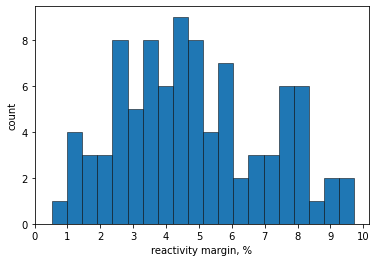

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

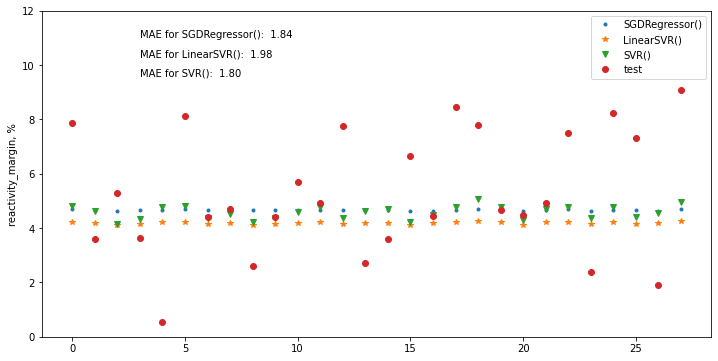

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


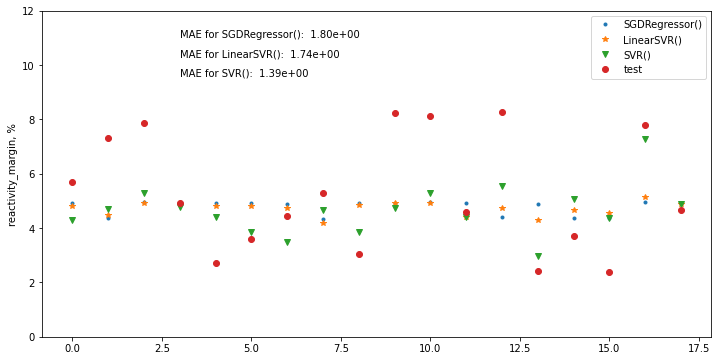

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [36]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [9]:
def objective(trial, data=main_df2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 1000, 4000, step=500),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 4, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {study.best_trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-07 14:56:01,337] A new study created in memory with name: no-name-f73686d6-c19e-45a0-a444-e8ec0e43b58b
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-07 14:56:24,870] Trial 0 finished with value: 2.430555282752741 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 8.227760886309509e-05, 'alpha': 0.0005691009810988934, 'subsample': 0.49651343391372627, 'colsample_bytree': 0.4376722526734275}. Best is trial 0 with value: 2.430555282752741.
[I 2022-07-07 14:56:36,377] Trial 2 finished with value: 5.236896119942323 and parameters: {'num_round': 1800, 'booster': 'gbtree', 'lambda': 0.043488084432377165, 'alpha': 5.076240052645602e-06, 'subsample': 0.7655432660452626, 'colsample_bytree': 0.9498836492494249, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0

[I 2022-07-07 15:00:21,699] Trial 18 finished with value: 5.390367561014091 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 9.967687997076664e-08, 'alpha': 0.06811103086406933, 'subsample': 0.9958571487362718, 'colsample_bytree': 0.5108706472997259, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005843056713221172, 'gamma': 2.1581692598993987e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:21,995] Trial 19 finished with value: 4.9187118444559035 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.3044484485748855e-08, 'alpha': 0.02621618880297237, 'subsample': 0.9676690745966772, 'colsample_bytree': 0.5391917491143224, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00073317502029619, 'gamma': 2.4762463159503173e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:26,096] Trial 20 finished with value: 5.268041688835375 and parameters: {'num_roun

[I 2022-07-07 15:06:37,595] Trial 35 finished with value: 1.3384715711936834 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.146244115275389e-05, 'alpha': 0.0012308000148380633, 'subsample': 0.6126090558827442, 'colsample_bytree': 0.3336802323208302, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6644770282947552, 'gamma': 0.04585402413811472, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029788770225999055, 'skip_drop': 1.1544550962501604e-08}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:06:56,167] Trial 36 finished with value: 5.3268839392372485 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.634879768358497e-07, 'alpha': 1.3270940492993441e-05, 'subsample': 0.4688011395580942, 'colsample_bytree': 0.22332051432376548, 'max_depth': 4, 'min_child_weight': 10, 'eta': 4.983906419770144e-07, 'gamma': 0.001129720093503864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'no

[I 2022-07-07 15:09:24,536] Trial 51 finished with value: 2.7229554535689062 and parameters: {'num_round': 1400, 'booster': 'dart', 'lambda': 1.4270712252836913e-08, 'alpha': 0.853230760538693, 'subsample': 0.23945152171561246, 'colsample_bytree': 0.4701140033147886, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9951707474161858, 'gamma': 1.062450736752566e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019025177638141438, 'skip_drop': 0.05163349254742995}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:10:09,675] Trial 52 finished with value: 1.0671565974842119 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1737189306985906e-06, 'alpha': 0.015638439698865133, 'subsample': 0.7849548387283576, 'colsample_bytree': 0.40902438412852865, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.3543336837811939, 'gamma': 0.0048179076939517404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 15:25:28,306] Trial 69 finished with value: 4.337536209157202 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.24453017370123636, 'alpha': 0.09352013493016875, 'subsample': 0.8767823291422302, 'colsample_bytree': 0.9987319583120113, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.020887156573176694, 'gamma': 0.060650834709808185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013402420076569265, 'skip_drop': 0.10669168908346881}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:25:28,368] Trial 67 finished with value: 4.938769699985421 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.0021958772887458833, 'alpha': 0.2941755343187844, 'subsample': 0.8567824578096948, 'colsample_bytree': 0.99451266460687, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.014996555320731866, 'gamma': 0.0004352672605138753, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type

[I 2022-07-07 16:36:57,270] Trial 83 finished with value: 1.5785141729367698 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.124474029746038e-06, 'alpha': 0.0015314525521278215, 'subsample': 0.9953524611504457, 'colsample_bytree': 0.6423257946145022, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.1068615778609044, 'gamma': 0.0008506055914695749, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,442] Trial 82 finished with value: 3.4562903622348764 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 7.0988396783169875e-06, 'alpha': 0.0017369197140864243, 'subsample': 0.9722486527914258, 'colsample_bytree': 0.629429403374727, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03912074913873038, 'gamma': 0.008976841687640954, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,552] Trial 84 finished with value: 2.009422917499417 and parameters: {'num_round'

[I 2022-07-07 17:05:28,557] Trial 99 finished with value: 2.1993361561082274 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 2.0603462728121785e-08, 'alpha': 0.16931994429517924, 'subsample': 0.8622841579641364, 'colsample_bytree': 0.5618767320681476}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:05:28,635] Trial 98 finished with value: 1.3947406837501617 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 4.6728464159812754e-07, 'alpha': 3.139289403673577e-06, 'subsample': 0.8656294875629816, 'colsample_bytree': 0.5535651471185415}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:07:25,541] Trial 102 finished with value: 3.393345311944049 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 6.393780020497667e-07, 'alpha': 3.985650167612618e-08, 'subsample': 0.7740739661592447, 'colsample_bytree': 0.663655078103167, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.05063542685911479, 'gamma': 0.04111

[I 2022-07-07 17:11:10,220] Trial 114 finished with value: 1.3160485491357572 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4592698581514695e-08, 'alpha': 0.024267542438143063, 'subsample': 0.6015700578991919, 'colsample_bytree': 0.24299988414930815, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6005672229746578, 'gamma': 0.031277972326379654, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10300946490748085, 'skip_drop': 0.5447220583184671}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:11:10,938] Trial 112 finished with value: 1.0780924470980557 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4281969083636526e-08, 'alpha': 0.021163418583992795, 'subsample': 0.6349590178198317, 'colsample_bytree': 0.391251761659751, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6725476875766118, 'gamma': 0.0005575373806224553, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 17:15:17,406] Trial 128 finished with value: 2.5155980169761896 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 8.95455146943706e-07, 'alpha': 0.23026912441752817, 'subsample': 0.7325719731281635, 'colsample_bytree': 0.36263841119041373, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.07134232671614706, 'gamma': 0.004040671022571215, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001225733218382395, 'skip_drop': 0.01910386017241191}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:15:19,702] Trial 130 finished with value: 1.470190229519847 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 1.1743408054876079e-06, 'alpha': 0.03454210446299013, 'subsample': 0.5413430091298302, 'colsample_bytree': 0.35629328887667316, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.18324379108817532, 'gamma': 0.1567599566621204, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize

[I 2022-07-07 17:22:32,061] Trial 145 finished with value: 1.1698020504740934 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.6158138168644865e-07, 'alpha': 0.0170718001405816, 'subsample': 0.8964760958789589, 'colsample_bytree': 0.288392435280711, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.8810792232434103, 'gamma': 0.012289905850100778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031748839768481283, 'skip_drop': 0.042751897992318974}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:22:32,108] Trial 143 finished with value: 1.098502758191897 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 4.02294602661843e-07, 'alpha': 0.01888127654131026, 'subsample': 0.895578704858783, 'colsample_bytree': 0.2531820699806269, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9513426058646318, 'gamma': 0.011409680983737626, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-07-07 17:26:02,869] Trial 159 finished with value: 2.048116957147524 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 9.13268574273984e-08, 'alpha': 0.028987539736236998, 'subsample': 0.707720479393189, 'colsample_bytree': 0.37051137024658637}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:04,866] Trial 160 finished with value: 1.860264137527366 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 3.928619566890204e-08, 'alpha': 0.02949847997993717, 'subsample': 0.7037049362090005, 'colsample_bytree': 0.40886628773248435}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:09,631] Trial 158 finished with value: 0.9473709440505679 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 2.940363680967826e-07, 'alpha': 0.02752516867990664, 'subsample': 0.851698707233464, 'colsample_bytree': 0.3748799020165568, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.6984984988185665, 'gamma': 0.0153293

[I 2022-07-07 17:28:46,634] Trial 173 finished with value: 0.8965075692077129 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1797143300861065e-07, 'alpha': 0.03309996897703381, 'subsample': 0.8742891315484451, 'colsample_bytree': 0.37857157903171434, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.654243614700289, 'gamma': 0.012960914614934609, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08844290281796843, 'skip_drop': 0.9444894725473495}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:29:00,119] Trial 175 finished with value: 1.3435422543552495 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.3485283577832868e-07, 'alpha': 0.03549020956458979, 'subsample': 0.6621119015274146, 'colsample_bytree': 0.3564381288502467, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.45529561632919896, 'gamma': 0.10390373390133761, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

In [52]:
#Рассмотрение концентрации в каждой зоне объема весьма затратно, поэтому создидим новый df с усредненными по твэлам концентрациями
NUM_ZONES_PER_FE = 360
df_avg_conc = pd.DataFrame()
for nuclide in ['u235', 'u238', 'pu39', 'xe35', 'sm49']:
    for num_matr in range(15563, 50123, NUM_ZONES_PER_FE):
        df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
df_avg_conc['ampule'] = main_df2.ampule
df_avg_conc.sample(5)

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc['ampule'] = main_df2.ampule


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49,ampule
14,0.001305,0.001330,0.001344,0.001350,0.001346,0.001328,0.001201,0.001212,0.001215,0.001210,...,1.688385e-07,1.709734e-07,1.628384e-07,1.463107e-07,1.470543e-07,1.474290e-07,1.473954e-07,1.471001e-07,1.464951e-07,1
72,0.001739,0.001805,0.001772,0.001811,0.001763,0.001742,0.001124,0.001116,0.001103,0.001123,...,1.838311e-07,1.864082e-07,1.833515e-07,1.671817e-07,1.663446e-07,1.623331e-07,1.647999e-07,1.667294e-07,1.624078e-07,1
56,0.001927,0.001990,0.001948,0.001989,0.001938,0.001921,0.001102,0.001102,0.001086,0.001085,...,2.508382e-07,2.523008e-07,2.479736e-07,3.010183e-07,2.939193e-07,2.840746e-07,2.874756e-07,2.923675e-07,2.899926e-07,1
40,0.001406,0.001399,0.001374,0.001399,0.001409,0.001353,0.001358,0.001341,0.001281,0.001305,...,2.217732e-07,2.225441e-07,2.183250e-07,1.232251e-08,1.152952e-08,1.088173e-08,1.088369e-08,1.111445e-08,1.132662e-08,0
38,0.001488,0.001479,0.001451,0.001478,0.001489,0.001432,0.001437,0.001417,0.001353,0.001379,...,3.387928e-07,3.410156e-07,3.386492e-07,2.458252e-07,2.477538e-07,2.492566e-07,2.504016e-07,2.512250e-07,2.518468e-07,0


In [54]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_avg_conc, target2, test_size=0.2, random_state=7)

In [403]:
def objective(trial, data=X_train3, label=y_train3):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 5000, 30000, step=5000),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": trial.suggest_categorical("tree_method",["approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 10.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 10.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-13 16:33:19,611] A new study created in memory with name: no-name-a7392ff2-9315-48db-bf97-0b2c97c8a42d
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2022-07-13 16:33:19,741] Trial 1 finished with value: 5.3958981814161495 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0001794403365428952, 'alpha': 26.663439192030253, 'subsample': 0.7650491635418211, 'colsample_bytree': 0.4975999971910688, 'max_depth': 9, 'min_child_weight': 7, 'eta': 4.496714044966245e-06, 'gamma': 0.017803420730944947, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 5.3958981814161495.
[I 2022-07-13 16:33:19,752] Trial 0 finished with value: 5.259960137282385 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.7701276672121994e-

[I 2022-07-13 16:33:20,525] Trial 18 finished with value: 1.9397055904953873 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 2.130866632488658, 'alpha': 0.01689200604211713, 'subsample': 0.3262323703021433, 'colsample_bytree': 0.9874773979406835}. Best is trial 17 with value: 1.7227560613935273.
[I 2022-07-13 16:33:20,617] Trial 19 finished with value: 2.604580535469299 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 2.357807746482308, 'alpha': 0.058900657640165686, 'subsample': 0.2853824298276441, 'colsample_bytree': 0.9995746034459574}. Best is trial 17 with value: 1.7227560613935273.
[I 2022-07-13 16:33:20,633] Trial 20 finished with value: 2.3959546036759254 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 1.7618136323468387, 'alpha': 0.03306121695858099, 'subsample': 0.2603845922261685, 'colsample_bytree': 0.9944840981189368}. Best is trial 17 w

[I 2022-07-13 16:33:21,723] Trial 38 finished with value: 5.227147797755354 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004240510314726788, 'alpha': 0.0009117883211092486, 'subsample': 0.4632691355767973, 'colsample_bytree': 0.9325165499452199, 'max_depth': 2, 'min_child_weight': 10, 'eta': 1.0862296997937214e-07, 'gamma': 1.8277834071717135e-07, 'grow_policy': 'lossguide'}. Best is trial 33 with value: 1.4316152994802542.
[I 2022-07-13 16:33:21,727] Trial 39 finished with value: 4265085035.4359765 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001983793291585698, 'alpha': 0.0008100437018381887, 'subsample': 0.48866524812695283, 'colsample_bytree': 0.9334624489123035, 'max_depth': 2, 'min_child_weight': 10, 'eta': 8.804644262732909, 'gamma': 1.4165225580108143e-08, 'grow_policy': 'lossguide'}. Best is trial 33 with value: 1.4316152994802542.
[I 2022-07-13 16:33:21,862] Trial 40 finished w

[I 2022-07-13 16:33:22,853] Trial 56 finished with value: 1.4188994378179 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 28.286873516672436, 'alpha': 2.8408663591288525, 'subsample': 0.7885028554316604, 'colsample_bytree': 0.42915081348785267, 'max_depth': 14, 'min_child_weight': 9, 'eta': 0.6496717338643225, 'gamma': 9.97403970494448e-05, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 1.4188994378179.
[I 2022-07-13 16:33:22,982] Trial 57 finished with value: 4497475919.659601 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.000303096426127268, 'alpha': 12.428678532307199, 'subsample': 0.79462029313693, 'colsample_bytree': 0.3171394093400554, 'max_depth': 15, 'min_child_weight': 9, 'eta': 9.0212089548701, 'gamma': 3.075976116738049e-06, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 1.4188994378179.
[I 2022-07-13 16:33:23,015] Trial 58 finished with value: 3.8358385928978995 and

[I 2022-07-13 16:33:24,092] Trial 74 finished with value: 1.8611669365556625 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.468306336808785, 'alpha': 3.011395480001139, 'subsample': 0.8634055756240946, 'colsample_bytree': 0.3707829672617527, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.9102531833292441, 'gamma': 1.413230585645573, 'grow_policy': 'depthwise'}. Best is trial 65 with value: 1.120144156360358.
[I 2022-07-13 16:33:24,171] Trial 75 finished with value: 1.9659945568376342 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.35816519714001, 'alpha': 24.4821052870729, 'subsample': 0.8726749073045366, 'colsample_bytree': 0.3632127072277132, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.9180255879998247, 'gamma': 0.07983217757583833, 'grow_policy': 'depthwise'}. Best is trial 65 with value: 1.120144156360358.
[I 2022-07-13 16:33:24,225] Trial 76 finished with value: 4911.358103096885 and 

[I 2022-07-13 16:33:25,284] Trial 90 finished with value: 1.578269807890964 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.028526340181659893, 'alpha': 0.042681357011495405, 'subsample': 0.8958481052941197, 'colsample_bytree': 0.42427168899589573, 'max_depth': 10, 'min_child_weight': 9, 'eta': 1.6244132082065568, 'gamma': 0.001573775166241168, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.773535138726201e-06, 'skip_drop': 0.12810442054288929}. Best is trial 87 with value: 1.0996568778009637.
[I 2022-07-13 16:33:25,385] Trial 91 finished with value: 1.6502048323043161 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.009985307111345014, 'alpha': 0.028441789136979787, 'subsample': 0.7382903155067884, 'colsample_bytree': 0.5192447308510797, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.20603770685675052, 'gamma': 0.00047584739367929657, 'grow_policy': '

[I 2022-07-13 16:33:26,417] Trial 104 finished with value: 2.374323192068518 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0015731208215556374, 'alpha': 0.00031184614263034846, 'subsample': 0.8543812854919464, 'colsample_bytree': 0.330641617988047, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.05135869696833039, 'gamma': 4.561805066731042e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.7891323604623664e-08, 'skip_drop': 8.842186576623495e-05}. Best is trial 87 with value: 1.0996568778009637.
[I 2022-07-13 16:33:26,460] Trial 105 finished with value: 924087824.0395441 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.001162568445792167, 'alpha': 0.0014821938062880376, 'subsample': 0.780725884270913, 'colsample_bytree': 0.3318414050591707, 'max_depth': 7, 'min_child_weight': 5, 'eta': 7.759936004058335, 'gamma': 3.301071983260942e-05, 'grow_policy'

[I 2022-07-13 16:33:27,512] Trial 118 finished with value: 1.9011545250284607 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.522202605417467e-06, 'alpha': 1.1634112907710593e-05, 'subsample': 0.7449471394906813, 'colsample_bytree': 0.6588387824220041, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.9992809147745346, 'gamma': 0.0005945198028731863, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.327811431330151e-05, 'skip_drop': 0.0004371182469620999}. Best is trial 112 with value: 0.9356253067866519.
[I 2022-07-13 16:33:27,561] Trial 119 finished with value: 1.754295426301323 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.008972258047552e-05, 'alpha': 2.3074453347744845e-05, 'subsample': 0.7212769479096156, 'colsample_bytree': 0.621330897204213, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.13425953177784558, 'gamma': 0.0005251339975177688, 'grow_poli

[I 2022-07-13 16:33:28,575] Trial 132 finished with value: 2.138081734400171 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.0934276414126694e-05, 'alpha': 8.751338036134255e-07, 'subsample': 0.7116427267221667, 'colsample_bytree': 0.7596067808351288, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.16730896680217708, 'gamma': 7.47161179525656e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.906743701662711e-06, 'skip_drop': 4.5020220982366364e-05}. Best is trial 112 with value: 0.9356253067866519.
[I 2022-07-13 16:33:28,726] Trial 133 finished with value: 1.5075812154301287 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.717053423471524e-06, 'alpha': 6.523773830868446e-07, 'subsample': 0.6636171871651483, 'colsample_bytree': 0.7019577582629902, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.9619399173631663, 'gamma': 0.000421535036511289, 'grow_polic

[I 2022-07-13 16:33:29,866] Trial 146 finished with value: 1.8445220380111236 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.09059987548462353, 'alpha': 0.0007755494635110585, 'subsample': 0.7762317758919094, 'colsample_bytree': 0.6870330659160382, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.1451785203314916, 'gamma': 0.0001224414186920133, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.041562040776633e-06, 'skip_drop': 2.5594656236107245e-06}. Best is trial 112 with value: 0.9356253067866519.
[I 2022-07-13 16:33:29,944] Trial 147 finished with value: 2.4337024989173908 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002613793288032533, 'alpha': 0.0009683023218293777, 'subsample': 0.7797339872761531, 'colsample_bytree': 0.7345167767307637, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.10817784648215782, 'gamma': 0.0001229298237076734, 'grow_polic

[I 2022-07-13 16:33:31,003] Trial 160 finished with value: 3.2363390250299884 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.002360365130790354, 'alpha': 0.0040514224673282315, 'subsample': 0.8248414976053126, 'colsample_bytree': 0.5310025163470592, 'max_depth': 4, 'min_child_weight': 6, 'eta': 1.5422206991606668, 'gamma': 1.3777373367632308e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6196170211886285e-07, 'skip_drop': 1.3310990301271172e-05}. Best is trial 112 with value: 0.9356253067866519.
[I 2022-07-13 16:33:31,057] Trial 161 finished with value: 2.787481693486394 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0022681511491165684, 'alpha': 0.00258511625405707, 'subsample': 0.8270817604480607, 'colsample_bytree': 0.5218306486997338, 'max_depth': 4, 'min_child_weight': 6, 'eta': 1.5045582325287805, 'gamma': 1.0437523497150698e-06, 'grow_polic

[I 2022-07-13 16:33:32,173] Trial 174 finished with value: 2.7373076683510424 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.09472806587054786, 'alpha': 6.984909963779198e-05, 'subsample': 0.6105842899113217, 'colsample_bytree': 0.8537421543994484, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.07371754678169967, 'gamma': 0.0005747785035853723, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0036083865068426975, 'skip_drop': 0.05939250046576099}. Best is trial 112 with value: 0.9356253067866519.
[I 2022-07-13 16:33:32,301] Trial 175 finished with value: 1.0834279947098964 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.04826323535468205, 'alpha': 0.00033597204039903343, 'subsample': 0.7811870573233128, 'colsample_bytree': 0.8762644969737199, 'max_depth': 20, 'min_child_weight': 8, 'eta': 0.38057042181777484, 'gamma': 0.004725219631978346, 'grow_poli

[I 2022-07-13 16:33:33,390] Trial 188 finished with value: 1.3577313695562507 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.051682681454758995, 'alpha': 0.00010413830521065517, 'subsample': 0.6004168632380628, 'colsample_bytree': 0.9004554083899741, 'max_depth': 20, 'min_child_weight': 8, 'eta': 0.6074313230041201, 'gamma': 0.00019387202994936305, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3599193969522137e-05, 'skip_drop': 0.00550413093578926}. Best is trial 186 with value: 0.8982674064033286.
[I 2022-07-13 16:33:33,489] Trial 189 finished with value: 6203.590918360595 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0357539646122627, 'alpha': 0.00029351325403530534, 'subsample': 0.5685492327795187, 'colsample_bytree': 0.8742050340801856, 'max_depth': 20, 'min_child_weight': 8, 'eta': 3.069235700259076, 'gamma': 0.00023587933574761212, 'grow_pol

[I 2022-07-13 16:33:34,588] Trial 202 finished with value: 1.5763418880807432 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.16520055119491522, 'alpha': 0.0034056652577668135, 'subsample': 0.6431808344647241, 'colsample_bytree': 0.8645717106389382, 'max_depth': 20, 'min_child_weight': 9, 'eta': 0.5271940658373699, 'gamma': 0.0004029525086253454, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00010688739023427786, 'skip_drop': 0.3430219850828319}. Best is trial 186 with value: 0.8982674064033286.
[I 2022-07-13 16:33:34,671] Trial 203 finished with value: 1.4270042883687122 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.05613399487557756, 'alpha': 0.001545562187994768, 'subsample': 0.6385597827027141, 'colsample_bytree': 0.8744428299651743, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.5818828244215399, 'gamma': 0.00047237756839523, 'grow_policy': '

[I 2022-07-13 16:33:35,822] Trial 216 finished with value: 5.430310203219865 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.5496870846825698, 'alpha': 9.772574033847374e-05, 'subsample': 0.6292943941236805, 'colsample_bytree': 0.8891343451557479, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.0004328151445901061, 'gamma': 0.0007731562666723057, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.544998061725902e-07, 'skip_drop': 4.74693807720152e-08}. Best is trial 186 with value: 0.8982674064033286.
[I 2022-07-13 16:33:35,888] Trial 217 finished with value: 1.546406853522704 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.01337515279971301, 'alpha': 0.00011024552144708828, 'subsample': 0.6000200336977815, 'colsample_bytree': 0.891280541577038, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.17882238167495978, 'gamma': 5.911641990023544e-06, 'grow_poli

[I 2022-07-13 16:33:37,101] Trial 230 finished with value: 1.1778515657848774 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000710423027911457, 'alpha': 0.0010601099516104545, 'subsample': 0.7340024122957163, 'colsample_bytree': 0.4753011870955137, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.41107547142633244, 'gamma': 0.0008830034431139065, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031847869176659504, 'skip_drop': 1.9949418756734116e-06}. Best is trial 229 with value: 0.8619474520097836.
[I 2022-07-13 16:33:37,195] Trial 231 finished with value: 1.520437254791533 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.055385988505512226, 'alpha': 0.0010472336850052251, 'subsample': 0.7375608496715305, 'colsample_bytree': 0.47975818475861975, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.40368449009061086, 'gamma': 7.581953188579654e-05, 'grow_po

[I 2022-07-13 16:33:38,418] Trial 245 finished with value: 1.350735178889687 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.05368350252633269, 'alpha': 0.00046713624610826435, 'subsample': 0.7765989902583819, 'colsample_bytree': 0.4623683551656167, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.4377251185888661, 'gamma': 3.560112937040645e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0043143983614561225, 'skip_drop': 3.6446603777503055e-07}. Best is trial 229 with value: 0.8619474520097836.
[I 2022-07-13 16:33:38,454] Trial 246 finished with value: 1.2276849895327786 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.05082913738228071, 'alpha': 0.00038423464220472815, 'subsample': 0.7688912655548213, 'colsample_bytree': 0.44854741688871824, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.4386776687743397, 'gamma': 9.370458866587467e-05, 'grow_poli

[I 2022-07-13 16:33:39,724] Trial 259 finished with value: 1.2715612102700766 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.04447910491767371, 'alpha': 3.976681997568049e-08, 'subsample': 0.6838849314638936, 'colsample_bytree': 0.903158251580647, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.26267571364956055, 'gamma': 8.616607393525596e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.004430090302341e-06, 'skip_drop': 0.16596079349860812}. Best is trial 229 with value: 0.8619474520097836.
[I 2022-07-13 16:33:39,909] Trial 260 finished with value: 1.1445397727910631 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.04168417425636673, 'alpha': 0.00740318476060888, 'subsample': 0.6787897810681208, 'colsample_bytree': 0.44296022511760896, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.5156990690523481, 'gamma': 0.001112140672581634, 'grow_policy': 

[I 2022-07-13 16:33:41,184] Trial 273 finished with value: 2.018390954265623 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.886053043304067e-05, 'alpha': 0.0029878326714204945, 'subsample': 0.7528380304435788, 'colsample_bytree': 0.8431246313665847, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.6736894335851434, 'gamma': 3.0056819678449035e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.02549609168868007, 'skip_drop': 0.0006979373347043691}. Best is trial 229 with value: 0.8619474520097836.
[I 2022-07-13 16:33:41,196] Trial 274 finished with value: 1.3065866848056071 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.291895312941671e-05, 'alpha': 0.005671617851839491, 'subsample': 0.7544411916151823, 'colsample_bytree': 0.845484808186008, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.5713219053387227, 'gamma': 2.6919399495607067e-05, 'grow_poli

[I 2022-07-13 16:33:42,704] Trial 288 finished with value: 2.278008649492834 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00014025313666766393, 'alpha': 0.0022814999448123275, 'subsample': 0.5099253193590282, 'colsample_bytree': 0.4367685514043804, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.1533005699601, 'gamma': 0.0005460393504239056, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.010583627821062582, 'skip_drop': 0.05816996271745342}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:42,712] Trial 289 finished with value: 1.8830499645663132 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.743626691158404e-05, 'alpha': 0.0025434656669288008, 'subsample': 0.49707331388425924, 'colsample_bytree': 0.4888475234904228, 'max_depth': 12, 'min_child_weight': 6, 'eta': 0.14567441145996682, 'gamma': 0.0005192456693391663, 'grow_poli

[I 2022-07-13 16:33:44,384] Trial 303 finished with value: 1.349700324709317 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0025916748518292326, 'alpha': 0.008857764831943197, 'subsample': 0.5886146607782562, 'colsample_bytree': 0.396235149743425, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.47931494067566405, 'gamma': 0.0038480487791042683, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.01070814632123064, 'skip_drop': 0.15773508279189563}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:44,433] Trial 304 finished with value: 1.179120509856446 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.004642008702407976, 'alpha': 0.0005706747904228702, 'subsample': 0.5850691671870232, 'colsample_bytree': 0.4460341741403125, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.18488512319657485, 'gamma': 0.004078947356717877, 'grow_policy': 'd

[I 2022-07-13 16:33:45,778] Trial 316 finished with value: 4.632499594872518 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.032481536111518564, 'alpha': 0.00214422838241093, 'subsample': 0.46433888847366805, 'colsample_bytree': 0.40395495018862454, 'max_depth': 12, 'min_child_weight': 2, 'eta': 0.0037169070545610776, 'gamma': 0.0032291976541727226, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4516141848237364e-06, 'skip_drop': 3.0635282685825065e-07}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:45,832] Trial 318 finished with value: 1.6511153796768263 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.029519152073677075, 'alpha': 0.0009492157487143104, 'subsample': 0.449642039898288, 'colsample_bytree': 0.40350857369691, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.10558467697872115, 'gamma': 2.847482298320599e-08, 'grow_

[I 2022-07-13 16:33:47,634] Trial 331 finished with value: 1.5338155722310944 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.01433820664461013, 'alpha': 0.02291725510136954, 'subsample': 0.5975869384962038, 'colsample_bytree': 0.4506911017759982, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.2366918578405548, 'gamma': 0.00032920291395167466, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.022743342668648144, 'skip_drop': 0.00022171886630893513}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:47,696] Trial 333 finished with value: 1.4510570319652065 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.001285716698937225, 'alpha': 0.02166432993960632, 'subsample': 0.5937339385998395, 'colsample_bytree': 0.3632513862610266, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.2411482340522898, 'gamma': 0.00032825210560286414, 'grow_policy':

[I 2022-07-13 16:33:49,621] Trial 345 finished with value: 1.0334648786579255 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.01897935056394391, 'alpha': 0.006748045442850813, 'subsample': 0.7396593213898551, 'colsample_bytree': 0.835942257332868, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.37439673826167913, 'gamma': 9.930997207761409e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.1161816359810645e-06, 'skip_drop': 2.473316149139491e-06}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:49,650] Trial 346 finished with value: 1.1073946599323896 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0016977419999061384, 'alpha': 0.0002165597557932358, 'subsample': 0.6233403792708556, 'colsample_bytree': 0.9413643728406635, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.37398823227071587, 'gamma': 9.048089271795785e-05, 'grow_pol

[I 2022-07-13 16:33:51,169] Trial 359 finished with value: 1.0855191579153767 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0031460950338212243, 'alpha': 0.0018444136289858706, 'subsample': 0.6128437834084128, 'colsample_bytree': 0.5079445123490351, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.4449427126805122, 'gamma': 0.00026777336533214557, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.004458600044552283, 'skip_drop': 5.824393656946734e-07}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:51,318] Trial 360 finished with value: 1.0700453908427925 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0031290429214254527, 'alpha': 0.001392820113993811, 'subsample': 0.5387147529717136, 'colsample_bytree': 0.5105024559105797, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.2807093190344832, 'gamma': 0.00023267690286818892, 'grow_poli

[I 2022-07-13 16:33:53,116] Trial 373 finished with value: 1.2150134063320646 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00017393656979328086, 'alpha': 0.000839999282506589, 'subsample': 0.6510670908793116, 'colsample_bytree': 0.8861678660412518, 'max_depth': 20, 'min_child_weight': 10, 'eta': 0.46595823892242455, 'gamma': 6.87370481470429e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1874417554843395, 'skip_drop': 5.3346967719065235e-08}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:53,151] Trial 374 finished with value: 1.3826829800578524 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004937462766695768, 'alpha': 0.0008243963784430799, 'subsample': 0.4275022753405838, 'colsample_bytree': 0.9168018370483852, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.39357536121043407, 'gamma': 9.437422661378958e-05, 'grow_p

[I 2022-07-13 16:33:54,720] Trial 387 finished with value: 1.9404127315807036 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.566805137881875e-05, 'alpha': 0.004007109624419697, 'subsample': 0.4885553804491651, 'colsample_bytree': 0.8367298393200437, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.9898269134782394, 'gamma': 3.803069910197524e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.015211460494752057, 'skip_drop': 1.0035564844998504e-08}. Best is trial 286 with value: 0.8055197642605674.
[I 2022-07-13 16:33:54,837] Trial 388 finished with value: 1.2014046676695835 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.431667182457579e-05, 'alpha': 0.001411459203439962, 'subsample': 0.4442113312834786, 'colsample_bytree': 0.8566634268484908, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.9387165886006895, 'gamma': 0.00014951718335887845, 'grow_

[I 2022-07-13 16:33:56,302] Trial 400 finished with value: 0.9709298106398135 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002758038713862291, 'alpha': 0.004166338647905222, 'subsample': 0.46842693329497365, 'colsample_bytree': 0.43657397686359456, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.2667532594438484, 'gamma': 4.658914480838142e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.23126239278737e-06, 'skip_drop': 0.0009006502443795584}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:33:56,544] Trial 402 finished with value: 1.3037834204162018 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00028646234422452787, 'alpha': 0.01349653459083359, 'subsample': 0.7497221153988103, 'colsample_bytree': 0.7927702127286206, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2403254208243301, 'gamma': 2.621506199452646e-05, 'grow_polic

[I 2022-07-13 16:33:58,287] Trial 415 finished with value: 0.9390339248137433 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004129432665318827, 'alpha': 0.0037302169308068103, 'subsample': 0.7609526719301579, 'colsample_bytree': 0.42324993703006064, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.3195912443929783, 'gamma': 0.015576679639080665, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.786691322027396e-06, 'skip_drop': 0.0004948289311465428}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:33:58,468] Trial 416 finished with value: 2.6073488819165527 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0012317866155858196, 'alpha': 0.009226732342175156, 'subsample': 0.7613963991979268, 'colsample_bytree': 0.3954812294777471, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.07219712021462031, 'gamma': 0.04934645134103127, 'grow_policy'

[I 2022-07-13 16:34:00,887] Trial 430 finished with value: 1.3244116765419776 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0009428631518509874, 'alpha': 0.0009849276728770492, 'subsample': 0.7597259932930197, 'colsample_bytree': 0.21294230120111102, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.48755239651916, 'gamma': 5.637468447227983e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.775892012801083e-06, 'skip_drop': 3.685112306884208e-05}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:01,141] Trial 432 finished with value: 1.530629478823525 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00022116940495536515, 'alpha': 0.016474278245717722, 'subsample': 0.6659749250370036, 'colsample_bytree': 0.4597948645409575, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.2008997610008465, 'gamma': 6.814951419501416e-05, 'grow_policy

[I 2022-07-13 16:34:03,352] Trial 444 finished with value: 1.7819685896396378 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00048474842354449203, 'alpha': 0.0007931069527218654, 'subsample': 0.7534600610181941, 'colsample_bytree': 0.4650312788083087, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3143590068117596, 'gamma': 4.875396567181669e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.009445436986409185, 'skip_drop': 0.0001783488942013347}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:03,353] Trial 445 finished with value: 1.226813613860687 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.4260067047660576, 'alpha': 0.0007716129034005378, 'subsample': 0.7580918717901659, 'colsample_bytree': 0.745726976480201, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3534642678783705, 'gamma': 4.89667192220649e-05, 'grow_policy': 

[I 2022-07-13 16:34:05,539] Trial 458 finished with value: 1.9208600190511926 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.31226837986199524, 'alpha': 0.0002448743488525396, 'subsample': 0.5483279894751564, 'colsample_bytree': 0.5059765242984112, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.849536635238907, 'gamma': 5.687271306459183e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.04156001218268322, 'skip_drop': 2.695234552520783e-07}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:05,641] Trial 459 finished with value: 2.4575878906528414 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.32711653112136435, 'alpha': 0.00019417344082725793, 'subsample': 0.5452696228412999, 'colsample_bytree': 0.5000848036577886, 'max_depth': 16, 'min_child_weight': 6, 'eta': 1.6687010850910975, 'gamma': 4.45178418601459e-05, 'grow_policy': '

[I 2022-07-13 16:34:07,131] Trial 473 finished with value: 1.4800956822070122 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.637429490297412e-05, 'alpha': 0.0006158115510563459, 'subsample': 0.7043176652081186, 'colsample_bytree': 0.4632323175321179, 'max_depth': 12, 'min_child_weight': 6, 'eta': 0.23564798579943136, 'gamma': 0.031618828957904056, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06276725888430507, 'skip_drop': 4.952339949239664e-07}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:07,320] Trial 474 finished with value: 1.1444201569942476 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.011124956986271e-05, 'alpha': 0.00014821610185442683, 'subsample': 0.5324551494036736, 'colsample_bytree': 0.4595447884135636, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.4752636459892905, 'gamma': 5.433675250700197e-05, 'grow_poli

[I 2022-07-13 16:34:09,038] Trial 487 finished with value: 1.5026985365921715 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00010815514072361787, 'alpha': 0.0006339932543782954, 'subsample': 0.45867483869913434, 'colsample_bytree': 0.4534070406865306, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.4190756134142295, 'gamma': 3.5678732161564164e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.123353820792113e-06, 'skip_drop': 0.0004617503864773226}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:09,122] Trial 488 finished with value: 13099301.060338147 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019714795219892984, 'alpha': 0.000686570922776558, 'subsample': 0.4607262296318484, 'colsample_bytree': 0.5192699890578155, 'max_depth': 11, 'min_child_weight': 7, 'eta': 7.782940698463118, 'gamma': 3.533668537030039e-05, 'grow_po

[I 2022-07-13 16:34:10,677] Trial 501 finished with value: 1.271461412036504 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.52477526002987e-05, 'alpha': 0.0011660818606368305, 'subsample': 0.670673737117814, 'colsample_bytree': 0.4578527449741513, 'max_depth': 10, 'min_child_weight': 5, 'eta': 0.27548182935160537, 'gamma': 0.00016016490065975795, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.01464690345067535, 'skip_drop': 3.225848623812916e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:10,732] Trial 502 finished with value: 1.0891443384800314 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.119795931299442e-07, 'alpha': 0.0014391663122140632, 'subsample': 0.6770579989160571, 'colsample_bytree': 0.6219259806347621, 'max_depth': 10, 'min_child_weight': 10, 'eta': 0.30273306824030494, 'gamma': 0.00015968646798917484, 'grow_pol

[I 2022-07-13 16:34:12,162] Trial 517 finished with value: 1.4602277335632399 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0024635476758094535, 'alpha': 0.003150654627874596, 'subsample': 0.7504754431504348, 'colsample_bytree': 0.704557577467196, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.1691163043991541, 'gamma': 0.00012489788976669715, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.47578154534003e-06, 'skip_drop': 0.0006399588184706333}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:12,163] Trial 516 finished with value: 1.5704190225974757 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002143818259508114, 'alpha': 0.003194003823685861, 'subsample': 0.7562454194630518, 'colsample_bytree': 0.4304262216736626, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.16694898881800851, 'gamma': 0.00014405941920505322, 'grow_poli

[I 2022-07-13 16:34:13,816] Trial 531 finished with value: 1.0267032444764501 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.004712574809397261, 'alpha': 0.0003589776341187191, 'subsample': 0.7783181711534141, 'colsample_bytree': 0.5133181199100908, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.46499579071220026, 'gamma': 0.00038667708604486685, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.2820871596774045e-06, 'skip_drop': 0.0005812395193931055}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:13,843] Trial 532 finished with value: 1.1954428701606685 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00024280653787760517, 'alpha': 0.004966883051102894, 'subsample': 0.7444112051389474, 'colsample_bytree': 0.2685393640539141, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.537823297318464, 'gamma': 0.0004550186218533188, 'grow_po

[I 2022-07-13 16:34:15,757] Trial 545 finished with value: 1.094373268141241 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002879322772829259, 'alpha': 0.0003800642956098792, 'subsample': 0.7608157490709471, 'colsample_bytree': 0.7182471469162457, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.40041425822633525, 'gamma': 0.007903418763366359, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4546181913557126, 'skip_drop': 1.3063272914818318e-06}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:15,879] Trial 546 finished with value: 1.269419752028558 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003559285486352759, 'alpha': 0.00039313116843825506, 'subsample': 0.7825265286878882, 'colsample_bytree': 0.4593236234647541, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.4048061934888818, 'gamma': 0.00013985332917122397, 'grow_policy':

[I 2022-07-13 16:34:18,368] Trial 559 finished with value: 1.5952555155821408 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.42092232766920473, 'alpha': 0.0032004861080155112, 'subsample': 0.7466087777998324, 'colsample_bytree': 0.500357528858453, 'max_depth': 15, 'min_child_weight': 9, 'eta': 0.9119076091418048, 'gamma': 0.02595783964684809, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.0132223532711086e-05, 'skip_drop': 0.0023845890346878827}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:18,589] Trial 560 finished with value: 1.4723525195592693 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.6907566184377886, 'alpha': 0.004359256237254135, 'subsample': 0.7467154462896709, 'colsample_bytree': 0.8100779734813438, 'max_depth': 16, 'min_child_weight': 3, 'eta': 1.0003859183822101, 'gamma': 0.1549973248331655, 'grow_policy': 'dept

[I 2022-07-13 16:34:20,390] Trial 573 finished with value: 5.499265353800131 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.750819580530817e-05, 'alpha': 0.003252070598504507, 'subsample': 0.7197736116810703, 'colsample_bytree': 0.700137365544225, 'max_depth': 6, 'min_child_weight': 6, 'eta': 1.8532657657312057, 'gamma': 0.06836153551404363, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.024910565291922e-06, 'skip_drop': 6.604948100721525e-05}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:20,513] Trial 574 finished with value: 3.4469848412898707 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.444983303382613, 'alpha': 0.003088240814254733, 'subsample': 0.6577616337621487, 'colsample_bytree': 0.7295852545713464, 'max_depth': 5, 'min_child_weight': 6, 'eta': 2.049662572593732, 'gamma': 0.00010412070087851035, 'grow_policy': 'depth

[I 2022-07-13 16:34:21,958] Trial 588 finished with value: 2.266516617672682 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006678480470417128, 'alpha': 0.001140567180486625, 'subsample': 0.7785268731597245, 'colsample_bytree': 0.7120649457968041, 'max_depth': 5, 'min_child_weight': 6, 'eta': 1.1653019473843291, 'gamma': 8.18800876358013e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.489175992679436e-06, 'skip_drop': 0.00014805765103472274}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:22,041] Trial 589 finished with value: 1.4080741363766431 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.725334555959399e-05, 'alpha': 0.0011667001144796587, 'subsample': 0.7331603825814487, 'colsample_bytree': 0.6471444959697191, 'max_depth': 5, 'min_child_weight': 6, 'eta': 1.1626829117882267, 'gamma': 8.017301748815442e-05, 'grow_policy'

[I 2022-07-13 16:34:23,800] Trial 602 finished with value: 3.4726181967812213 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005738507623505235, 'alpha': 0.006338343720782815, 'subsample': 0.7351174667620748, 'colsample_bytree': 0.7211527657941494, 'max_depth': 19, 'min_child_weight': 6, 'eta': 1.5343633772820917, 'gamma': 0.0005530831324920959, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.870276675460226e-06, 'skip_drop': 0.0001888791919712479}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:23,898] Trial 603 finished with value: 2.4399172866691914 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005180337767569193, 'alpha': 0.0015994514138101255, 'subsample': 0.5816520231900459, 'colsample_bytree': 0.3848485753478363, 'max_depth': 4, 'min_child_weight': 6, 'eta': 1.4676668204766214, 'gamma': 0.0002681029854420556, 'grow_polic

[I 2022-07-13 16:34:25,870] Trial 617 finished with value: 1.6955878831942361 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00022326468333819891, 'alpha': 0.005589431543977823, 'subsample': 0.7892269053576523, 'colsample_bytree': 0.411597703838811, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.4025174307517303, 'gamma': 0.0004699546653334177, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00031772661830095097, 'skip_drop': 0.6314847652745555}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:25,956] Trial 618 finished with value: 1.574231099481001 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.094594183886435, 'alpha': 0.0005748827668852688, 'subsample': 0.7748286008038684, 'colsample_bytree': 0.6215597447871091, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.39969250423839825, 'gamma': 0.0004960837574086761, 'grow_policy': 

[I 2022-07-13 16:34:27,601] Trial 631 finished with value: 1.0800061286878804 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00020282183678113947, 'alpha': 0.0012604721403566199, 'subsample': 0.8267959655359794, 'colsample_bytree': 0.4514797030754619, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.4923899967867522, 'gamma': 0.00031091534790448293, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.697737598688904e-05, 'skip_drop': 2.310466153544481e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:27,674] Trial 632 finished with value: 1.6381737131872995 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00011774011658140282, 'alpha': 37.43457991513573, 'subsample': 0.8278758766381116, 'colsample_bytree': 0.4455283112349197, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.48607519031644153, 'gamma': 0.0003297118688234993, 'grow_p

[I 2022-07-13 16:34:29,310] Trial 646 finished with value: 2.3435812730672527 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 3.728768551835081e-05, 'alpha': 0.001982762423988018, 'subsample': 0.8278936404066936, 'colsample_bytree': 0.4054730859354536}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:29,429] Trial 645 finished with value: 1.4691669556894391 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.841447956640003e-05, 'alpha': 0.0021245053695506696, 'subsample': 0.8585197505127369, 'colsample_bytree': 0.3923148202668808, 'max_depth': 20, 'min_child_weight': 9, 'eta': 1.3841004835924364, 'gamma': 0.0005315431965618532, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.900630324376022e-05, 'skip_drop': 1.4476881479715723e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:29,760] Trial 647 finished with

[I 2022-07-13 16:34:31,286] Trial 659 finished with value: 1.6184189117352683 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.260487722063235e-05, 'alpha': 0.00030359120767888925, 'subsample': 0.7888340538966607, 'colsample_bytree': 0.6088819365041063, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.28436163516473173, 'gamma': 0.024808652620095517, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.190925296037921e-05, 'skip_drop': 4.98275504890163e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:31,416] Trial 660 finished with value: 1.208476527654364 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00014507664814691752, 'alpha': 0.003924424292218188, 'subsample': 0.8522602216596912, 'colsample_bytree': 0.4608144855137908, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.299477913060331, 'gamma': 0.00020582494259829053, 'grow_po

[I 2022-07-13 16:34:33,175] Trial 674 finished with value: 1.136945058439564 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001939868783196504, 'alpha': 6.745544270634243e-07, 'subsample': 0.9019069492189828, 'colsample_bytree': 0.4017044098458685, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.57634131675081, 'gamma': 0.00014038069133008683, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.1643549814419144e-05, 'skip_drop': 8.147077006070877e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:33,209] Trial 675 finished with value: 1.9039633074615083 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00017924247007260687, 'alpha': 3.7847415240832416e-08, 'subsample': 0.9097722388481821, 'colsample_bytree': 0.40379000702820605, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.5746222829611096, 'gamma': 0.0001517616885333424, 'grow_po

[I 2022-07-13 16:34:35,072] Trial 687 finished with value: 1.7976359703717384 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00014720246957116193, 'alpha': 2.7455976105409273e-05, 'subsample': 0.9344798648254596, 'colsample_bytree': 0.5854874550375214, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.6790991999182137, 'gamma': 0.00016919841332806068, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.236178601633984e-05, 'skip_drop': 2.834707584150758e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:35,446] Trial 689 finished with value: 2.946962008595027 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.6731731809803385, 'alpha': 1.6982335125068e-08, 'subsample': 0.7938437878567546, 'colsample_bytree': 0.45358733162885284, 'max_depth': 2, 'min_child_weight': 6, 'eta': 1.8959287330361538, 'gamma': 0.0002826055302152984, 'grow_polic

[I 2022-07-13 16:34:37,095] Trial 702 finished with value: 1.0224243679948277 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.3997279232957195e-05, 'alpha': 1.2524683872649956e-06, 'subsample': 0.9302027733487288, 'colsample_bytree': 0.565867287150568, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.36854664619645455, 'gamma': 0.0001293589797933242, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.020012119709661e-05, 'skip_drop': 7.261371509248206e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:37,122] Trial 703 finished with value: 1.868769344674662 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001090395889719624, 'alpha': 9.310700464163908e-08, 'subsample': 0.9208995738109117, 'colsample_bytree': 0.5101184280264713, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.07782645868212358, 'gamma': 0.00014006300291766356, 'grow

[I 2022-07-13 16:34:38,988] Trial 717 finished with value: 5.192181903313973 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.4664577716583957e-06, 'alpha': 9.233416706568033e-05, 'subsample': 0.786194404870996, 'colsample_bytree': 0.854471810535944, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.0006009424588618793, 'gamma': 5.565072726793774, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.382774576429438e-05, 'skip_drop': 0.34144846117879935}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:39,008] Trial 718 finished with value: 2.2805619666647825 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00017602078607272868, 'alpha': 0.011031925947737909, 'subsample': 0.6291789171159332, 'colsample_bytree': 0.853817039063375, 'max_depth': 8, 'min_child_weight': 6, 'eta': 1.139782467171418, 'gamma': 5.668368252964933e-05, 'grow_policy': '

[I 2022-07-13 16:34:40,886] Trial 732 finished with value: 2.0333262297090395 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0001321853342742416, 'alpha': 0.0045371948870094264, 'subsample': 0.7962180680767167, 'colsample_bytree': 0.5385988620991684, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.9897281376719819, 'gamma': 0.0010365076034939747, 'grow_policy': 'lossguide'}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:40,993] Trial 733 finished with value: 1.3464421972368652 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.209731771113513e-05, 'alpha': 0.004148550087140161, 'subsample': 0.7953533536227829, 'colsample_bytree': 0.5084112081395397, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.8968004311223623, 'gamma': 5.884899295286738e-05, 'grow_policy': 'lossguide'}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:41,128] Trial 734 finished with v

[I 2022-07-13 16:34:43,100] Trial 750 finished with value: 4.594736921113115 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002177101100098519, 'alpha': 0.88423425314102, 'subsample': 0.5948366079244712, 'colsample_bytree': 0.7120769382836545, 'max_depth': 18, 'min_child_weight': 3, 'eta': 0.0015448818269468577, 'gamma': 4.055671561972111e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.855827774780739e-05, 'skip_drop': 1.9049094426973838e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:43,171] Trial 749 finished with value: 13793.034007282582 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0023539934114140534, 'alpha': 0.0051798372539821405, 'subsample': 0.8066280591709374, 'colsample_bytree': 0.5340822752649659, 'max_depth': 18, 'min_child_weight': 4, 'eta': 3.2160486288630734, 'gamma': 3.664678977938393e-05, 'grow_po

[I 2022-07-13 16:34:45,308] Trial 763 finished with value: 1.5066446970169964 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003738862236282694, 'alpha': 0.00392239922098922, 'subsample': 0.8369403335584398, 'colsample_bytree': 0.558463907886095, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.3679227080052319, 'gamma': 0.0005384906802576257, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.675798188361935e-06, 'skip_drop': 4.2853084837420335e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:45,356] Trial 764 finished with value: 1.6580083346195624 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012017366882815302, 'alpha': 0.01986883124830015, 'subsample': 0.8280616942164157, 'colsample_bytree': 0.5594473413209591, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3700981662206652, 'gamma': 2.375616862404965e-05, 'grow_policy':

[I 2022-07-13 16:34:47,349] Trial 778 finished with value: 2.273774167760277 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 4.9506200847042716e-05, 'alpha': 0.003680313477828008, 'subsample': 0.748568724360876, 'colsample_bytree': 0.9830682482552277}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:47,351] Trial 777 finished with value: 1.4897871564413308 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.359736829442037, 'alpha': 0.00018561030171605427, 'subsample': 0.567295528275822, 'colsample_bytree': 0.5476492306125799, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.311749740930293, 'gamma': 0.0007805294436019642, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.271489913631683e-05, 'skip_drop': 5.415497289631738e-05}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:47,411] Trial 779 finished with value: 2.

[I 2022-07-13 16:34:49,828] Trial 792 finished with value: 2.1608513439957915 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 30.962577327641466, 'alpha': 0.004019441225300633, 'subsample': 0.7318322665518816, 'colsample_bytree': 0.3982874874524923, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.3017515921934724, 'gamma': 0.00013659796925441132, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.5319738128685143e-08, 'skip_drop': 3.233111833199466e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:50,010] Trial 793 finished with value: 1.7031418870617852 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 38.13941741149726, 'alpha': 0.0044375694684168476, 'subsample': 0.7273243733263188, 'colsample_bytree': 0.7877684854854937, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.31199469180227374, 'gamma': 0.000142607007826837, 'grow_policy'

[I 2022-07-13 16:34:53,136] Trial 806 finished with value: 4.08886061118548 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.6191488514279665e-05, 'alpha': 0.000833033123482625, 'subsample': 0.7842363473165649, 'colsample_bytree': 0.711919610286594, 'max_depth': 20, 'min_child_weight': 5, 'eta': 0.006864564258610027, 'gamma': 0.000309995176271795, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.755374105973028e-05, 'skip_drop': 4.862041506907906e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:53,139] Trial 807 finished with value: 1.4345344015454133 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004850757379305275, 'alpha': 0.0006173711974758602, 'subsample': 0.8061417426574558, 'colsample_bytree': 0.7155264477195484, 'max_depth': 20, 'min_child_weight': 5, 'eta': 0.43771257399864033, 'gamma': 0.00031233204664247695, 'grow

[I 2022-07-13 16:34:55,464] Trial 820 finished with value: 1.9845570392824499 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.0803283501080692, 'alpha': 0.0011964873807719485, 'subsample': 0.7185851128469511, 'colsample_bytree': 0.4823093901785976, 'max_depth': 8, 'min_child_weight': 6, 'eta': 1.1963184489496645, 'gamma': 0.0004634105695267269, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.004060091469263195, 'skip_drop': 2.3351671241879564e-07}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:55,511] Trial 822 finished with value: 2.3493194937211612 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 3.280535555350228e-05, 'alpha': 0.0009751213754680124, 'subsample': 0.721722507581337, 'colsample_bytree': 0.5866373601314642}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:55,574] Trial 821 finished with val

[I 2022-07-13 16:34:57,664] Trial 835 finished with value: 1.3647472355343924 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00039715088911860944, 'alpha': 9.83915669244171e-07, 'subsample': 0.7946559258333626, 'colsample_bytree': 0.525472377209028, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.44102275377090683, 'gamma': 0.010656055316656596, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.034135933391144714, 'skip_drop': 0.00018850463117625762}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:34:57,749] Trial 836 finished with value: 1.1027704064570787 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00043350691295041303, 'alpha': 0.003917320976488803, 'subsample': 0.7964738368935079, 'colsample_bytree': 0.5212982569380071, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.44083099026139766, 'gamma': 0.09927363132684483, 'grow_poli

[I 2022-07-13 16:34:59,972] Trial 850 finished with value: 2.5574696103960766 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00033295106188295715, 'alpha': 0.004497652117850602, 'subsample': 0.7629487290541695, 'colsample_bytree': 0.3712472427297441, 'max_depth': 6, 'min_child_weight': 7, 'eta': 1.2764381829228686, 'gamma': 0.0014348339664062408, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.894953432639482e-06, 'skip_drop': 0.41331053167434956}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:00,010] Trial 851 finished with value: 1.8072120579802733 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003142735518047284, 'alpha': 0.00401528421624315, 'subsample': 0.5539755110273861, 'colsample_bytree': 0.4956725227332585, 'max_depth': 6, 'min_child_weight': 7, 'eta': 1.2285545629641625, 'gamma': 0.0002548660051095905, 'grow_policy'

[I 2022-07-13 16:35:02,301] Trial 864 finished with value: 2.0325777535811658 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00015878312017532744, 'alpha': 0.0030897353383379576, 'subsample': 0.8451625010857706, 'colsample_bytree': 0.3900863278489283, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.24833139557204262, 'gamma': 0.00026030458814974055, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.3390684295059168e-06, 'skip_drop': 0.0002156660938377626}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:02,640] Trial 865 finished with value: 1.252359762174227 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005857048777214516, 'alpha': 0.002917707687665663, 'subsample': 0.911120530097657, 'colsample_bytree': 0.6673796874892699, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.1635895181100045, 'gamma': 0.03365292465251572, 'grow_polic

[I 2022-07-13 16:35:04,839] Trial 878 finished with value: 1.4931938262364637 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.007238236401996771, 'alpha': 0.0013195972062685004, 'subsample': 0.7304109597763565, 'colsample_bytree': 0.4416863865667727, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.38702363606978535, 'gamma': 3.077836333910077e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0010805743514880875, 'skip_drop': 0.28515100792147696}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:04,935] Trial 879 finished with value: 1.527769932519179 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0012993656964414603, 'alpha': 0.0012457351315423991, 'subsample': 0.7338332364010077, 'colsample_bytree': 0.6889729467982785, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.34201929445349166, 'gamma': 3.1874839134764394e-05, 'grow_policy'

[I 2022-07-13 16:35:06,875] Trial 893 finished with value: 1.5119581689806743 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00020709633023117138, 'alpha': 0.0007956422582373919, 'subsample': 0.8947996043658017, 'colsample_bytree': 0.47505142285934226, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.5106794419645583, 'gamma': 0.00012015188007911005, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.9250898789513972e-05, 'skip_drop': 1.1311632185921362e-07}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:06,889] Trial 894 finished with value: 1.4016063430962529 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.7250718924096225e-06, 'alpha': 0.0010043607001199095, 'subsample': 0.8352481434689553, 'colsample_bytree': 0.7146371011537651, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.5002055776748482, 'gamma': 0.00011876324017540951, '

[I 2022-07-13 16:35:09,388] Trial 908 finished with value: 0.9803736812613209 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.035960923051126e-05, 'alpha': 0.0027881128678611767, 'subsample': 0.8462940233917461, 'colsample_bytree': 0.4212085164750044, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.4837924728219144, 'gamma': 8.823357552321802e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.617103768634468e-05, 'skip_drop': 0.15008364593710538}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:09,449] Trial 909 finished with value: 0.9957786438744247 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.329091595812341e-05, 'alpha': 0.0025537562068780805, 'subsample': 0.8680306789058001, 'colsample_bytree': 0.3815460020993318, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.48531123136740534, 'gamma': 8.09756385543074e-05, 'grow_polic

[I 2022-07-13 16:35:12,274] Trial 922 finished with value: 1.0252594347872193 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00026268103193396666, 'alpha': 0.0019562102026090813, 'subsample': 0.5971232376902957, 'colsample_bytree': 0.49178591087076184, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.4570660816028403, 'gamma': 0.00011702402237156795, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.168123343728678e-06, 'skip_drop': 3.836227365577972e-08}. Best is trial 399 with value: 0.7648964558949135.
[I 2022-07-13 16:35:12,286] Trial 923 finished with value: 1.4663174245340889 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.396650644677153e-06, 'alpha': 0.0018524602466996175, 'subsample': 0.6003321078742198, 'colsample_bytree': 0.4900709589436613, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.4183335470366982, 'gamma': 0.00012880405313770595, 'grow

[I 2022-07-13 16:35:14,839] Trial 937 finished with value: 3.0497381992510757 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0014489114554370164, 'alpha': 0.0186800160868607, 'subsample': 0.7207430868833333, 'colsample_bytree': 0.5699124898088385, 'max_depth': 18, 'min_child_weight': 7, 'eta': 1.5692123743437856, 'gamma': 8.33012940154518e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0006058197381985048, 'skip_drop': 0.24788747437676595}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:14,878] Trial 938 finished with value: 4.065854916697202 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.001508420496164736, 'alpha': 0.015248527893520153, 'subsample': 0.6981565297020758, 'colsample_bytree': 0.5666850674019303, 'max_depth': 18, 'min_child_weight': 7, 'eta': 1.8729924536876923, 'gamma': 0.00014633138326821684, 'grow_policy': 'de

[I 2022-07-13 16:35:17,231] Trial 954 finished with value: 1.4012167370236908 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.002258092521195227, 'alpha': 0.0016534195082677958, 'subsample': 0.7067095129331421, 'colsample_bytree': 0.5615930548896869, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.33026902130411645, 'gamma': 0.00019151359473122315, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:17,531] Trial 955 finished with value: 2.949462808042928 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00301496671167715, 'alpha': 3.1742775812318085, 'subsample': 0.9394268999369763, 'colsample_bytree': 0.5928048523789649, 'max_depth': 15, 'min_child_weight': 6, 'eta': 1.2119363081597874, 'gamma': 0.00010216667325241463, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:17,611] Trial 956 finished with valu

[I 2022-07-13 16:35:19,518] Trial 968 finished with value: 1.7058557198680853 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0015039522734487923, 'alpha': 0.0017703104174190485, 'subsample': 0.9543572098244896, 'colsample_bytree': 0.5341378971775235, 'max_depth': 19, 'min_child_weight': 3, 'eta': 0.22283908207498915, 'gamma': 0.00015923193606976624, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2603192879309956e-07, 'skip_drop': 0.21760817953628295}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:19,605] Trial 970 finished with value: 1.9258022744555414 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004259188460764025, 'alpha': 0.0034158495091491923, 'subsample': 0.5502293489084057, 'colsample_bytree': 0.5335299831440132, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.22422384721139418, 'gamma': 0.0001574321202367811, 'grow_pol

[I 2022-07-13 16:35:22,094] Trial 983 finished with value: 1.9074018910725732 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00031582405811024923, 'alpha': 0.016765614143701316, 'subsample': 0.8567845281310515, 'colsample_bytree': 0.5427315267051035, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.11954785217688864, 'gamma': 0.00020484046235264496, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.008479464224972644, 'skip_drop': 1.7054209946830888e-07}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:22,218] Trial 985 finished with value: 2.0205768305381078 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0021469152293243764, 'alpha': 0.010175979897362235, 'subsample': 0.7276160288637274, 'colsample_bytree': 0.557879583361445, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.129618571258963, 'gamma': 0.00023062156220163315, 'grow_pol

[I 2022-07-13 16:35:24,864] Trial 999 finished with value: 1.4430954432154044 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00022040474261402946, 'alpha': 0.0037007890046090357, 'subsample': 0.691931288164808, 'colsample_bytree': 0.6439822919797106, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.2947911191642546, 'gamma': 0.0001411816011193279, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0012747340759573134, 'skip_drop': 0.004392496609179346}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:24,920] Trial 1000 finished with value: 1.5308733679243545 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00024322328885162278, 'alpha': 0.003971470597828962, 'subsample': 0.7002878289435613, 'colsample_bytree': 0.552398488144108, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.2975036945455372, 'gamma': 0.00014119450083268913, 'grow_po

[I 2022-07-13 16:35:26,890] Trial 1013 finished with value: 1.0377316592122479 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0021925891824578856, 'alpha': 0.0007882683997048962, 'subsample': 0.7598837927871899, 'colsample_bytree': 0.5970703594433414, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.2465002743338695, 'gamma': 0.00010030922074710883, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:27,710] Trial 1014 finished with value: 1.6100836959836156 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.063588822866238e-05, 'alpha': 0.0011892117496207705, 'subsample': 0.676733500482819, 'colsample_bytree': 0.4746645586535034, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.6928634660948803, 'gamma': 0.00044889558344838443, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00014230014664668627, 'skip_drop'

[I 2022-07-13 16:35:29,775] Trial 1028 finished with value: 1.2527577400360426 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00011733507706922013, 'alpha': 0.005564764697095438, 'subsample': 0.8702702790470582, 'colsample_bytree': 0.9589383261268849, 'max_depth': 17, 'min_child_weight': 3, 'eta': 0.4689956771369434, 'gamma': 0.0002573433877111718, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.111394353394646e-06, 'skip_drop': 0.29592999465430014}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:30,102] Trial 1029 finished with value: 1.926676186275854 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00014973943715670528, 'alpha': 0.012432208864640635, 'subsample': 0.772542195369364, 'colsample_bytree': 0.9403857530163147, 'max_depth': 3, 'min_child_weight': 6, 'eta': 1.0170212814425321, 'gamma': 0.0008013561999217192, 'grow_pol

[I 2022-07-13 16:35:31,992] Trial 1042 finished with value: 2.332320573131682 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.00012894566142185264, 'alpha': 4.827241253532933e-06, 'subsample': 0.7813142226644739, 'colsample_bytree': 0.5915841912651817}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:32,275] Trial 1043 finished with value: 1.3312250072795597 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012046757797311994, 'alpha': 0.0016046663245964541, 'subsample': 0.8555557779178367, 'colsample_bytree': 0.9078898982872752, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.3176143775323338, 'gamma': 0.0007693710405385001, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.12414059568965e-05, 'skip_drop': 0.1423702585760704}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:32,291] Trial 1044 finished with v

[I 2022-07-13 16:35:34,689] Trial 1057 finished with value: 3.482215963827568 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 27.345767109292662, 'alpha': 0.0020897848732227713, 'subsample': 0.6171739780489485, 'colsample_bytree': 0.5737161595995817, 'max_depth': 14, 'min_child_weight': 9, 'eta': 0.09142004586892971, 'gamma': 0.0001130064787084573, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6480479846740436e-06, 'skip_drop': 3.2330364954181585e-08}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:35,143] Trial 1058 finished with value: 1.3422016554253746 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00013384472923509165, 'alpha': 0.0012177699041850192, 'subsample': 0.5917203178032611, 'colsample_bytree': 0.5317524781725487, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.3336284374476758, 'gamma': 0.00031063795586657356, 'grow_p

[I 2022-07-13 16:35:37,371] Trial 1071 finished with value: 1.299123662184008 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.2182716640393964e-05, 'alpha': 0.0022266337675598243, 'subsample': 0.9278813057511488, 'colsample_bytree': 0.433955218054244, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.9161564094705842, 'gamma': 0.0005470488009289456, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00011702141389991555, 'skip_drop': 4.6590383984430534e-08}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:37,418] Trial 1072 finished with value: 1.7042733787183226 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.86527372630236, 'alpha': 0.005812650683206119, 'subsample': 0.929119782840047, 'colsample_bytree': 0.4381116767042499, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.8284434538375282, 'gamma': 0.0005823161204392724, 'grow_policy'

[I 2022-07-13 16:35:40,003] Trial 1086 finished with value: 2.154205603159837 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 6.37414781193393e-05, 'alpha': 0.006010635863105189, 'subsample': 0.6910915938504494, 'colsample_bytree': 0.5896043601882004}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:40,004] Trial 1087 finished with value: 2.3882704678363 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.962372912403205e-05, 'alpha': 0.00507565322655749, 'subsample': 0.6576083545912785, 'colsample_bytree': 0.5822596775811638}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:40,566] Trial 1088 finished with value: 1.5790355059755217 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.652865837700844e-05, 'alpha': 0.01064873040895871, 'subsample': 0.6970223862196108, 'colsample_bytree': 0.5635264883434044, 'max_depth

[I 2022-07-13 16:35:42,838] Trial 1101 finished with value: 1.364812958529694 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00010844445688086407, 'alpha': 0.003207007789171931, 'subsample': 0.6919968676369326, 'colsample_bytree': 0.5583543832879893, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.182593213134675, 'gamma': 2.396536707290473e-05, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:42,851] Trial 1102 finished with value: 1.6828177137528084 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.864367910059638e-05, 'alpha': 0.0029726342816738882, 'subsample': 0.6743106326783633, 'colsample_bytree': 0.5615855360082656, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.22570027622653907, 'gamma': 1.681727659307938e-05, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:43,598] Trial 1103 finished w

[I 2022-07-13 16:35:45,630] Trial 1115 finished with value: 1.4089641340151384 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00015297430284388365, 'alpha': 0.0011583586266104365, 'subsample': 0.7198029261613729, 'colsample_bytree': 0.5821717074410253, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.4791763563415216, 'gamma': 2.6784891413009555e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.025336712936517566, 'skip_drop': 0.15983652833826345}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:45,718] Trial 1117 finished with value: 0.9945638860332575 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00016050748467692143, 'alpha': 0.0012391472821993597, 'subsample': 0.7269674627726537, 'colsample_bytree': 0.5729689118790307, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.500969712868871, 'gamma': 2.7677526470800623e-05, 'grow_

[I 2022-07-13 16:35:47,614] Trial 1129 finished with value: 1.2131144300321397 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00023825307710951743, 'alpha': 0.0002894131641593698, 'subsample': 0.6974631546407778, 'colsample_bytree': 0.4986781460281453, 'max_depth': 18, 'min_child_weight': 10, 'eta': 0.350086566869153, 'gamma': 7.878585269441432e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0909080651186978e-06, 'skip_drop': 0.9673580295063314}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:48,301] Trial 1130 finished with value: 1.7755565741583264 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.0407032120322442e-08, 'alpha': 0.0008228972907607604, 'subsample': 0.6673245010280432, 'colsample_bytree': 0.5432325863480636, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.18244395503121144, 'gamma': 6.845320198428786e-05, 'grow_

[I 2022-07-13 16:35:50,216] Trial 1143 finished with value: 1.171313665480165 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.4660803873495981, 'alpha': 0.002610499554400711, 'subsample': 0.9722040179081415, 'colsample_bytree': 0.507934929552348, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.26902534976210335, 'gamma': 0.00025252915316497927, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:50,625] Trial 1145 finished with value: 1452.451436230553 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.017065611698403114, 'alpha': 0.004972809006793865, 'subsample': 0.7075296255156068, 'colsample_bytree': 0.5550188011508229, 'max_depth': 2, 'min_child_weight': 6, 'eta': 4.10875456237322, 'gamma': 0.00015631776129987015, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08658293395942376, 'skip_drop': 0.1559697

[I 2022-07-13 16:35:53,315] Trial 1158 finished with value: 5.035475958997543 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005018226814855548, 'alpha': 0.0009051769892233807, 'subsample': 0.8883951975770755, 'colsample_bytree': 0.8017609325193965, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.005517833101813835, 'gamma': 0.00019003469079548966, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0034703982130900334, 'skip_drop': 6.944065679962573e-05}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:53,352] Trial 1159 finished with value: 1.5087044390104905 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000499439260077646, 'alpha': 6.399547017070204e-08, 'subsample': 0.7585018162527024, 'colsample_bytree': 0.6949224382768889, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.4089622977806973, 'gamma': 0.00018786372344506481, 'grow

[I 2022-07-13 16:35:56,179] Trial 1172 finished with value: 1.2384681698006805 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003288613195265236, 'alpha': 0.0012240865815337778, 'subsample': 0.669463953418401, 'colsample_bytree': 0.6732279765762487, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.3031995981017139, 'gamma': 0.00012800891762873763, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.005142822091492598, 'skip_drop': 1.2817954794065044e-05}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:56,520] Trial 1174 finished with value: 2.549682339181484 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.6035441527002613e-05, 'alpha': 0.0022199715144697613, 'subsample': 0.7202453924337656, 'colsample_bytree': 0.4876404441797406}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:56,627] Trial 1173 finished w

[I 2022-07-13 16:35:59,455] Trial 1187 finished with value: 1.3500046748497554 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00382067774488383, 'alpha': 0.001676959869722263, 'subsample': 0.5891545150151419, 'colsample_bytree': 0.5870744945211729, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.5749097676571504, 'gamma': 0.0011417929879459516, 'grow_policy': 'depthwise'}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:35:59,475] Trial 1186 finished with value: 1.5882828394781012 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.671160328877433e-05, 'alpha': 0.00018728039300903288, 'subsample': 0.5938868630387245, 'colsample_bytree': 0.6423516198603515, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.8272641868422553, 'gamma': 4.323640656451505, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.021500041980779074, 'skip_drop': 0.1278973

[I 2022-07-13 16:36:02,474] Trial 1202 finished with value: 0.8543503750395981 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.43363999541532e-05, 'alpha': 2.5463822705319695e-08, 'subsample': 0.7582188475143768, 'colsample_bytree': 0.5202933873821595, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.7241294682153268, 'gamma': 7.690709776825447e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.002954547834531778, 'skip_drop': 0.20624452186078118}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:02,599] Trial 1203 finished with value: 1.8727921051166423 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00010594876028517521, 'alpha': 0.009079592157796567, 'subsample': 0.7839876405711252, 'colsample_bytree': 0.5173378470063582, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.8769446944047633, 'gamma': 0.00034459396092143723, 'grow_pol

[I 2022-07-13 16:36:05,245] Trial 1216 finished with value: 1.0570984931634746 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.2645505236598e-05, 'alpha': 3.2981992216813615e-08, 'subsample': 0.775540361850381, 'colsample_bytree': 0.5395245887950555, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.17320995504263867, 'gamma': 2.9891813147906474e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.002720620543737545, 'skip_drop': 0.3611556520520321}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:05,359] Trial 1217 finished with value: 1.3767844162152039 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.0951643872577576e-05, 'alpha': 0.0221615006627247, 'subsample': 0.7491327308086516, 'colsample_bytree': 0.5402776933376567, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.16506831973829983, 'gamma': 1.1523549899843112e-05, 'grow_polic

[I 2022-07-13 16:36:08,091] Trial 1231 finished with value: 1.4158420698204122 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00011638335274233226, 'alpha': 8.037001156672767e-08, 'subsample': 0.9993975401656792, 'colsample_bytree': 0.5072633597231202, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.2712544798604806, 'gamma': 5.928543635802942e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0023591412393192306, 'skip_drop': 0.5141535537261914}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:08,122] Trial 1232 finished with value: 1.7535824291335556 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012354842029862884, 'alpha': 3.3252232888177215e-08, 'subsample': 0.7526834333779469, 'colsample_bytree': 0.5328432673913471, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.22853539759246894, 'gamma': 6.834811984559963e-05, 'grow_

[I 2022-07-13 16:36:10,647] Trial 1245 finished with value: 1.5585403222852399 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004019899014096493, 'alpha': 0.002403405701797043, 'subsample': 0.7438604301911269, 'colsample_bytree': 0.5655254277601318, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.8651205462611167, 'gamma': 0.00041205203208454833, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.016565045827480807, 'skip_drop': 0.9892799311412561}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:10,755] Trial 1246 finished with value: 1.9414697983224822 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.8924763337779656e-05, 'alpha': 0.002199809414620561, 'subsample': 0.5342972825555942, 'colsample_bytree': 0.5756451972504568, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.6680783711910195, 'gamma': 9.824292700167399e-05, 'grow_pol

[I 2022-07-13 16:36:13,295] Trial 1260 finished with value: 2.3417901017021348 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.00037329989044754107, 'alpha': 0.001547797472571861, 'subsample': 0.5223264762555436, 'colsample_bytree': 0.6114492592671422}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:13,357] Trial 1259 finished with value: 1.8528083998530032 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00018685262872431658, 'alpha': 0.02436032259939221, 'subsample': 0.7711913847658993, 'colsample_bytree': 0.5955521327201554, 'max_depth': 17, 'min_child_weight': 7, 'eta': 0.8288379489111571, 'gamma': 3.940651147824905e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019761465377767965, 'skip_drop': 0.1503057974366809}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:13,618] Trial 1261 finished with v

[I 2022-07-13 16:36:16,318] Trial 1274 finished with value: 1.3953402482037653 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.002073930497711123, 'alpha': 0.0011096575084530897, 'subsample': 0.7011960017577734, 'colsample_bytree': 0.8930348813927255, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.4722579330558649, 'gamma': 0.00022417360707885727, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.6718304055446204e-08, 'skip_drop': 0.14596280020030522}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:16,319] Trial 1275 finished with value: 1.253954345323257 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000279160617070484, 'alpha': 0.0011527982549001618, 'subsample': 0.7664775318303728, 'colsample_bytree': 0.5118898246234779, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.48875652220384386, 'gamma': 0.00023181485130298102, 'grow_pol

[I 2022-07-13 16:36:19,184] Trial 1288 finished with value: 1.4499713932885574 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00025515204781781457, 'alpha': 0.0029755789543372295, 'subsample': 0.6288086098018951, 'colsample_bytree': 0.5256607169782063, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.38929561266150453, 'gamma': 7.965168513204637e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1946919099458503e-06, 'skip_drop': 0.9649162131324552}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:19,679] Trial 1289 finished with value: 0.7911214905773992 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.07017782259128015, 'alpha': 0.002618463200284735, 'subsample': 0.7453473680349373, 'colsample_bytree': 0.47897086031587877, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.6042877907145151, 'gamma': 0.0005251837446437252, 'grow_pol

[I 2022-07-13 16:36:22,342] Trial 1303 finished with value: 3.1543538431131615 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.10942966900425259, 'alpha': 0.00029853811508647463, 'subsample': 0.5174380052328278, 'colsample_bytree': 0.47917036751919556, 'max_depth': 17, 'min_child_weight': 9, 'eta': 1.2757620933109899, 'gamma': 2.484360191576719e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0021152208235685347, 'skip_drop': 0.08993317713477984}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:22,370] Trial 1302 finished with value: 1.1494060856731199 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.1517664312593685, 'alpha': 0.00039108493239672584, 'subsample': 0.6823124974069299, 'colsample_bytree': 0.4891115683775441, 'max_depth': 17, 'min_child_weight': 9, 'eta': 1.1122078517411198, 'gamma': 0.0005799214578935814, 'grow_po

[I 2022-07-13 16:36:25,440] Trial 1316 finished with value: 1.4822777080921103 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.4444406152779661, 'alpha': 0.001340868961763876, 'subsample': 0.7222847798241796, 'colsample_bytree': 0.9054049377214965, 'max_depth': 16, 'min_child_weight': 9, 'eta': 0.6352304862932024, 'gamma': 0.0006135887994283088, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.2509294502367246e-05, 'skip_drop': 0.04324377967476372}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:25,565] Trial 1318 finished with value: 1.2686687728416626 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.05680728888435018, 'alpha': 0.0022691752783973026, 'subsample': 0.7219907241234937, 'colsample_bytree': 0.9113735304417878, 'max_depth': 15, 'min_child_weight': 9, 'eta': 0.6286467364654521, 'gamma': 0.0006544480642912499, 'grow_policy': 

[I 2022-07-13 16:36:28,532] Trial 1332 finished with value: 4.577045555352794 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00043881552763213677, 'alpha': 0.00044798194047919075, 'subsample': 0.7046084214842965, 'colsample_bytree': 0.5215597741908312, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.00027548066427500196, 'gamma': 0.0003079693781365563, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0017177972704853323, 'skip_drop': 0.07818110743948554}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:28,553] Trial 1333 finished with value: 4.783581886855078 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00042006521157649516, 'alpha': 0.0003809591214778208, 'subsample': 0.6931914794922535, 'colsample_bytree': 0.5181533782297126, 'max_depth': 15, 'min_child_weight': 9, 'eta': 1.2135234884615728e-07, 'gamma': 0.0003261163713116903, '

[I 2022-07-13 16:36:31,685] Trial 1346 finished with value: 1.296749298256014 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000340228454941656, 'alpha': 0.0027647619280347408, 'subsample': 0.5566730674295027, 'colsample_bytree': 0.46676388563609217, 'max_depth': 17, 'min_child_weight': 10, 'eta': 0.6667214100638625, 'gamma': 0.00045634188787268637, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.004256413125851783, 'skip_drop': 0.23661412531522175}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:31,789] Trial 1347 finished with value: 1.3067100962544147 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0050091581685242845, 'alpha': 0.003275682342597229, 'subsample': 0.726454631303696, 'colsample_bytree': 0.5228360431341963, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.7034616527684703, 'gamma': 0.0004809237033574718, 'grow_poli

[I 2022-07-13 16:36:34,577] Trial 1361 finished with value: 0.8845547359886132 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002746742888607502, 'alpha': 0.0022204981449309128, 'subsample': 0.6792771738593548, 'colsample_bytree': 0.5269573987946764, 'max_depth': 18, 'min_child_weight': 10, 'eta': 0.6059158873194888, 'gamma': 0.00018850815146799523, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.022637654952220233, 'skip_drop': 0.0622561657492633}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:34,840] Trial 1362 finished with value: 1.4137902767112358 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002728847567874919, 'alpha': 0.0016512240558384495, 'subsample': 0.6741389490031474, 'colsample_bytree': 0.527980423956682, 'max_depth': 14, 'min_child_weight': 9, 'eta': 0.5056706486632706, 'gamma': 0.0006304685641314115, 'grow

[I 2022-07-13 16:36:37,939] Trial 1375 finished with value: 1.159540442177708 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002684460678224288, 'alpha': 0.004096262047093656, 'subsample': 0.665170988411351, 'colsample_bytree': 0.501052766084436, 'max_depth': 17, 'min_child_weight': 10, 'eta': 0.5058876554596635, 'gamma': 0.00017484921631264158, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.005720884854622, 'skip_drop': 0.0774774403672239}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:38,033] Trial 1376 finished with value: 409.6548292050522 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00028849572136988965, 'alpha': 3.842849930229555e-08, 'subsample': 0.6898664214882946, 'colsample_bytree': 0.558609140247022, 'max_depth': 17, 'min_child_weight': 8, 'eta': 2.8643657547939254, 'gamma': 0.00016999663459983772, 'grow_polic

[I 2022-07-13 16:36:41,044] Trial 1389 finished with value: 1.070171476570111 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.5418931598603295, 'alpha': 0.0004580834372466734, 'subsample': 0.7192458204853809, 'colsample_bytree': 0.5303761773008258, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.5240134918278629, 'gamma': 0.00015681221587270048, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.0288399884486965e-08, 'skip_drop': 4.067647555523649e-06}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:41,085] Trial 1391 finished with value: 0.8452260990718636 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0144352974306182e-06, 'alpha': 0.0031767307285767623, 'subsample': 0.5612208683386091, 'colsample_bytree': 0.526225048902576, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.5448569097380555, 'gamma': 0.00014760553587805063, 'grow

[I 2022-07-13 16:36:44,249] Trial 1405 finished with value: 2.5609913152359884 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.092818058427251e-08, 'alpha': 0.00030085593658808014, 'subsample': 0.5765206265050347, 'colsample_bytree': 0.4917832256775927, 'max_depth': 17, 'min_child_weight': 8, 'eta': 1.3450372008471987, 'gamma': 4.50513024397828e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.034431970768007e-08, 'skip_drop': 0.11488565654601168}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:44,258] Trial 1406 finished with value: 1.9114917139142458 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.3445218710132736e-07, 'alpha': 0.003945965360513743, 'subsample': 0.548167788796999, 'colsample_bytree': 0.5571852593909995, 'max_depth': 17, 'min_child_weight': 8, 'eta': 1.3097342378676948, 'gamma': 6.710719573741513e-05, 'grow_p

[I 2022-07-13 16:36:47,704] Trial 1419 finished with value: 1.46698433019612 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.7848796540371537e-07, 'alpha': 0.0004079255864646162, 'subsample': 0.5760322933250673, 'colsample_bytree': 0.576059249227603, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.4714862768561783, 'gamma': 9.753783551374284e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10025956340944224, 'skip_drop': 0.037596595742215994}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:47,751] Trial 1420 finished with value: 1.5979076138715256 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.056121491708432e-06, 'alpha': 0.0004535984027514318, 'subsample': 0.5774647359732965, 'colsample_bytree': 0.5512132612409353, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.5284142691955165, 'gamma': 8.837557099359695e-05, 'grow_pol

[I 2022-07-13 16:36:50,800] Trial 1433 finished with value: 1.6669249244028026 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.456399419526886e-07, 'alpha': 0.0005521370421092522, 'subsample': 0.5600791088388378, 'colsample_bytree': 0.9035072111556052, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.4146012932323601, 'gamma': 0.00015916093839813867, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.01947852664947437, 'skip_drop': 0.02614254772807132}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:51,215] Trial 1434 finished with value: 2.8143087010367753 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.113598039350846e-07, 'alpha': 0.0010949511558953952, 'subsample': 0.5743948691556655, 'colsample_bytree': 0.4818716308825244, 'max_depth': 18, 'min_child_weight': 7, 'eta': 1.180079058623488, 'gamma': 6.47700512684979e-05, 'grow_pol

[I 2022-07-13 16:36:54,341] Trial 1447 finished with value: 1.36464303128298 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.8407545865975288e-06, 'alpha': 0.0006771461473525202, 'subsample': 0.583526632311409, 'colsample_bytree': 0.5464090202311457, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.38862252638934663, 'gamma': 6.99196376857114e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.030713392102819443, 'skip_drop': 0.19052459206802036}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:54,540] Trial 1448 finished with value: 2.6472869817235805 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005105124823620103, 'alpha': 0.0007991254459931998, 'subsample': 0.9765482143208797, 'colsample_bytree': 0.5424168384450248, 'max_depth': 19, 'min_child_weight': 7, 'eta': 1.683820449536284, 'gamma': 7.669675628860025e-05, 'grow_pol

[I 2022-07-13 16:36:58,448] Trial 1461 finished with value: 1.1032120820035551 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00037039325425752807, 'alpha': 0.0033134892731072857, 'subsample': 0.719875595261379, 'colsample_bytree': 0.524609877653233, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.7351239075199857, 'gamma': 0.0002886411472087258, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.232384873219379e-05, 'skip_drop': 6.610520206169059e-06}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:36:58,451] Trial 1462 finished with value: 1.9289076734821227 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003108943036064611, 'alpha': 0.0029289858869406106, 'subsample': 0.7208016128174312, 'colsample_bytree': 0.5238682471220215, 'max_depth': 17, 'min_child_weight': 9, 'eta': 1.7063641046155797, 'gamma': 9.086900485050609e-05, 'grow_pol

[I 2022-07-13 16:37:01,711] Trial 1475 finished with value: 1.6567409523726566 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.97248318274683e-05, 'alpha': 0.001865942248130166, 'subsample': 0.7293401334399833, 'colsample_bytree': 0.899636288261476, 'max_depth': 18, 'min_child_weight': 10, 'eta': 0.1871951538255418, 'gamma': 0.000153265298267397, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07124708091468232, 'skip_drop': 0.07187418418230189}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:02,465] Trial 1476 finished with value: 1.3419565439917676 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.323866797050803e-05, 'alpha': 0.0022987436143709706, 'subsample': 0.5845772891872268, 'colsample_bytree': 0.4705303434270351, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.5980032598357834, 'gamma': 6.323542267521215e-05, 'grow_policy'

[I 2022-07-13 16:37:05,178] Trial 1489 finished with value: 1.27913179546695 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001230289540263356, 'alpha': 4.352917622031503e-08, 'subsample': 0.7293225631801324, 'colsample_bytree': 0.5197737840671806, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.8631902775326905, 'gamma': 5.253534456916721e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05847786747199889, 'skip_drop': 0.32443278676316323}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:05,560] Trial 1490 finished with value: 1.695390386053958 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.1698937670574756e-07, 'alpha': 0.001465889823195952, 'subsample': 0.5998530555742199, 'colsample_bytree': 0.49102137119629685, 'max_depth': 18, 'min_child_weight': 8, 'eta': 0.6567098601707192, 'gamma': 0.0001772100462889055, 'grow_policy

[I 2022-07-13 16:37:08,581] Trial 1504 finished with value: 1.582116923089627 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.003412398637517462, 'alpha': 4.2167975750961914e-07, 'subsample': 0.7409669010260949, 'colsample_bytree': 0.46118839345186186, 'max_depth': 18, 'min_child_weight': 10, 'eta': 0.4127545431213001, 'gamma': 8.350753461734527e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08618608009659362, 'skip_drop': 0.08827347009886694}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:09,152] Trial 1505 finished with value: 1.4292646395210493 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0060201050629474, 'alpha': 0.0023893408898174734, 'subsample': 0.7153538471007733, 'colsample_bytree': 0.8353850410143754, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.20529146866270792, 'gamma': 0.0001373767822268161, 'grow_policy'

[I 2022-07-13 16:37:12,358] Trial 1518 finished with value: 2.344267157118458 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.028099775813427093, 'alpha': 0.01722734009111736, 'subsample': 0.7072272682897732, 'colsample_bytree': 0.5042565075081348, 'max_depth': 19, 'min_child_weight': 9, 'eta': 1.442855257515808, 'gamma': 3.446691445593399e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.007855568760377895, 'skip_drop': 0.38437333701335347}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:12,415] Trial 1519 finished with value: 2.167480273528898 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.026505826772219257, 'alpha': 0.0006354635706079515, 'subsample': 0.716831645502239, 'colsample_bytree': 0.5184704456820183, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.13843057195134884, 'gamma': 3.629537134696385e-05, 'grow_policy': 'd

[I 2022-07-13 16:37:15,995] Trial 1532 finished with value: 1.048418904055354 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003582972102863346, 'alpha': 0.002129632419593807, 'subsample': 0.5646420375600767, 'colsample_bytree': 0.5025993298307939, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.6678267162259416, 'gamma': 5.091255671340035, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0018646178183799606, 'skip_drop': 0.04154051679879744}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:16,114] Trial 1533 finished with value: 2.3284149665971707 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.002067300999685967, 'alpha': 0.0021828752308292215, 'subsample': 0.999614371626816, 'colsample_bytree': 0.8897418819956228, 'max_depth': 19, 'min_child_weight': 8, 'eta': 1.5169961802154694, 'gamma': 6.321533377695288e-05, 'grow_policy': '

[I 2022-07-13 16:37:19,282] Trial 1546 finished with value: 76.02399269164927 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00019007206577159613, 'alpha': 0.003704851640006569, 'subsample': 0.5767424945453381, 'colsample_bytree': 0.5047270518991441, 'max_depth': 16, 'min_child_weight': 5, 'eta': 2.3548604634167525, 'gamma': 0.00023270286250141216, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.120254127163446e-05, 'skip_drop': 5.473441737914473e-07}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:19,768] Trial 1547 finished with value: 1.1990607113763352 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002360760392327912, 'alpha': 0.0015049165343412358, 'subsample': 0.7504598819391448, 'colsample_bytree': 0.48063097899706436, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.569614541795391, 'gamma': 2.7086261196221107e-05, 'gro

[I 2022-07-13 16:37:22,986] Trial 1560 finished with value: 1.3353155858987815 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.9035790433916814e-05, 'alpha': 0.005131536641452532, 'subsample': 0.6847047655374369, 'colsample_bytree': 0.5515792386880061, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.730300564485592, 'gamma': 0.00010057391591420943, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.001089172212660007, 'skip_drop': 0.16422340051106105}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:23,127] Trial 1561 finished with value: 1.4571835181994761 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0008221783332297511, 'alpha': 0.005044404394914995, 'subsample': 0.7467563087682758, 'colsample_bytree': 0.7864375746880276, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.2577960936932449, 'gamma': 9.966069564474033e-05, 'grow_p

[I 2022-07-13 16:37:26,676] Trial 1574 finished with value: 4141.177281572438 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.8938049788744075e-05, 'alpha': 0.0028956931913309007, 'subsample': 0.6180268005931041, 'colsample_bytree': 0.5240032172495652, 'max_depth': 19, 'min_child_weight': 8, 'eta': 2.973390598202911, 'gamma': 0.00021416104226846145, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.069740488351982e-05, 'skip_drop': 0.0013917955940693464}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:26,951] Trial 1575 finished with value: 1.0767873786201219 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.8115786458319463e-05, 'alpha': 0.009544721679901837, 'subsample': 0.714781874089148, 'colsample_bytree': 0.5787481090162502, 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.4377540999302459, 'gamma': 0.00018935574535990142, 'grow

[I 2022-07-13 16:37:30,231] Trial 1588 finished with value: 1.717648048869512 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.0074048305104155e-05, 'alpha': 0.00024267197021105442, 'subsample': 0.7284902536574687, 'colsample_bytree': 0.6082576426804301, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.24926018169589578, 'gamma': 8.864175256143717e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0026940600763237102, 'skip_drop': 0.5469301328974105}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:30,277] Trial 1589 finished with value: 1.1727179484447654 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.3873898770143696e-05, 'alpha': 0.00024904318125564104, 'subsample': 0.6330090311592657, 'colsample_bytree': 0.5145613703332301, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.2745842768518739, 'gamma': 9.45074782930448e-05, 'grow_pol

[I 2022-07-13 16:37:34,124] Trial 1603 finished with value: 4.633688889929382 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0150137658596641, 'alpha': 0.000541881013436931, 'subsample': 0.7117491240547736, 'colsample_bytree': 0.9762408318543863, 'max_depth': 17, 'min_child_weight': 6, 'eta': 9.32868922009176e-05, 'gamma': 0.0020680693882461918, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0051203548757940125, 'skip_drop': 0.26720863603319867}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:34,260] Trial 1604 finished with value: 1.827635090918843 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.057906192322169314, 'alpha': 0.0029613124394038503, 'subsample': 0.7070246187199732, 'colsample_bytree': 0.5639176196000588, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.19515297367360557, 'gamma': 0.00013782613830629872, 'grow_policy

[I 2022-07-13 16:37:37,918] Trial 1618 finished with value: 1.1062590400755163 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00036624499262116246, 'alpha': 0.0010847831579600612, 'subsample': 0.7265859403013344, 'colsample_bytree': 0.46065357718400035, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.5865172400951756, 'gamma': 1.0261867166447827, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.009781691108660638, 'skip_drop': 1.0327087257071048e-07}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:37,932] Trial 1617 finished with value: 2.265558525537693 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00028550396276759757, 'alpha': 4.827290031752708e-06, 'subsample': 0.7244538970036893, 'colsample_bytree': 0.8038367857442952, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.09751123953769021, 'gamma': 0.0005210754992227512, 'grow_p

[I 2022-07-13 16:37:41,067] Trial 1631 finished with value: 4.239301851292121 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0008201742541761312, 'alpha': 0.001419752673755072, 'subsample': 0.7130555527913214, 'colsample_bytree': 0.5308857247936468, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.00042721165924867273, 'gamma': 6.00003549574359e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00016522045574005972, 'skip_drop': 0.0211701490427898}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:41,568] Trial 1632 finished with value: 1.39290039725646 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.423789638431614e-05, 'alpha': 0.0030526079716516677, 'subsample': 0.6982768301218492, 'colsample_bytree': 0.5154239151250374, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.18297589377546014, 'gamma': 0.00014870052547328759, 'grow_po

[I 2022-07-13 16:37:44,558] Trial 1646 finished with value: 1.680345909166011 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.702097630900105e-06, 'alpha': 0.0030470317143815174, 'subsample': 0.7361140888375158, 'colsample_bytree': 0.3100563248811091, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.1465203583376289, 'gamma': 0.00015102437759571024, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.002731698649436566, 'skip_drop': 0.10791648113726328}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:45,246] Trial 1647 finished with value: 4.57711989498651 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001982516095348967, 'alpha': 0.0037310588458984565, 'subsample': 0.7051259888596823, 'colsample_bytree': 0.48395262054958643, 'max_depth': 20, 'min_child_weight': 6, 'eta': 8.871438511488115e-07, 'gamma': 0.00010658559618550552, 'grow_p

[I 2022-07-13 16:37:48,361] Trial 1660 finished with value: 1.4325100777107234 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.03531884627778055, 'alpha': 0.008842252519820406, 'subsample': 0.7279354362639038, 'colsample_bytree': 0.4941865715416459, 'max_depth': 10, 'min_child_weight': 5, 'eta': 0.2032882006829994, 'gamma': 4.346589936269289e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.434506065406166e-07, 'skip_drop': 0.17687036110219587}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:48,481] Trial 1661 finished with value: 1.7967954754028184 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00020607799702179353, 'alpha': 0.009016108484665409, 'subsample': 0.7303978666395617, 'colsample_bytree': 0.45757310364817544, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.8716623334722363, 'gamma': 0.00019640800316669525, 'grow_poli

[I 2022-07-13 16:37:51,804] Trial 1674 finished with value: 1.3340021233587283 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00036078452371293197, 'alpha': 0.0014145306494214404, 'subsample': 0.731193524626468, 'colsample_bytree': 0.5226453860653922, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.6350733265625355, 'gamma': 7.233679245465571e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.001454764157614124, 'skip_drop': 0.15811309201089974}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:51,901] Trial 1675 finished with value: 1.838187329047649 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.07506651734731537, 'alpha': 0.0162007834405338, 'subsample': 0.7383938617325091, 'colsample_bytree': 0.5211168563419023, 'max_depth': 19, 'min_child_weight': 8, 'eta': 0.6735901608837752, 'gamma': 1.7441221441112684e-05, 'grow_policy': 

[I 2022-07-13 16:37:55,063] Trial 1688 finished with value: 55.79356048672633 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.374312122601928e-05, 'alpha': 0.0013636888528285082, 'subsample': 0.6818875056342288, 'colsample_bytree': 0.5598889949441789, 'max_depth': 19, 'min_child_weight': 5, 'eta': 2.241862877617003, 'gamma': 2.374342710354333e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00488648509308209, 'skip_drop': 0.3971975011244448}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:55,731] Trial 1689 finished with value: 1.5415680638817675 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.141974525462597e-05, 'alpha': 0.004266699581481682, 'subsample': 0.7201364983331918, 'colsample_bytree': 0.5030450449394964, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.313682369407607, 'gamma': 0.000209031808601491, 'grow_policy': 'd

[I 2022-07-13 16:37:58,371] Trial 1703 finished with value: 1.7506363535111367 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 7.069599991308175e-06, 'alpha': 0.022855677964096478, 'subsample': 0.7326332652812554, 'colsample_bytree': 0.5149640351006269}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:58,908] Trial 1705 finished with value: 1.5362210833072547 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012131835111321701, 'alpha': 0.0013914395042056314, 'subsample': 0.7067916937850203, 'colsample_bytree': 0.4868918737068256, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.22548644673131837, 'gamma': 6.04597063012685e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.755458339758514e-06, 'skip_drop': 6.934392142747501e-07}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:37:58,926] Trial 1704 finished wit

[I 2022-07-13 16:38:02,237] Trial 1717 finished with value: 1.4820198524047627 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00016904388084518473, 'alpha': 0.001466165087976273, 'subsample': 0.7223486826545684, 'colsample_bytree': 0.9275484221464891, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.1467513656159844, 'gamma': 0.008690637458200026, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.9925230924771176e-07, 'skip_drop': 0.001444468900504354}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:02,237] Trial 1718 finished with value: 1.6078052106484537 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001901174545272977, 'alpha': 0.0014927246882534965, 'subsample': 0.7344789245089786, 'colsample_bytree': 0.9056688454189387, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.13903283949898068, 'gamma': 0.004202205052001086, 'grow_p

[I 2022-07-13 16:38:05,626] Trial 1731 finished with value: 1.5570231122569993 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00018896853882290478, 'alpha': 4.9045438035134544e-08, 'subsample': 0.8037729472072505, 'colsample_bytree': 0.8976276039681376, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.2546744499919528, 'gamma': 0.10220492386825805, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.669186587711144e-07, 'skip_drop': 0.001295312533681433}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:05,879] Trial 1732 finished with value: 1.1825665478091845 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003241503718616223, 'alpha': 2.1658867899147426e-08, 'subsample': 0.7642930167157349, 'colsample_bytree': 0.8833632613113345, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3244517022731172, 'gamma': 0.2082973844736965, 'grow_pol

[I 2022-07-13 16:38:09,241] Trial 1745 finished with value: 1.6862546374814138 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00011536736598342456, 'alpha': 1.3187230573301828e-08, 'subsample': 0.7656107726569072, 'colsample_bytree': 0.963531265115795, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.12027649576947883, 'gamma': 0.010310939286108059, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.820131168722789e-07, 'skip_drop': 0.009580352248194111}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:09,542] Trial 1746 finished with value: 4.8800102172534245 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00010692480459011717, 'alpha': 1.1703600388376543e-08, 'subsample': 0.7686085094779882, 'colsample_bytree': 0.9306555925240461, 'max_depth': 20, 'min_child_weight': 10, 'eta': 8.742580415234256e-08, 'gamma': 0.001748344551730531, '

[I 2022-07-13 16:38:12,769] Trial 1759 finished with value: 1.9253987832884873 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.1798674259461693e-05, 'alpha': 2.6030149925954087e-08, 'subsample': 0.7614592738707098, 'colsample_bytree': 0.9390272778415784, 'max_depth': 20, 'min_child_weight': 10, 'eta': 1.0830763416852172, 'gamma': 0.0032604003096610907, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.583839571009525e-07, 'skip_drop': 0.029003476942250445}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:12,968] Trial 1760 finished with value: 1.6293372600573883 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.878623154796803e-05, 'alpha': 4.552233775276151e-08, 'subsample': 0.7504851457294892, 'colsample_bytree': 0.9489175820678603, 'max_depth': 20, 'min_child_weight': 10, 'eta': 0.8877355219931087, 'gamma': 0.0030598087795503256, '

[I 2022-07-13 16:38:16,558] Trial 1773 finished with value: 1.158836557373851 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.822954935701378e-05, 'alpha': 6.619831763386782e-08, 'subsample': 0.7283870841967388, 'colsample_bytree': 0.9524520856377259, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.8650067978619378, 'gamma': 0.0010250095067282211, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.14192922884861e-07, 'skip_drop': 0.05157201056022636}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:16,706] Trial 1774 finished with value: 1.4443880106166813 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.1792427587333447e-05, 'alpha': 5.770947945013857e-08, 'subsample': 0.7394161301908904, 'colsample_bytree': 0.9174359981624303, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.8670438525254068, 'gamma': 0.0033949810045788595, 'grow_p

[I 2022-07-13 16:38:19,917] Trial 1787 finished with value: 4.3456380871131275 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.034591850359195646, 'alpha': 4.181988057982731e-08, 'subsample': 0.754391957786055, 'colsample_bytree': 0.919035759359293, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.005220118355445713, 'gamma': 0.0012139716255083386, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.689302655835267e-07, 'skip_drop': 0.024062520637250694}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:20,479] Trial 1788 finished with value: 1.2548543902332194 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012895597106968605, 'alpha': 4.144680526129348e-08, 'subsample': 0.7458809528054643, 'colsample_bytree': 0.9538857082364189, 'max_depth': 20, 'min_child_weight': 10, 'eta': 0.5107241780040619, 'gamma': 0.004991028005612094, 'gro

[I 2022-07-13 16:38:23,613] Trial 1801 finished with value: 1.9241049810130522 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.14045291033010587, 'alpha': 6.14503137772821e-07, 'subsample': 0.20186793821692683, 'colsample_bytree': 0.8849935068229681, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.4077189409525506, 'gamma': 0.13661742607771624, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.7036723822282729e-07, 'skip_drop': 0.05372560435181213}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:23,882] Trial 1802 finished with value: 0.9997167262270685 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00014720620794019622, 'alpha': 1.3352645506554366e-08, 'subsample': 0.754634232213887, 'colsample_bytree': 0.9204239290981645, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.5018421353943007, 'gamma': 0.10084898630682176, 'grow_po

[I 2022-07-13 16:38:27,013] Trial 1815 finished with value: 2.146978167757378 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.92953655229564e-06, 'alpha': 0.003375844699376542, 'subsample': 0.9406403493498559, 'colsample_bytree': 0.903894353541652, 'max_depth': 19, 'min_child_weight': 5, 'eta': 1.2920771989378734, 'gamma': 0.004569470264335494, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001978665804573926, 'skip_drop': 0.02770981270571032}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:27,556] Trial 1817 finished with value: 2.721902460793416 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.012896323036387457, 'alpha': 1.0252426316796003e-08, 'subsample': 0.7691732654475433, 'colsample_bytree': 0.9351386950833595}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:27,572] Trial 1816 finished with value:

[I 2022-07-13 16:38:30,782] Trial 1830 finished with value: 1.5915711431210302 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.3199182815469845e-05, 'alpha': 0.005604940231212973, 'subsample': 0.7555610083869284, 'colsample_bytree': 0.9158582050691733, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.20510685640344922, 'gamma': 0.00036458071042805496, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002490505451755499, 'skip_drop': 0.07514100259013765}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:31,599] Trial 1831 finished with value: 0.8530609204617442 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.373313317906382e-08, 'alpha': 0.0024219808250455967, 'subsample': 0.702552765215655, 'colsample_bytree': 0.9375096059257697, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.609301731815299, 'gamma': 0.03818526631680219, 'grow_polic

[I 2022-07-13 16:38:34,928] Trial 1844 finished with value: 5.417933539727025 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.613611396422177e-08, 'alpha': 0.006088790512773217, 'subsample': 0.6798406584979986, 'colsample_bytree': 0.9780409047032576, 'max_depth': 19, 'min_child_weight': 9, 'eta': 4.178853017093216e-06, 'gamma': 0.002331849760192035, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.010462638189952262, 'skip_drop': 0.05384118122965254}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:34,940] Trial 1845 finished with value: 1.5849360039691907 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.676529311722195e-08, 'alpha': 0.003996406622118646, 'subsample': 0.6823910089863671, 'colsample_bytree': 0.9348487258747696, 'max_depth': 19, 'min_child_weight': 9, 'eta': 1.1608845859648103, 'gamma': 0.006805210671981033, 'grow_polic

[I 2022-07-13 16:38:38,587] Trial 1858 finished with value: 2.2108766633486443 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 3.3093865854727756e-05, 'alpha': 1.7929760741264958e-08, 'subsample': 0.7558617292534432, 'colsample_bytree': 0.9381397234332803}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:38,646] Trial 1860 finished with value: 2.2717682333490212 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.808856539696189e-07, 'alpha': 0.0062755229299576, 'subsample': 0.757491500069998, 'colsample_bytree': 0.5308259631533728}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:38,648] Trial 1859 finished with value: 1.5340647647038201 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.6015091632502706e-07, 'alpha': 1.7267122072436644e-08, 'subsample': 0.6658577883192452, 'colsample_bytree': 0.529103474394799}

[I 2022-07-13 16:38:42,655] Trial 1873 finished with value: 1.6552720166523662 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.26962260088383e-08, 'alpha': 0.008993481883136015, 'subsample': 0.713167633582887, 'colsample_bytree': 0.9648398237849762, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.6875256835126857, 'gamma': 0.122132279010486, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0016236728448510572, 'skip_drop': 0.08104876157580757}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:42,735] Trial 1874 finished with value: 1.3671549142008432 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.9981865297194346e-05, 'alpha': 0.0032343423402634765, 'subsample': 0.7122554338593413, 'colsample_bytree': 0.5130654763296887, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.2354978037528543, 'gamma': 0.01978431113904618, 'grow_policy': '

[I 2022-07-13 16:38:46,298] Trial 1887 finished with value: 5.215337817120939 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012184072159560246, 'alpha': 0.006489489208742068, 'subsample': 0.9202090226040123, 'colsample_bytree': 0.47523741478980097, 'max_depth': 11, 'min_child_weight': 6, 'eta': 1.5082665519770052e-05, 'gamma': 0.022943855509154464, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.014702327588978244, 'skip_drop': 0.05649455503690228}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:46,993] Trial 1888 finished with value: 1.4886016448183024 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00021437448532078888, 'alpha': 0.5402000230370995, 'subsample': 0.6796319703237159, 'colsample_bytree': 0.5286031250398229, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.4421794874953885, 'gamma': 0.03715253023578288, 'grow_poli

[I 2022-07-13 16:38:50,221] Trial 1901 finished with value: 1.3478877818429909 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00033598117127851216, 'alpha': 0.0008744648043722108, 'subsample': 0.7543258828096162, 'colsample_bytree': 0.48964476947928715, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.6011943208754187, 'gamma': 8.753385650820848e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.2394068215362982e-07, 'skip_drop': 0.041641158805468696}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:50,680] Trial 1902 finished with value: 1.301608773508885 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00030002751295592325, 'alpha': 0.004813576287917384, 'subsample': 0.516139274867187, 'colsample_bytree': 0.48942383671661915, 'max_depth': 19, 'min_child_weight': 5, 'eta': 0.6336498461619969, 'gamma': 8.21623323983424e-05, 'grow_p

[I 2022-07-13 16:38:54,574] Trial 1915 finished with value: 1.6779821424778218 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.204063370752207e-05, 'alpha': 0.001420163086930361, 'subsample': 0.6939577803704946, 'colsample_bytree': 0.5108770589194381, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.22062212873169704, 'gamma': 0.0002680686724572293, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.75993268012415e-08, 'skip_drop': 0.12010209016114456}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:54,656] Trial 1916 finished with value: 1.370780861483279 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.2187670072766975e-05, 'alpha': 0.0012072647509561486, 'subsample': 0.6920663812264668, 'colsample_bytree': 0.5069928173348747, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.18913640025863485, 'gamma': 0.00021923380135422307, 'grow_po

[I 2022-07-13 16:38:58,511] Trial 1930 finished with value: 1.5546844357116383 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00032865661485954027, 'alpha': 0.006530084029476033, 'subsample': 0.49950114479539104, 'colsample_bytree': 0.49214987810649735, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.2756506372267921, 'gamma': 0.00013830527027866186, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.1160777299185261e-06, 'skip_drop': 6.923375176387155e-08}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:38:58,535] Trial 1931 finished with value: 2.254064908261349 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00030399597337543195, 'alpha': 0.007035905139017491, 'subsample': 0.7312038373401869, 'colsample_bytree': 0.4938720717200578, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.08363310333236662, 'gamma': 0.00010472442256536911, 'gr

[I 2022-07-13 16:39:02,156] Trial 1944 finished with value: 1.081636210137845 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00015836886600904568, 'alpha': 0.0012989930415448873, 'subsample': 0.6849190069661106, 'colsample_bytree': 0.5096085246461509, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.46792631739380686, 'gamma': 0.000176959167963863, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.0426147446183077e-07, 'skip_drop': 0.06320569579385345}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:02,647] Trial 1945 finished with value: 0.95715997704926 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002214457484695549, 'alpha': 0.00393557996807006, 'subsample': 0.722464962450263, 'colsample_bytree': 0.48100007435870434, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.27668939726825575, 'gamma': 0.00301302243446371, 'grow_po

[I 2022-07-13 16:39:06,286] Trial 1958 finished with value: 1.0849462657581213 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00023201331416904312, 'alpha': 0.005177287778862934, 'subsample': 0.7911035709110731, 'colsample_bytree': 0.45898943984512675, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.5911573909144124, 'gamma': 0.011955630279019339, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.04174071446417076, 'skip_drop': 0.00012382239218708}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:06,375] Trial 1959 finished with value: 2.242658507905207 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.4496479585283193e-08, 'alpha': 0.0005952713452042117, 'subsample': 0.7968215119566855, 'colsample_bytree': 0.7838419999978882, 'max_depth': 19, 'min_child_weight': 9, 'eta': 0.08911066584880441, 'gamma': 3.950414115563157e-05, 'grow_

[I 2022-07-13 16:39:10,235] Trial 1972 finished with value: 1.4487040072762678 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000428095075869874, 'alpha': 0.0017618057877184156, 'subsample': 0.6667550008041951, 'colsample_bytree': 0.8113399757556897, 'max_depth': 17, 'min_child_weight': 9, 'eta': 1.0232639577743308, 'gamma': 0.00027119159657100516, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.157597086528306e-07, 'skip_drop': 0.00040336428758907286}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:10,545] Trial 1973 finished with value: 1.8672116529225513 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00045477575276437284, 'alpha': 4.091415427935017e-08, 'subsample': 0.6719148306834029, 'colsample_bytree': 0.8237461089252398, 'max_depth': 17, 'min_child_weight': 9, 'eta': 1.1877316837365703, 'gamma': 0.0003140610765677826, 'gro

[I 2022-07-13 16:39:13,824] Trial 1986 finished with value: 1.3523271996683708 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.1638182076342048e-05, 'alpha': 0.0028006866419211505, 'subsample': 0.6898632604076235, 'colsample_bytree': 0.9416893974902736, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.3837335596460544, 'gamma': 6.887894732029648e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.006015319118262429, 'skip_drop': 4.4596913173642034e-05}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:14,512] Trial 1987 finished with value: 1.368352262591738 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.613423631564271e-05, 'alpha': 6.122903099141687e-08, 'subsample': 0.9266782145585049, 'colsample_bytree': 0.9483711310018145, 'max_depth': 20, 'min_child_weight': 7, 'eta': 0.22090508758264044, 'gamma': 0.00017507185768162102, 'grow_

[I 2022-07-13 16:39:18,099] Trial 2000 finished with value: 1.2688768321859671 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.967741656757314e-05, 'alpha': 1.8123965331981292e-08, 'subsample': 0.705447839367544, 'colsample_bytree': 0.5598252670161898, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.8212147283061714, 'gamma': 0.00012039495437296527, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.008760422623469403, 'skip_drop': 0.10256427800463154}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:18,258] Trial 2001 finished with value: 1.7212410024266631 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.267801323789029e-05, 'alpha': 2.9429305533289304e-07, 'subsample': 0.7130148241325364, 'colsample_bytree': 0.5586954564904921, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.7856483091636521, 'gamma': 0.00010386089145004898, 'grow_pol

[I 2022-07-13 16:39:21,981] Trial 2015 finished with value: 1.082967745033789 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.433598576729786e-05, 'alpha': 3.54496182151086e-08, 'subsample': 0.8013499873474508, 'colsample_bytree': 0.9005517196921082, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.49302107606774476, 'gamma': 0.007189689432748394, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.03404765439827155, 'skip_drop': 0.02969298203101753}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:22,704] Trial 2016 finished with value: 1.447466339988578 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.3715000512361215e-08, 'alpha': 0.0005148807729893274, 'subsample': 0.8020338294759646, 'colsample_bytree': 0.5150689916313841, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.21150018477266877, 'gamma': 8.556644360253612e-05, 'grow_policy':

[I 2022-07-13 16:39:26,459] Trial 2029 finished with value: 0.858304932797413 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0011389767213881511, 'alpha': 0.011410557172421246, 'subsample': 0.6668184870177404, 'colsample_bytree': 0.5860469929264546, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.5796458988951689, 'gamma': 0.0005789805168146227, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002334119422180032, 'skip_drop': 0.020745060167402952}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:26,459] Trial 2030 finished with value: 1.705072277450617 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00038232472826645676, 'alpha': 0.009346221846374068, 'subsample': 0.6391724687153775, 'colsample_bytree': 0.6121156318948864, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.632042287787911, 'gamma': 0.0005181418844072261, 'grow_policy

[I 2022-07-13 16:39:30,417] Trial 2043 finished with value: 1.3589554732732412 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0009166542064629062, 'alpha': 0.027023235050916774, 'subsample': 0.6690643641055184, 'colsample_bytree': 0.6314259416892296, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.5424801872395134, 'gamma': 0.0012915749395918238, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0028144889185834944, 'skip_drop': 0.018201155947938887}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:30,766] Trial 2044 finished with value: 1.9965291805476633 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0009643100706902143, 'alpha': 0.01653877048862928, 'subsample': 0.662029231516953, 'colsample_bytree': 0.5965175126357686, 'max_depth': 18, 'min_child_weight': 6, 'eta': 1.3679456280586437, 'gamma': 0.00022669884215554422, 'grow_poli

[I 2022-07-13 16:39:34,850] Trial 2058 finished with value: 1.6980417469628142 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0012446689124758846, 'alpha': 0.010904685475238367, 'subsample': 0.6543741417353426, 'colsample_bytree': 0.6047260621196426, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3792660624756499, 'gamma': 0.00034094330909618963, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0009680800592158819, 'skip_drop': 0.03633131278339996}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:34,981] Trial 2059 finished with value: 1.0037600372961961 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0006906151316069877, 'alpha': 0.013914472894001615, 'subsample': 0.6667362830417894, 'colsample_bytree': 0.5657089885524789, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.39644108160867503, 'gamma': 0.00036551410480324036, 'gr

[I 2022-07-13 16:39:38,682] Trial 2072 finished with value: 2.186267389104284 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.002594993545459315, 'alpha': 0.011281295003168136, 'subsample': 0.6223863559102826, 'colsample_bytree': 0.5590324966783784, 'max_depth': 17, 'min_child_weight': 6, 'eta': 1.3211325164180696, 'gamma': 0.00042643184237699234, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.004015465577715816, 'skip_drop': 0.018167106403641883}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:39,222] Trial 2073 finished with value: 1.1512778444232865 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00043556961278557897, 'alpha': 1.403783226405031e-05, 'subsample': 0.6765619533863285, 'colsample_bytree': 0.5552497056865967, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.7019595387887031, 'gamma': 0.00017632741916229422, 'grow_p

[I 2022-07-13 16:39:43,138] Trial 2086 finished with value: 1.749606574280812 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0010304726921642744, 'alpha': 0.009549024611535341, 'subsample': 0.6869390919691892, 'colsample_bytree': 0.5680780819169478, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.46338480391581843, 'gamma': 0.0006378013273845125, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0028493663445602713, 'skip_drop': 0.014153569908309965}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:43,204] Trial 2087 finished with value: 1.041302605860117 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0016199482269495871, 'alpha': 0.010882503151412683, 'subsample': 0.6938856583166769, 'colsample_bytree': 0.5520174290358746, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.46355904334353526, 'gamma': 0.0005860529921074324, 'grow_poli

[I 2022-07-13 16:39:47,437] Trial 2100 finished with value: 1.3958768280428882 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0016516302608209656, 'alpha': 0.00952028171113384, 'subsample': 0.780584039704356, 'colsample_bytree': 0.5665784284350648, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3243696393115086, 'gamma': 0.0005512774624718693, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0057301396635298565, 'skip_drop': 0.059030962139150746}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:47,615] Trial 2101 finished with value: 0.8234056118699555 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00037473846986980615, 'alpha': 0.010354793907690953, 'subsample': 0.7849487315801612, 'colsample_bytree': 0.5995000065315801, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.35640256365670275, 'gamma': 0.0004972275179872816, 'grow_poli

[I 2022-07-13 16:39:51,878] Trial 2115 finished with value: 1.8493469964060107 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003279335349524858, 'alpha': 0.010787898358871627, 'subsample': 0.9760364920054293, 'colsample_bytree': 0.5940753278955265, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.15762660321794292, 'gamma': 0.00025934842116126446, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00256670008195125, 'skip_drop': 0.07210722194983159}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:52,064] Trial 2117 finished with value: 1.3258745045761826 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003512448704379584, 'alpha': 0.006462221149187764, 'subsample': 0.6683725273483699, 'colsample_bytree': 0.6252148592235417, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.21747868333242343, 'gamma': 0.0002784526552369501, 'grow_poli

[I 2022-07-13 16:39:56,018] Trial 2129 finished with value: 4.058058781225584 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.819196704516838e-07, 'alpha': 0.008501751851317673, 'subsample': 0.7047198794050265, 'colsample_bytree': 0.5693696621101065, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.00044075246352850446, 'gamma': 0.00039302533696257413, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004265489498053711, 'skip_drop': 0.10773235451352899}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:39:56,356] Trial 2130 finished with value: 0.8103987417807855 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002567546123224256, 'alpha': 0.00906360105087006, 'subsample': 0.9515493310986075, 'colsample_bytree': 0.6145260586936464, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2872895465041955, 'gamma': 0.00038162325109384135, 'grow_po

[I 2022-07-13 16:40:00,533] Trial 2143 finished with value: 1.4482082453356193 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0008099173309527322, 'alpha': 0.005643792320611382, 'subsample': 0.5096810941313725, 'colsample_bytree': 0.6093088197824911, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2804942318961077, 'gamma': 0.0005892763078601285, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004318362795491381, 'skip_drop': 0.019166681236085205}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:00,626] Trial 2144 finished with value: 1.486779068520663 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006334231776670207, 'alpha': 0.008867089267883835, 'subsample': 0.9984100419032723, 'colsample_bytree': 0.6094330443167811, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.26159382703259026, 'gamma': 0.0002909517140542314, 'grow_polic

[I 2022-07-13 16:40:04,906] Trial 2158 finished with value: 1.3672274252660224 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00021410869745391324, 'alpha': 0.022776109628124305, 'subsample': 0.7018953662347911, 'colsample_bytree': 0.5983569084105127, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3623378375928905, 'gamma': 0.0002094662700562122, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0017914773900187181, 'skip_drop': 0.01759154260953239}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:04,978] Trial 2159 finished with value: 1.1371992654253755 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00021157365548662982, 'alpha': 0.005130297935094346, 'subsample': 0.7019569678410569, 'colsample_bytree': 0.7194781607159976, 'max_depth': 14, 'min_child_weight': 6, 'eta': 0.3183148642373104, 'gamma': 0.0003166692141849178, 'grow_pol

[I 2022-07-13 16:40:09,404] Trial 2172 finished with value: 1.1997252247971906 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000510671971250812, 'alpha': 0.03087123240047259, 'subsample': 0.6748746008897155, 'colsample_bytree': 0.31963810865122627, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.23853785552906948, 'gamma': 0.0004804292820970011, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00651907556065273, 'skip_drop': 0.008815745353870258}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:09,497] Trial 2173 finished with value: 1.5558257806741942 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00022909905793551695, 'alpha': 0.023127468658122475, 'subsample': 0.6853078446096651, 'colsample_bytree': 0.7712622367289016, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2725618210112977, 'gamma': 0.00024467267223319324, 'grow_poli

[I 2022-07-13 16:40:13,685] Trial 2186 finished with value: 5.284343015842028 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006230361343949321, 'alpha': 0.004543680065140625, 'subsample': 0.7531576013859221, 'colsample_bytree': 0.5405204888747951, 'max_depth': 16, 'min_child_weight': 6, 'eta': 2.6871880489805063e-07, 'gamma': 0.00039345048071746344, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0016671890799431835, 'skip_drop': 0.007457395278560503}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:14,039] Trial 2187 finished with value: 1.580651601827091 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006214600488179527, 'alpha': 8.254501639359264, 'subsample': 0.5183516976254132, 'colsample_bytree': 0.53746531063934, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3602912316798183, 'gamma': 0.0005030210356102488, 'grow_policy

[I 2022-07-13 16:40:18,012] Trial 2200 finished with value: 1.096686375771652 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00018575103221278399, 'alpha': 0.00635232994625181, 'subsample': 0.6986612398917403, 'colsample_bytree': 0.5816091647087803, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.39262573059426326, 'gamma': 1.6218603105785333e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004465280422847695, 'skip_drop': 0.08483407548680358}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:18,065] Trial 2201 finished with value: 1.1538978595866427 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0010029768617801059, 'alpha': 0.004128154878135076, 'subsample': 0.7021763197382487, 'colsample_bytree': 0.7222880848352389, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.40344374072760425, 'gamma': 0.00021487566008130963, 'grow_pol

[I 2022-07-13 16:40:22,444] Trial 2216 finished with value: 2.3471831155441856 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.00044384198030742854, 'alpha': 0.017455419838864686, 'subsample': 0.6839062166069059, 'colsample_bytree': 0.5929932568883494}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:22,579] Trial 2214 finished with value: 3.2987216756380118 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.001477889962779586, 'alpha': 6.489759004900766e-05, 'subsample': 0.7292902349432452, 'colsample_bytree': 0.6007419337897267, 'max_depth': 15, 'min_child_weight': 6, 'eta': 0.02505538983623663, 'gamma': 0.001400167521233722, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0008673185982943033, 'skip_drop': 0.026547610311835904}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:22,745] Trial 2215 finished with 

[I 2022-07-13 16:40:26,833] Trial 2228 finished with value: 0.8265270537153808 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000860348565258083, 'alpha': 0.00013816430847843946, 'subsample': 0.7247863689298105, 'colsample_bytree': 0.5503971267642364, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3104550088610299, 'gamma': 0.0002706347432114078, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0019215203096631724, 'skip_drop': 0.1273719450855894}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:27,448] Trial 2230 finished with value: 2.129826161514389 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002959030392359686, 'alpha': 0.7016456407665366, 'subsample': 0.7629813954544608, 'colsample_bytree': 0.6990312419123242, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.10178606182106646, 'gamma': 0.0002604377700592689, 'grow_policy'

[I 2022-07-13 16:40:31,850] Trial 2243 finished with value: 1.5336258874605515 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005456304504541467, 'alpha': 8.912158124804114e-05, 'subsample': 0.7283984058279367, 'colsample_bytree': 0.5646659292512622, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.6142678053010026, 'gamma': 0.00024308843046851617, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006605640410866354, 'skip_drop': 0.10437489258913912}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:31,966] Trial 2244 finished with value: 10156.498758316464 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0007544099856325313, 'alpha': 0.000618678735509789, 'subsample': 0.7273303046269979, 'colsample_bytree': 0.5664496745199362, 'max_depth': 16, 'min_child_weight': 6, 'eta': 3.1250740995887027, 'gamma': 0.00028557245194350144, 'grow_pol

[I 2022-07-13 16:40:36,178] Trial 2257 finished with value: 3.3046161003641723 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000688037240421775, 'alpha': 0.002942996835187413, 'subsample': 0.7334694652616476, 'colsample_bytree': 0.5249994365887964, 'max_depth': 15, 'min_child_weight': 6, 'eta': 1.6050965718549932, 'gamma': 0.0003850712992349303, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.000489820748972795, 'skip_drop': 0.2014937392794616}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:36,550] Trial 2258 finished with value: 1.4494776005013341 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00040564990613048695, 'alpha': 0.0031560259031469242, 'subsample': 0.6199475234593977, 'colsample_bytree': 0.5581568916772737, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.26826563310002466, 'gamma': 0.00024746026266735067, 'grow_poli

[I 2022-07-13 16:40:40,701] Trial 2271 finished with value: 1.2329301949973666 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0030889831005438298, 'alpha': 0.008671896929666233, 'subsample': 0.7145896344587591, 'colsample_bytree': 0.5776963278192906, 'max_depth': 16, 'min_child_weight': 5, 'eta': 0.5522235458705101, 'gamma': 0.0002700190018903127, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0012539535191400278, 'skip_drop': 0.06489755161286548}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:41,083] Trial 2272 finished with value: 4.529231679782977 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.002149141871903951, 'alpha': 0.011180286802532169, 'subsample': 0.6987911125349432, 'colsample_bytree': 0.5669981948445437, 'max_depth': 13, 'min_child_weight': 6, 'eta': 5.207918427569516e-05, 'gamma': 0.31858868799558887, 'grow_policy

[I 2022-07-13 16:40:45,113] Trial 2285 finished with value: 1.3625206093384439 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002763186194397597, 'alpha': 0.002745055411034445, 'subsample': 0.9538526294616548, 'colsample_bytree': 0.5416534414273122, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.48357067590881386, 'gamma': 0.0002542263494078149, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.005616079539015639, 'skip_drop': 0.18259067547118446}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:45,190] Trial 2286 finished with value: 1.1568748154244497 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00023849591081868873, 'alpha': 0.0024354451984016615, 'subsample': 0.7273295385043914, 'colsample_bytree': 0.5402137092894229, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.5296760229786082, 'gamma': 0.0002557005691432376, 'grow_pol

[I 2022-07-13 16:40:49,578] Trial 2299 finished with value: 4.333034694773478 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0007878560207495325, 'alpha': 0.01828882592101253, 'subsample': 0.4757067354660457, 'colsample_bytree': 0.5130285708730983, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.00018532737396684043, 'gamma': 0.00016284973678264662, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.003524811659042204, 'skip_drop': 0.2326995032570832}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:49,751] Trial 2301 finished with value: 1.236384874570884 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.676979447114956e-06, 'alpha': 6.379808788054654e-07, 'subsample': 0.6231037823960864, 'colsample_bytree': 0.5189707643202027, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.3193780331619791, 'gamma': 0.00020873141198332897, 'grow_polic

[I 2022-07-13 16:40:54,723] Trial 2314 finished with value: 1.2884961576387226 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00029467228960545404, 'alpha': 0.009811290330220653, 'subsample': 0.6774783804405371, 'colsample_bytree': 0.5573209220667485, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.23849847821857428, 'gamma': 0.0005610799451379484, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0007844339020078173, 'skip_drop': 0.029320702454189676}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:54,809] Trial 2315 finished with value: 0.9429769699204086 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003256215853868886, 'alpha': 0.011202076528827879, 'subsample': 0.6867547278805537, 'colsample_bytree': 0.5623602858070723, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.22760772056431539, 'gamma': 0.0006158022930525915, 'grow_p

[I 2022-07-13 16:40:58,843] Trial 2327 finished with value: 2.2173002528171737 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00014232330713288127, 'alpha': 0.016405199179235674, 'subsample': 0.6706585741322456, 'colsample_bytree': 0.588202160833243, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.10764982135585806, 'gamma': 0.00034953436101705694, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0019596889043400445, 'skip_drop': 0.029141564281817967}. Best is trial 924 with value: 0.7093032063743412.
[I 2022-07-13 16:40:59,770] Trial 2330 finished with value: 1.5261067942963058 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005330983252271938, 'alpha': 0.005845496557740824, 'subsample': 0.7164635345267848, 'colsample_bytree': 0.5465907930744036, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.35163871961045035, 'gamma': 0.00011751890084466503, 'grow

[I 2022-07-13 16:41:03,324] Trial 2343 finished with value: 2.4102863936579206 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.0017414687153230897, 'alpha': 0.0007231447156380925, 'subsample': 0.7820270669259484, 'colsample_bytree': 0.5557481317543306}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:03,959] Trial 2342 finished with value: 1.0945225807269896 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0013103141057721306, 'alpha': 0.0005235944460803487, 'subsample': 0.7711309301871555, 'colsample_bytree': 0.37363506679373104, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.6381388644158243, 'gamma': 5.774363086153301e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.003896621797805313, 'skip_drop': 0.486774781222151}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:04,232] Trial 2344 finished with 

[I 2022-07-13 16:41:08,480] Trial 2357 finished with value: 1.1257022563518955 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00013121401259423058, 'alpha': 0.0017976281406568524, 'subsample': 0.754868513964098, 'colsample_bytree': 0.5036550688635593, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.408063965543503, 'gamma': 0.00010491711257836349, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0028094170080007084, 'skip_drop': 0.46003246928962466}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:08,969] Trial 2358 finished with value: 1.820601987715416 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00016495749513641678, 'alpha': 0.0016356208194173137, 'subsample': 0.7492389667362197, 'colsample_bytree': 0.5095179193624719, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.4212200197950091, 'gamma': 8.509486875838012e-05, 'grow_poli

[I 2022-07-13 16:41:13,422] Trial 2372 finished with value: 1.395371898165696 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.002094105839272082, 'alpha': 0.0011364361738555497, 'subsample': 0.7303510797463714, 'colsample_bytree': 0.8429110258825743, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.8327220958172707, 'gamma': 1.3486154339195191e-05, 'grow_policy': 'depthwise'}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:13,450] Trial 2371 finished with value: 2.2398749095259207 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0025426151675270155, 'alpha': 0.0011587804894553307, 'subsample': 0.7781236385278301, 'colsample_bytree': 0.5025045039790428, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.8483775772572391, 'gamma': 0.0001173969580857443, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0020992422136330833, 'skip_drop': 

[I 2022-07-13 16:41:17,900] Trial 2385 finished with value: 1.6499402469101072 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006489019087961721, 'alpha': 8.29253530061542e-06, 'subsample': 0.8076082143260171, 'colsample_bytree': 0.5091938558625003, 'max_depth': 18, 'min_child_weight': 6, 'eta': 1.2798560986452834, 'gamma': 0.000164030503461256, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.172166207373599e-05, 'skip_drop': 0.27756717060949726}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:18,515] Trial 2388 finished with value: 2.583948806349539 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.00034309494648240477, 'alpha': 0.003196862723379351, 'subsample': 0.7446341411086292, 'colsample_bytree': 0.5446453615117655}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:18,573] Trial 2387 finished with 

[I 2022-07-13 16:41:22,845] Trial 2399 finished with value: 1.2474469976948044 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004310311459777176, 'alpha': 0.0010128334916960247, 'subsample': 0.7554195706687439, 'colsample_bytree': 0.5876483960168677, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.6844284884288935, 'gamma': 0.0009473440333806475, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0074046854025132, 'skip_drop': 0.0816942839311643}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:22,881] Trial 2400 finished with value: 1.1598845896850751 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00040557267804115625, 'alpha': 0.0006572150139859944, 'subsample': 0.7555623623138525, 'colsample_bytree': 0.5738401074731441, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.7147608085197515, 'gamma': 0.0011118069202116633, 'grow_polic

[I 2022-07-13 16:41:27,582] Trial 2414 finished with value: 2.3164959795743485 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00012860083891963735, 'alpha': 0.0001541903465789601, 'subsample': 0.7509127309704693, 'colsample_bytree': 0.5196132724304888, 'max_depth': 19, 'min_child_weight': 7, 'eta': 1.3662562328021832, 'gamma': 0.0005545102971765319, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0017928869605560295, 'skip_drop': 0.053267803306135744}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:27,613] Trial 2415 finished with value: 2.5850985075179254 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0009450303752522917, 'alpha': 0.00444745158044836, 'subsample': 0.7493422691730431, 'colsample_bytree': 0.5208911573606239, 'max_depth': 19, 'min_child_weight': 7, 'eta': 1.3675370169395444, 'gamma': 0.000471408450000928, 'grow_pol

[I 2022-07-13 16:41:32,661] Trial 2428 finished with value: 1.3873871373187303 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00028932875953674247, 'alpha': 0.005171144096546499, 'subsample': 0.7512650205049213, 'colsample_bytree': 0.5537615451720417, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.2909584135614944, 'gamma': 0.00026934018886837, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.006459344688957369, 'skip_drop': 0.10747501981015538}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:32,720] Trial 2430 finished with value: 16.469750129715816 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00017185408526986814, 'alpha': 0.005393068791593741, 'subsample': 0.749992272141127, 'colsample_bytree': 0.5773916447868206, 'max_depth': 18, 'min_child_weight': 6, 'eta': 2.2119690586834526, 'gamma': 0.00029871845171555283, 'grow_p

[I 2022-07-13 16:41:37,286] Trial 2442 finished with value: 4.730908768812895 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019747906268555125, 'alpha': 0.00583275238640464, 'subsample': 0.5500936193634909, 'colsample_bytree': 0.5831017059131665, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.01695276479396923, 'gamma': 0.00012302861331636012, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.003450315470220387, 'skip_drop': 0.0021893027255821696}. Best is trial 2335 with value: 0.6777034342477953.
[I 2022-07-13 16:41:37,903] Trial 2443 finished with value: 1.3019482162979488 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.000280981653905361, 'alpha': 0.14290314414956345, 'subsample': 0.7241407005793564, 'colsample_bytree': 0.8182585745017985, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.6062629514696459, 'gamma': 5.694399943575517e-05, 'grow_policy

[I 2022-07-13 16:41:42,439] Trial 2456 finished with value: 2.693293721670488 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00031417594407891474, 'alpha': 0.006394523733966728, 'subsample': 0.9051802048642779, 'colsample_bytree': 0.5252376726036021, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.08320980146075894, 'gamma': 0.0007951087035470226, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.006318634360536081, 'skip_drop': 0.0021855600839961646}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:42,508] Trial 2457 finished with value: 1.0750470579936513 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00032939215962817203, 'alpha': 0.0057460824932173546, 'subsample': 0.9107121413690695, 'colsample_bytree': 0.5141747859146485, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.21733050918468078, 'gamma': 0.001302945563364266, 'grow_

[I 2022-07-13 16:41:47,023] Trial 2472 finished with value: 1.6659830654030978 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00033712304831454517, 'alpha': 0.001713977783522979, 'subsample': 0.9469803280479625, 'colsample_bytree': 0.518346159516615, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.22950125493165277, 'gamma': 0.0006554924016505575, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:47,201] Trial 2473 finished with value: 1.3629375074765877 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00023969895408226628, 'alpha': 0.0017148388190350958, 'subsample': 0.9548411653924194, 'colsample_bytree': 0.5223698775092718, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.22370820877373596, 'gamma': 0.0009733563819325801, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:47,494] Trial 2474 finis

[I 2022-07-13 16:41:51,694] Trial 2489 finished with value: 1.4046379169602774 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.803762506329767e-05, 'alpha': 0.0029780915811310226, 'subsample': 0.9803169108526547, 'colsample_bytree': 0.5193878295367311, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.29046709389218167, 'gamma': 0.000250954178998107, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:51,761] Trial 2491 finished with value: 1.6988931927543371 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.605091486386034e-05, 'alpha': 0.002853240715913474, 'subsample': 0.9841838849683342, 'colsample_bytree': 0.5108348654675169, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.2772174579515972, 'gamma': 0.00023168815770018876, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:52,588] Trial 2493 finished 

[I 2022-07-13 16:41:56,927] Trial 2507 finished with value: 1.3569897139213034 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.397065413375524e-05, 'alpha': 7.975733024109208e-05, 'subsample': 0.7771170863050215, 'colsample_bytree': 0.517518029730039, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.223248538974659, 'gamma': 0.0005567367889609948, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:56,949] Trial 2508 finished with value: 1.701057837736454 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.0431274514157176e-08, 'alpha': 0.006132379149519534, 'subsample': 0.7814033360642154, 'colsample_bytree': 0.5076554050710681, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2189100896599415, 'gamma': 1.157309181767554e-05, 'grow_policy': 'lossguide'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:41:57,012] Trial 2509 finished with

[I 2022-07-13 16:42:01,550] Trial 2522 finished with value: 2.1820296432111586 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 9.925059000602726e-05, 'alpha': 0.005147940518775129, 'subsample': 0.8285941077697505, 'colsample_bytree': 0.5361793113674791}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:01,613] Trial 2523 finished with value: 2.3914602835380885 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.0003943540207524763, 'alpha': 0.007097529497632231, 'subsample': 0.8162994373951187, 'colsample_bytree': 0.5341468131004756}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:02,128] Trial 2524 finished with value: 1.365021327497816 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.0210248137177265e-06, 'alpha': 0.0064394241877547675, 'subsample': 0.8239974426263538, 'colsample_bytree': 0.5374971475628427, 'm

[I 2022-07-13 16:42:06,905] Trial 2537 finished with value: 1.7427300324257573 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00023420224154880248, 'alpha': 0.004524751562356664, 'subsample': 0.7661220481570697, 'colsample_bytree': 0.549204564361864, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.2743719174934879, 'gamma': 7.882286596963454e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00034708892726770913, 'skip_drop': 0.004414095727728944}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:06,966] Trial 2538 finished with value: 5.1498357386831035 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00022361801837377342, 'alpha': 0.0008309819289973152, 'subsample': 0.7623597231058215, 'colsample_bytree': 0.5613073062689926, 'max_depth': 17, 'min_child_weight': 6, 'eta': 1.0837277203942836e-08, 'gamma': 0.00011206206949140114, '

[I 2022-07-13 16:42:11,756] Trial 2551 finished with value: 4.430272461855533 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00021194745897975176, 'alpha': 0.0019171691286617918, 'subsample': 0.7749076608878711, 'colsample_bytree': 0.5389857767778395, 'max_depth': 17, 'min_child_weight': 5, 'eta': 4.2405650306111763e-07, 'gamma': 0.033862334430407315, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0011103434881590546, 'skip_drop': 0.24261389818922663}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:11,926] Trial 2552 finished with value: 1.2558194101692868 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.000194825545966898, 'alpha': 0.0006181231228410995, 'subsample': 0.7694081860773915, 'colsample_bytree': 0.53360395394391, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.19308296620695062, 'gamma': 0.00041534956056128296, 'gro

[I 2022-07-13 16:42:18,127] Trial 2566 finished with value: 3.3791492097457048 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.56926935750187e-05, 'alpha': 0.0006446168873766906, 'subsample': 0.7556402112719336, 'colsample_bytree': 0.4917628678117608, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.06495440763623249, 'gamma': 0.00034468414556055514, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0035527205340702157, 'skip_drop': 0.0007417048139456222}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:18,178] Trial 2567 finished with value: 1.4375553214431678 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0003090054666154214, 'alpha': 0.0006151578475855913, 'subsample': 0.7590167344184349, 'colsample_bytree': 0.5485595343051426, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.5037738165170158, 'gamma': 0.00037969995561894026, 'gr

[I 2022-07-13 16:42:25,663] Trial 2580 finished with value: 1.5572231634105842 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00021740950240137002, 'alpha': 0.4001220611184631, 'subsample': 0.7654608378872598, 'colsample_bytree': 0.649405552701832, 'max_depth': 16, 'min_child_weight': 6, 'eta': 1.0007502792493883, 'gamma': 0.00012481782654204777, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00964732371981085, 'skip_drop': 0.05648033032148217}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:26,787] Trial 2581 finished with value: 1.352988602029411 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00012249028645971817, 'alpha': 0.0018195714046979456, 'subsample': 0.5242604406898612, 'colsample_bytree': 0.548018289151699, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.5114743794496986, 'gamma': 0.0004385605017379829, 'grow_pol

[I 2022-07-13 16:42:31,732] Trial 2595 finished with value: 2.005752297572375 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.6402566543046065e-05, 'alpha': 0.0004967673891527987, 'subsample': 0.7303771773295497, 'colsample_bytree': 0.7298849682155112, 'max_depth': 18, 'min_child_weight': 6, 'eta': 1.320732660713643, 'gamma': 0.00026692899925284555, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0026708419355720996, 'skip_drop': 0.2953223364001068}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:32,843] Trial 2596 finished with value: 1.3321433346329703 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00015900872049992077, 'alpha': 0.003419710599642255, 'subsample': 0.7763979797107075, 'colsample_bytree': 0.983770949228557, 'max_depth': 16, 'min_child_weight': 3, 'eta': 0.2332020313811341, 'gamma': 0.5942553204421893, 'grow_policy'

[I 2022-07-13 16:42:38,077] Trial 2610 finished with value: 0.9859098431953691 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006449083321251717, 'alpha': 0.002392127609339736, 'subsample': 0.7604868345406491, 'colsample_bytree': 0.5180843394947416, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.27680505302502945, 'gamma': 0.00018997280991066154, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0040246579578606485, 'skip_drop': 0.11755600442229924}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:38,329] Trial 2611 finished with value: 1.484075724886032 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005435724401397152, 'alpha': 0.002238810809316505, 'subsample': 0.7631494992561625, 'colsample_bytree': 0.5107021468000421, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.27379021009927657, 'gamma': 0.0001984880759949435, 'grow_poli

[I 2022-07-13 16:42:43,666] Trial 2624 finished with value: 5.142421225280805 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00039605148116527675, 'alpha': 0.009282611600129678, 'subsample': 0.9372895482683128, 'colsample_bytree': 0.5264893896634992, 'max_depth': 7, 'min_child_weight': 6, 'eta': 1.868470563429685, 'gamma': 0.0004244173303164272, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.8508544495033246e-05, 'skip_drop': 0.4571359946478116}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:44,154] Trial 2625 finished with value: 1.2949892635557643 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004216854555109295, 'alpha': 0.003275915203138286, 'subsample': 0.7232719720212449, 'colsample_bytree': 0.5552563967272457, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.21021795575948246, 'gamma': 0.00013877855064292993, 'grow_poli

[I 2022-07-13 16:42:49,446] Trial 2638 finished with value: 1.470086240651745 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000513249129008486, 'alpha': 0.000520148238295498, 'subsample': 0.7228657890518728, 'colsample_bytree': 0.5623580540011105, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.2622927342644159, 'gamma': 0.0010382242279373894, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0008735709220211275, 'skip_drop': 0.0007091529592203263}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:49,740] Trial 2639 finished with value: 1.2026481981712474 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.8830576888200016e-05, 'alpha': 0.0004592182424781795, 'subsample': 0.7171325474336223, 'colsample_bytree': 0.8530058066051858, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.5189323801743249, 'gamma': 0.00015693179828238151, 'grow

[I 2022-07-13 16:42:55,272] Trial 2654 finished with value: 2.0209417626741577 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0007442179713332783, 'alpha': 0.0006718486505237029, 'subsample': 0.7220126294777206, 'colsample_bytree': 0.5215257058097578, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.10050525017297249, 'gamma': 0.00010724431762528369, 'grow_policy': 'depthwise'}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:42:55,367] Trial 2653 finished with value: 5.526605389815782 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.519377936903036e-06, 'alpha': 0.004170166600776779, 'subsample': 0.7722587971418636, 'colsample_bytree': 0.5239394082364577, 'max_depth': 18, 'min_child_weight': 6, 'eta': 6.483447366936768e-05, 'gamma': 0.00010038517714936425, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0030091142739208407, 'skip_dro

[I 2022-07-13 16:43:02,483] Trial 2668 finished with value: 1.6878474686324259 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00034303803298965196, 'alpha': 0.0009918923016813343, 'subsample': 0.7848038613075435, 'colsample_bytree': 0.517710090713645, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.8517037838809988, 'gamma': 0.00031523788159566236, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.004655666090182493, 'skip_drop': 0.0034779981712616797}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:43:02,515] Trial 2669 finished with value: 1.7954781792121974 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.584537872687257e-05, 'alpha': 0.0010886922875014112, 'subsample': 0.7850332963100684, 'colsample_bytree': 0.7764545032338818, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.8711285074833091, 'gamma': 0.0002639382763731353, 'grow_

[I 2022-07-13 16:43:09,885] Trial 2682 finished with value: 3.2263874622585207 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.285364483171182e-05, 'alpha': 0.0003200042485517893, 'subsample': 0.7946426420683497, 'colsample_bytree': 0.6227399448458701, 'max_depth': 18, 'min_child_weight': 9, 'eta': 1.6006326369073876, 'gamma': 3.379808269837558e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00034776122182179, 'skip_drop': 0.4536357930875765}. Best is trial 2453 with value: 0.6776854138105921.
[I 2022-07-13 16:43:09,910] Trial 2683 finished with value: 7.440687490519405 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.2305953554492414e-05, 'alpha': 0.00016793552575635577, 'subsample': 0.7995644168233091, 'colsample_bytree': 0.6365463861421, 'max_depth': 18, 'min_child_weight': 9, 'eta': 1.7578430735460457, 'gamma': 5.488431389352407e-05, 'grow_policy'

[I 2022-07-13 16:43:15,154] Trial 2698 finished with value: 1.5192032187472533 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.8959557446255244e-05, 'alpha': 0.0003742626534878488, 'subsample': 0.8301177502970312, 'colsample_bytree': 0.638917961295675, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.1622857149259219, 'gamma': 0.5054447709627203, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:15,172] Trial 2699 finished with value: 1.4392583671361046 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.327509354408326e-07, 'alpha': 0.0001120217194781521, 'subsample': 0.8057451052281511, 'colsample_bytree': 0.6406678495568081, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.14854796356344774, 'gamma': 2.2021063264496087e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:16,277] Trial 2700 finished w

[I 2022-07-13 16:43:21,336] Trial 2716 finished with value: 1.9026157160141977 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.1669901802841905e-05, 'alpha': 0.00011271381440398438, 'subsample': 0.8084979788698337, 'colsample_bytree': 0.617702468984341, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.12641183573512713, 'gamma': 8.352776479183625, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:21,350] Trial 2715 finished with value: 1.5630734930446548 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.3775390378562509e-05, 'alpha': 0.00017085381782433473, 'subsample': 0.8104264408196369, 'colsample_bytree': 0.6146318002811951, 'max_depth': 13, 'min_child_weight': 9, 'eta': 0.1311875784371862, 'gamma': 2.8864963902101298e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:21,419] Trial 2717 finishe

[I 2022-07-13 16:43:26,145] Trial 2732 finished with value: 1.0293462884155782 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.942214153606011e-05, 'alpha': 0.00026947967751468746, 'subsample': 0.7640843424541689, 'colsample_bytree': 0.6591137321343525, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.5185459009634328, 'gamma': 2.722647975946264e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:26,873] Trial 2735 finished with value: 2.3120154741651993 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.909076912296182e-05, 'alpha': 0.00023581398257045702, 'subsample': 0.826797826129397, 'colsample_bytree': 0.6310248003439601}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:26,938] Trial 2733 finished with value: 1.6844859974913076 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.2

[I 2022-07-13 16:43:33,582] Trial 2750 finished with value: 4.043109862739027 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.748538192971441e-05, 'alpha': 6.887220863124878e-05, 'subsample': 0.7742979247232039, 'colsample_bytree': 0.5892522634825832, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.0004129576507514305, 'gamma': 5.2345379209095875e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:34,727] Trial 2751 finished with value: 1.6269422374345055 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.780930684158704e-05, 'alpha': 0.0006018733854599202, 'subsample': 0.5796998279717854, 'colsample_bytree': 0.6738541362733914, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.3643511505846354, 'gamma': 1.977721259172687e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:34,744] Trial 2752 finis

[I 2022-07-13 16:43:40,422] Trial 2767 finished with value: 1.968227001137196 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.992948244862761e-05, 'alpha': 0.00016650208632427782, 'subsample': 0.7953639562236374, 'colsample_bytree': 0.6063290636224771, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.8373297837024866, 'gamma': 2.6268036982185437e-08, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:40,488] Trial 2768 finished with value: 1.155905258321654 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.632100839112403e-05, 'alpha': 0.00012340656008600392, 'subsample': 0.8356310044355829, 'colsample_bytree': 0.6051366709212608, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.8476600715346555, 'gamma': 1.3074174625169397e-08, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:41,521] Trial 2769 finished 

[I 2022-07-13 16:43:46,152] Trial 2784 finished with value: 1.6943618390826376 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.999271135659317e-07, 'alpha': 0.00025986675991865045, 'subsample': 0.8088633396536263, 'colsample_bytree': 0.628911610630866, 'max_depth': 2, 'min_child_weight': 9, 'eta': 1.3058463654671786, 'gamma': 9.920151414434242, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:46,634] Trial 2785 finished with value: 1.9461923138900707 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.000994095028695211, 'alpha': 0.0002960855204051371, 'subsample': 0.7743769916292755, 'colsample_bytree': 0.6136467984571861, 'max_depth': 2, 'min_child_weight': 9, 'eta': 1.4423850794920325, 'gamma': 3.413282945753286e-06, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:46,634] Trial 2786 finished with va

[I 2022-07-13 16:43:51,273] Trial 2801 finished with value: 1.2149878130889238 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.917895838633128e-05, 'alpha': 4.520328378116424e-05, 'subsample': 0.7868792008098897, 'colsample_bytree': 0.581488233453331, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.25051469201551524, 'gamma': 1.0373338034860856e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:51,885] Trial 2802 finished with value: 1.4270114644992995 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.240998172997867e-05, 'alpha': 4.659541557707737e-05, 'subsample': 0.771830394533931, 'colsample_bytree': 0.5866979869811934, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.37193991766964934, 'gamma': 4.082323565890876e-06, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:52,171] Trial 2803 finished

[I 2022-07-13 16:43:57,027] Trial 2818 finished with value: 0.9740301019567877 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.5434473036403627e-05, 'alpha': 0.000128792292849606, 'subsample': 0.7657860587270638, 'colsample_bytree': 0.6043114073862742, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.719982078551182, 'gamma': 3.490769522281486e-07, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:57,027] Trial 2819 finished with value: 1.2050268696394002 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.259924806176669e-05, 'alpha': 8.828921543550767e-05, 'subsample': 0.7642574926392167, 'colsample_bytree': 0.6093777637676562, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.7658350185215814, 'gamma': 1.69903268077952e-06, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:43:57,405] Trial 2820 finished wi

[I 2022-07-13 16:44:02,286] Trial 2835 finished with value: 0.990190253939455 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00010156343133384344, 'alpha': 1.4645717607604713e-05, 'subsample': 0.7982295213608485, 'colsample_bytree': 0.5933076971785987, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.26758925018178153, 'gamma': 3.789189435207869e-07, 'grow_policy': 'lossguide'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:02,593] Trial 2836 finished with value: 1.3871884416538929 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.710751817579029e-05, 'alpha': 0.00021390913055942512, 'subsample': 0.8203385254397172, 'colsample_bytree': 0.5918067805195338, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.7246486352620752, 'gamma': 6.733380227157519e-07, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:02,608] Trial 2837 finish

[I 2022-07-13 16:44:07,423] Trial 2851 finished with value: 1.4183941716775568 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.741355233118882e-05, 'alpha': 0.00012635153281887173, 'subsample': 0.9346949127640479, 'colsample_bytree': 0.602925888963924, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.17290089230889738, 'gamma': 6.771588647869059e-08, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:08,031] Trial 2853 finished with value: 1.6882972260864983 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.565610528214222e-05, 'alpha': 0.00013668024767403007, 'subsample': 0.8384978476561786, 'colsample_bytree': 0.5987063164521056, 'max_depth': 2, 'min_child_weight': 9, 'eta': 1.38349448251175, 'gamma': 1.054555926496876e-06, 'grow_policy': 'lossguide'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:08,469] Trial 2855 finished 

[I 2022-07-13 16:44:13,773] Trial 2869 finished with value: 1.2886520729738886 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00034296433848438843, 'alpha': 0.00012539636341678826, 'subsample': 0.751776639800668, 'colsample_bytree': 0.8062422176616562, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.19198712001840726, 'gamma': 4.492159872470657e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:13,836] Trial 2870 finished with value: 1.4185987865912262 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.138849788559706e-05, 'alpha': 5.499557912351925e-05, 'subsample': 0.9577455570219252, 'colsample_bytree': 0.596529237242341, 'max_depth': 10, 'min_child_weight': 5, 'eta': 0.211562908796578, 'gamma': 2.124813658791159e-06, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:14,164] Trial 2871 finished

[I 2022-07-13 16:44:18,829] Trial 2886 finished with value: 1.5196139085763918 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00022730815888029202, 'alpha': 0.0003251804841472242, 'subsample': 0.9262240566095092, 'colsample_bytree': 0.5904493675607629, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.7957168008695906, 'gamma': 3.589686599492509e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:19,172] Trial 2887 finished with value: 1.1833534427285648 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.000104864877579904, 'alpha': 0.00012888277046161408, 'subsample': 0.9847650382611357, 'colsample_bytree': 0.6087626941257831, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.3700056463399041, 'gamma': 8.468016876060461e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:19,485] Trial 2888 finished

[I 2022-07-13 16:44:24,092] Trial 2904 finished with value: 1.3162158814817786 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0005860851815502104, 'alpha': 0.0004124043885063235, 'subsample': 0.7449230307293998, 'colsample_bytree': 0.5630628978389064, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.33726829527827606, 'gamma': 3.3482617962413556e-05, 'grow_policy': 'lossguide'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:24,124] Trial 2905 finished with value: 1.4014386324708052 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0006526700229653393, 'alpha': 0.00039583716279142196, 'subsample': 0.7427416448972111, 'colsample_bytree': 0.5620626812077042, 'max_depth': 18, 'min_child_weight': 6, 'eta': 0.3481698562458188, 'gamma': 4.10349467587713e-05, 'grow_policy': 'lossguide'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:24,999] Trial 2906 finis

[I 2022-07-13 16:44:29,541] Trial 2922 finished with value: 0.8724916711935843 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0002157484237269413, 'alpha': 0.0006320148165501044, 'subsample': 0.9470874429016543, 'colsample_bytree': 0.7911242063582189, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.7738526960122352, 'gamma': 2.1847110865496816e-05, 'grow_policy': 'depthwise'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:30,033] Trial 2923 finished with value: 1.388103471468757 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00020704260031003955, 'alpha': 0.0008286804827276154, 'subsample': 0.7542812539756686, 'colsample_bytree': 0.6068690227302043, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.7008183689600828, 'gamma': 0.00020680400374389145, 'grow_policy': 'lossguide'}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:30,111] Trial 2924 finishe

[I 2022-07-13 16:44:35,552] Trial 2938 finished with value: 1.1328297446437097 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.8791600685939065e-05, 'alpha': 1.4655364171810652e-06, 'subsample': 0.7403661878113136, 'colsample_bytree': 0.6172810579089892, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.2637736616843555, 'gamma': 3.9140668621854966e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00043932060240828226, 'skip_drop': 0.0010738089278082394}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:35,642] Trial 2939 finished with value: 1.4642708097839319 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 3.5720973785622976e-05, 'alpha': 0.0004611321420042697, 'subsample': 0.7715293252696862, 'colsample_bytree': 0.6150855186470188, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.25630772796944773, 'gamma': 7.560332914581436e-05

[I 2022-07-13 16:44:41,879] Trial 2953 finished with value: 4.19359541643584 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.449993241485368, 'alpha': 0.0009930510641842315, 'subsample': 0.7366561770129999, 'colsample_bytree': 0.6298035863309426, 'max_depth': 18, 'min_child_weight': 5, 'eta': 2.105366056783717, 'gamma': 0.0010130898766183333, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0008635112207103653, 'skip_drop': 0.00010973021528772666}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:41,910] Trial 2954 finished with value: 2.0284590025863976 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.424069253695504e-05, 'alpha': 4.690781150197116e-05, 'subsample': 0.7369281530531968, 'colsample_bytree': 0.22638153293857277, 'max_depth': 18, 'min_child_weight': 5, 'eta': 0.6296921523128968, 'gamma': 0.0009634659975900171, 'grow_pol

[I 2022-07-13 16:44:47,101] Trial 2967 finished with value: 1.1997647101967037 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0011369094135781396, 'alpha': 0.0007876059244370228, 'subsample': 0.8071751469937031, 'colsample_bytree': 0.796546469489284, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.7125182533375017, 'gamma': 9.023881019003916e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.1142588440986712e-05, 'skip_drop': 7.514664864053617e-05}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:48,349] Trial 2968 finished with value: 1.096279831087691 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.001848289988543619, 'alpha': 0.0004936436639763316, 'subsample': 0.833595674642888, 'colsample_bytree': 0.8232071554061584, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.5157997703849841, 'gamma': 0.0001320807803354534, 'grow_pol

[I 2022-07-13 16:44:53,704] Trial 2981 finished with value: 1.3580827530749935 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006701803111849826, 'alpha': 0.0011555909894097364, 'subsample': 0.7672315700082286, 'colsample_bytree': 0.7986962281175833, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.6718184374946314, 'gamma': 3.0539835126239315e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.606761316358128e-06, 'skip_drop': 0.00014617801962570057}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:44:53,729] Trial 2982 finished with value: 1.5022325729316857 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006383195906428188, 'alpha': 0.0008964240429224716, 'subsample': 0.7674568314645017, 'colsample_bytree': 0.8482535412286716, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.6505212087362838, 'gamma': 0.0001810610980713713, 'gro

[I 2022-07-13 16:45:00,306] Trial 2995 finished with value: 17325.509625487815 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0014574959535309645, 'alpha': 0.00047848874703004595, 'subsample': 0.7757988773042385, 'colsample_bytree': 0.8188839087807017, 'max_depth': 3, 'min_child_weight': 9, 'eta': 3.2517098092115586, 'gamma': 2.498552229568132e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.222386554258142e-06, 'skip_drop': 4.629196444167837e-05}. Best is trial 2689 with value: 0.5951957885574196.
[I 2022-07-13 16:45:00,359] Trial 2996 finished with value: 57191.541901856035 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0013865963086358952, 'alpha': 0.0004089293835855567, 'subsample': 0.7806691977365963, 'colsample_bytree': 0.8241565612087054, 'max_depth': 3, 'min_child_weight': 9, 'eta': 3.574625175774043, 'gamma': 1.5937033992195882e-05, 'grow

Number of finished trials:  3000
Best trial: FrozenTrial(number=2689, values=[0.5951957885574196], datetime_start=datetime.datetime(2022, 7, 13, 16, 43, 11, 85781), datetime_complete=datetime.datetime(2022, 7, 13, 16, 43, 12, 24772), params={'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.915459407997947e-05, 'alpha': 0.00017909198646217639, 'subsample': 0.7779837748394394, 'colsample_bytree': 0.6186606398368274, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.5481953912523888, 'gamma': 3.741348890999038e-05, 'grow_policy': 'depthwise'}, distributions={'num_round': IntUniformDistribution(high=30000, low=5000, step=5000), 'tree_method': CategoricalDistribution(choices=('approx', 'hist')), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=100.0, low=1e-08), 'alpha': LogUniformDistribution(high=100.0, low=1e-08), 'subsample': UniformDistribution(high=1.0, low=0.2), 'colsample_bytree': UniformDistri

In [405]:
fig = optuna.visualization.plot_optimization_history(study, target_name="rmse")
fig.update_layout(yaxis_range=[0,5])
fig.show()

In [409]:
#Обучим модель на тренировочной и валидационной выборках
dtrain = xgb.DMatrix(X_train3, label=y_train3)
dtest = xgb.DMatrix(X_test3, label=y_test3)
param = trial.params
# num_round = param.pop('num_round')
num_round = 700
bst_3 = xgb.train(param, dtrain, num_round)

К сожалению, возникли проблемы с созданием exe файла при использовании библиотеки xgboost, поэтому будем использовать gradient boosting из sklearn

In [428]:
from sklearn.ensemble import GradientBoostingRegressor
def objective(trial, data=X_train3, label=y_train3):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)


    gbsr = GradientBoostingRegressor(
        n_estimators = trial.suggest_int("num_round", 1000, 5000, step=500),
        subsample = trial.suggest_float("subsample", 0.2, 1.0),
        max_depth = trial.suggest_int("max_depth", 2, 10, step=1),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=1)
    )
    gbsr = gbsr.fit(train_x, train_y)
    preds = gbsr.predict(valid_x)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-14 15:18:14,890] A new study created in memory with name: no-name-71e7b7a6-7a41-428c-9b53-fd29b0c7d3fb
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2022-07-14 15:18:18,465] Trial 0 finished with value: 1.5925217018282407 and parameters: {'num_round': 2500, 'subsample': 0.4742123131981495, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 1.5925217018282407.
[I 2022-07-14 15:18:20,592] Trial 3 finished with value: 2.0921965082810234 and parameters: {'num_round': 1500, 'subsample': 0.33513109177558253, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 1.5925217018282407.
[I 2022-07-14 15:18:21,587] Trial 4 finished with value: 1.5525411839829246 and parameters: {'num_round': 1500, 'subsample': 0.24973516313989494, 'max_depth': 4, 'min_samples_split': 

[I 2022-07-14 15:19:33,337] Trial 33 finished with value: 1.3055521805255008 and parameters: {'num_round': 1500, 'subsample': 0.26299625275274424, 'max_depth': 4, 'min_samples_split': 10}. Best is trial 33 with value: 1.3055521805255008.
[I 2022-07-14 15:19:34,398] Trial 35 finished with value: 1.3618375088484693 and parameters: {'num_round': 1000, 'subsample': 0.2943721357877149, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 33 with value: 1.3055521805255008.
[I 2022-07-14 15:19:35,664] Trial 36 finished with value: 1.3165314824869998 and parameters: {'num_round': 1000, 'subsample': 0.34050429149700134, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 33 with value: 1.3055521805255008.
[I 2022-07-14 15:19:35,830] Trial 34 finished with value: 1.876342865248877 and parameters: {'num_round': 2500, 'subsample': 0.28307706077239914, 'max_depth': 4, 'min_samples_split': 10}. Best is trial 33 with value: 1.3055521805255008.
[I 2022-07-14 15:19:36,060] Trial 30 finished with

[I 2022-07-14 15:19:57,027] Trial 65 finished with value: 1.2116798846720387 and parameters: {'num_round': 2000, 'subsample': 0.25469214819301267, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 63 with value: 1.1642254098885123.
[I 2022-07-14 15:19:57,504] Trial 66 finished with value: 1.5429444596029724 and parameters: {'num_round': 2000, 'subsample': 0.2535060794602949, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 63 with value: 1.1642254098885123.
[I 2022-07-14 15:19:59,928] Trial 68 finished with value: 1.4710703195009327 and parameters: {'num_round': 2500, 'subsample': 0.24845822415023255, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 63 with value: 1.1642254098885123.
[I 2022-07-14 15:20:00,130] Trial 67 finished with value: 1.604964810337213 and parameters: {'num_round': 3500, 'subsample': 0.24724465985923022, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 63 with value: 1.1642254098885123.
[I 2022-07-14 15:20:00,295] Trial 69 finished with val

[I 2022-07-14 15:20:30,570] Trial 98 finished with value: 1.239407789069733 and parameters: {'num_round': 2000, 'subsample': 0.20644855000620638, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 73 with value: 1.0161245809159627.
[I 2022-07-14 15:20:32,372] Trial 100 finished with value: 1.6736548944146836 and parameters: {'num_round': 1500, 'subsample': 0.30437250056745835, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 73 with value: 1.0161245809159627.
[I 2022-07-14 15:20:32,429] Trial 99 finished with value: 0.9559045253976154 and parameters: {'num_round': 1500, 'subsample': 0.30202900781150743, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:20:32,869] Trial 101 finished with value: 1.5943355419098846 and parameters: {'num_round': 1500, 'subsample': 0.3019069041130459, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:20:33,862] Trial 102 finished with 

[I 2022-07-14 15:21:03,638] Trial 131 finished with value: 1.5275305653265479 and parameters: {'num_round': 2000, 'subsample': 0.2924447262213925, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:03,767] Trial 132 finished with value: 1.5327456888325606 and parameters: {'num_round': 2000, 'subsample': 0.2531395416058876, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:05,133] Trial 135 finished with value: 1.3479613055478459 and parameters: {'num_round': 1500, 'subsample': 0.21697367520963273, 'max_depth': 4, 'min_samples_split': 6}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:05,902] Trial 133 finished with value: 1.5603970353431071 and parameters: {'num_round': 2000, 'subsample': 0.2610801824293042, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:06,458] Trial 136 finished with

[I 2022-07-14 15:21:28,174] Trial 165 finished with value: 1.1382762005465927 and parameters: {'num_round': 1000, 'subsample': 0.21584417650350643, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:28,242] Trial 162 finished with value: 1.446348373311948 and parameters: {'num_round': 2000, 'subsample': 0.22433008148718464, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:28,856] Trial 166 finished with value: 1.4873323305047152 and parameters: {'num_round': 1000, 'subsample': 0.25996186999297316, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:29,368] Trial 168 finished with value: 1.7490402989049565 and parameters: {'num_round': 1000, 'subsample': 0.25927736454978256, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 99 with value: 0.9559045253976154.
[I 2022-07-14 15:21:30,041] Trial 169 finished wi

[I 2022-07-14 15:21:51,435] Trial 195 finished with value: 1.321640183706525 and parameters: {'num_round': 2500, 'subsample': 0.24010928745578627, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:21:53,605] Trial 199 finished with value: 1.2382236418021768 and parameters: {'num_round': 2500, 'subsample': 0.2917138854355281, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:21:53,686] Trial 198 finished with value: 1.646864181693696 and parameters: {'num_round': 2000, 'subsample': 0.28680887931661575, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:21:53,783] Trial 200 finished with value: 1.4683847344803227 and parameters: {'num_round': 2500, 'subsample': 0.2832841281034187, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:21:56,007] Trial 202 finished w

[I 2022-07-14 15:22:21,402] Trial 230 finished with value: 1.1857988067811462 and parameters: {'num_round': 1500, 'subsample': 0.2328633905102088, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:22:21,648] Trial 231 finished with value: 1.9751932883888978 and parameters: {'num_round': 1500, 'subsample': 0.24942528412243722, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:22:23,444] Trial 233 finished with value: 1.6615332141459884 and parameters: {'num_round': 1500, 'subsample': 0.25261115117478217, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:22:23,464] Trial 234 finished with value: 1.241241299964277 and parameters: {'num_round': 1500, 'subsample': 0.21797887477961056, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 186 with value: 0.9181349885856154.
[I 2022-07-14 15:22:23,573] Trial 232 finished

[I 2022-07-14 15:22:51,608] Trial 263 finished with value: 1.3553143885341634 and parameters: {'num_round': 2000, 'subsample': 0.20125046346713948, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 235 with value: 0.8848168591065116.
[I 2022-07-14 15:22:51,941] Trial 264 finished with value: 1.7242394715720244 and parameters: {'num_round': 2000, 'subsample': 0.20091004722413144, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 235 with value: 0.8848168591065116.
[I 2022-07-14 15:22:53,836] Trial 265 finished with value: 1.1448440510419364 and parameters: {'num_round': 2000, 'subsample': 0.20066550979800943, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 235 with value: 0.8848168591065116.
[I 2022-07-14 15:22:54,589] Trial 266 finished with value: 1.9034402361324374 and parameters: {'num_round': 2000, 'subsample': 0.22800051232570878, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 235 with value: 0.8848168591065116.
[I 2022-07-14 15:22:54,943] Trial 267 finish

[I 2022-07-14 15:23:27,306] Trial 297 finished with value: 1.8635854148727728 and parameters: {'num_round': 3000, 'subsample': 0.31359312601042755, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:23:28,913] Trial 296 finished with value: 1.7108130927810552 and parameters: {'num_round': 3000, 'subsample': 0.4831744133586415, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:23:29,818] Trial 299 finished with value: 1.4679995871803786 and parameters: {'num_round': 3000, 'subsample': 0.21315696623680513, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:23:31,544] Trial 300 finished with value: 1.406998689683287 and parameters: {'num_round': 3000, 'subsample': 0.21739270136528505, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:23:31,858] Trial 298 finished

[I 2022-07-14 15:23:59,371] Trial 329 finished with value: 1.15640594656787 and parameters: {'num_round': 3000, 'subsample': 0.26700597557733047, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:01,804] Trial 331 finished with value: 1.4396918065852315 and parameters: {'num_round': 3000, 'subsample': 0.2235044696722324, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:02,091] Trial 332 finished with value: 1.9140073220926457 and parameters: {'num_round': 3000, 'subsample': 0.28171366347935833, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:05,035] Trial 334 finished with value: 1.8652966269378413 and parameters: {'num_round': 3000, 'subsample': 0.3302496793930266, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:05,593] Trial 333 finished w

[I 2022-07-14 15:24:31,987] Trial 363 finished with value: 1.5275183215069024 and parameters: {'num_round': 2500, 'subsample': 0.27149911405975885, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:32,068] Trial 360 finished with value: 1.2568264450488138 and parameters: {'num_round': 3000, 'subsample': 0.2730076627014039, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:33,546] Trial 364 finished with value: 1.9178397479850458 and parameters: {'num_round': 2500, 'subsample': 0.24459504930270445, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:34,382] Trial 365 finished with value: 1.3996356530198653 and parameters: {'num_round': 2500, 'subsample': 0.24518581502111667, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:24:34,472] Trial 366 finish

[I 2022-07-14 15:25:05,338] Trial 395 finished with value: 1.4856237755134512 and parameters: {'num_round': 3000, 'subsample': 0.2582421713906289, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:05,486] Trial 396 finished with value: 1.518038169968908 and parameters: {'num_round': 3000, 'subsample': 0.2629617255899517, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:07,999] Trial 397 finished with value: 1.4719859903858816 and parameters: {'num_round': 3000, 'subsample': 0.2578152272839779, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:08,066] Trial 399 finished with value: 1.4883751201154112 and parameters: {'num_round': 3000, 'subsample': 0.21820585201569298, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:09,325] Trial 398 finished w

[I 2022-07-14 15:25:37,346] Trial 428 finished with value: 1.798801184907104 and parameters: {'num_round': 2000, 'subsample': 0.22362275421231173, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:37,852] Trial 429 finished with value: 1.442259175286175 and parameters: {'num_round': 2000, 'subsample': 0.2271842733791494, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:37,887] Trial 430 finished with value: 1.7487729971335133 and parameters: {'num_round': 2000, 'subsample': 0.23978719043246455, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:39,143] Trial 431 finished with value: 1.3601070029896458 and parameters: {'num_round': 2000, 'subsample': 0.23390443061698107, 'max_depth': 5, 'min_samples_split': 9}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:25:40,241] Trial 432 finished 

[I 2022-07-14 15:26:04,117] Trial 461 finished with value: 1.5952874064502045 and parameters: {'num_round': 2500, 'subsample': 0.22989767745057627, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:04,883] Trial 462 finished with value: 1.3476470151576514 and parameters: {'num_round': 2500, 'subsample': 0.2132196628772596, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:05,917] Trial 463 finished with value: 1.685218358591198 and parameters: {'num_round': 2500, 'subsample': 0.25993054783196146, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:07,046] Trial 464 finished with value: 1.8409015478212774 and parameters: {'num_round': 2500, 'subsample': 0.26754664414389007, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:09,646] Trial 467 finished

[I 2022-07-14 15:26:42,561] Trial 496 finished with value: 1.7031744374093303 and parameters: {'num_round': 2000, 'subsample': 0.217578243257831, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:43,165] Trial 495 finished with value: 1.5203864432641763 and parameters: {'num_round': 3500, 'subsample': 0.24430971824339986, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:44,389] Trial 497 finished with value: 1.8466287121392562 and parameters: {'num_round': 2000, 'subsample': 0.2361478563404336, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:44,912] Trial 498 finished with value: 1.5686681304583736 and parameters: {'num_round': 2000, 'subsample': 0.21646432759358203, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:26:45,123] Trial 487 finished 

[I 2022-07-14 15:27:06,294] Trial 527 finished with value: 1.4378812227423239 and parameters: {'num_round': 2500, 'subsample': 0.23978491407105346, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:07,010] Trial 528 finished with value: 1.306659050553861 and parameters: {'num_round': 2500, 'subsample': 0.2276371301239337, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:07,145] Trial 529 finished with value: 1.258022290821572 and parameters: {'num_round': 2500, 'subsample': 0.2464587092703963, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:09,288] Trial 530 finished with value: 1.4336590291841826 and parameters: {'num_round': 2500, 'subsample': 0.22752366206405045, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:09,999] Trial 531 finished w

[I 2022-07-14 15:27:37,503] Trial 562 finished with value: 1.6876856856607994 and parameters: {'num_round': 2000, 'subsample': 0.29382962186688955, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:37,805] Trial 559 finished with value: 1.731036562375982 and parameters: {'num_round': 2500, 'subsample': 0.738254541279613, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:39,360] Trial 564 finished with value: 1.527501897403494 and parameters: {'num_round': 2000, 'subsample': 0.22620631647479636, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:39,492] Trial 563 finished with value: 1.4341375695925782 and parameters: {'num_round': 2000, 'subsample': 0.22575422491790478, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:27:42,487] Trial 566 finished w

[I 2022-07-14 15:28:03,800] Trial 594 finished with value: 1.392064014979071 and parameters: {'num_round': 2500, 'subsample': 0.23133761238312744, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:05,784] Trial 595 finished with value: 1.7534187196376883 and parameters: {'num_round': 2500, 'subsample': 0.4065732756408543, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:06,435] Trial 596 finished with value: 2.0062266578615247 and parameters: {'num_round': 2500, 'subsample': 0.41116987770523666, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:06,986] Trial 597 finished with value: 1.6409964756378108 and parameters: {'num_round': 1500, 'subsample': 0.2502087721193708, 'max_depth': 2, 'min_samples_split': 7}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:07,655] Trial 598 finished 

[I 2022-07-14 15:28:34,415] Trial 626 finished with value: 1.4932619774492673 and parameters: {'num_round': 2500, 'subsample': 0.2385049036246594, 'max_depth': 9, 'min_samples_split': 7}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:35,100] Trial 624 finished with value: 1.6550657903295636 and parameters: {'num_round': 2000, 'subsample': 0.4345232342416425, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:35,959] Trial 629 finished with value: 1.3528573841139608 and parameters: {'num_round': 2000, 'subsample': 0.2142300975181443, 'max_depth': 2, 'min_samples_split': 10}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:36,042] Trial 628 finished with value: 1.28800089768137 and parameters: {'num_round': 2000, 'subsample': 0.22829270587448489, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:37,040] Trial 630 finished w

[I 2022-07-14 15:28:52,577] Trial 659 finished with value: 1.2408546121638022 and parameters: {'num_round': 1500, 'subsample': 0.2612108357070846, 'max_depth': 2, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:52,898] Trial 660 finished with value: 1.378367100491893 and parameters: {'num_round': 1500, 'subsample': 0.2853541426253351, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:53,939] Trial 661 finished with value: 1.749891330563634 and parameters: {'num_round': 2000, 'subsample': 0.2578114050161882, 'max_depth': 2, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:55,079] Trial 663 finished with value: 1.5309003731965354 and parameters: {'num_round': 2000, 'subsample': 0.22538107047449915, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:28:55,298] Trial 662 finished wi

[I 2022-07-14 15:29:24,444] Trial 692 finished with value: 1.6367632993908063 and parameters: {'num_round': 4500, 'subsample': 0.2861773091878524, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:29:27,142] Trial 693 finished with value: 1.4862756707557658 and parameters: {'num_round': 3500, 'subsample': 0.3009213282961561, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:29:28,713] Trial 695 finished with value: 1.6578619359798032 and parameters: {'num_round': 3000, 'subsample': 0.3077275229236062, 'max_depth': 4, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:29:30,065] Trial 694 finished with value: 1.9886516313304718 and parameters: {'num_round': 4500, 'subsample': 0.3475856227269208, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:29:31,569] Trial 696 finished w

[I 2022-07-14 15:30:01,009] Trial 725 finished with value: 1.6775077150749496 and parameters: {'num_round': 2000, 'subsample': 0.2130057584254691, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:01,417] Trial 726 finished with value: 1.2482838072387934 and parameters: {'num_round': 2000, 'subsample': 0.21395644130901614, 'max_depth': 6, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:01,793] Trial 727 finished with value: 1.4114784564080236 and parameters: {'num_round': 2000, 'subsample': 0.21709840186823753, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:03,093] Trial 729 finished with value: 1.8629431778693302 and parameters: {'num_round': 1500, 'subsample': 0.24005914097563955, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:03,606] Trial 730 finishe

[I 2022-07-14 15:30:30,835] Trial 758 finished with value: 1.2833136457866205 and parameters: {'num_round': 3000, 'subsample': 0.21371851903176647, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:33,259] Trial 759 finished with value: 1.1828519287485528 and parameters: {'num_round': 3000, 'subsample': 0.22696013066432333, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:33,831] Trial 760 finished with value: 1.4257322731064426 and parameters: {'num_round': 3000, 'subsample': 0.22992582441454376, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:35,020] Trial 761 finished with value: 1.5247198915343831 and parameters: {'num_round': 3000, 'subsample': 0.2327175386930141, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:30:37,878] Trial 762 finishe

[I 2022-07-14 15:31:07,783] Trial 791 finished with value: 1.5660443849815844 and parameters: {'num_round': 2500, 'subsample': 0.2538380821374725, 'max_depth': 8, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:08,368] Trial 792 finished with value: 1.7249287177372092 and parameters: {'num_round': 2500, 'subsample': 0.25246604035360976, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:10,063] Trial 795 finished with value: 1.8002789288683134 and parameters: {'num_round': 2000, 'subsample': 0.2245600250889279, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:10,418] Trial 793 finished with value: 0.8973214908962237 and parameters: {'num_round': 2000, 'subsample': 0.22265877018652655, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:10,507] Trial 794 finished

[I 2022-07-14 15:31:34,768] Trial 824 finished with value: 1.9649532032837318 and parameters: {'num_round': 2000, 'subsample': 0.2440123395460438, 'max_depth': 2, 'min_samples_split': 7}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:35,716] Trial 825 finished with value: 1.333100262244865 and parameters: {'num_round': 1500, 'subsample': 0.23307014383347693, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:36,214] Trial 827 finished with value: 1.2905303183966994 and parameters: {'num_round': 1500, 'subsample': 0.2303356574167991, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:36,492] Trial 826 finished with value: 1.35726109624511 and parameters: {'num_round': 2000, 'subsample': 0.2525292738457707, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:31:37,550] Trial 828 finished wit

[I 2022-07-14 15:32:00,086] Trial 858 finished with value: 1.4239750899432337 and parameters: {'num_round': 1500, 'subsample': 0.21088912144382488, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:00,790] Trial 859 finished with value: 1.408673407199397 and parameters: {'num_round': 1500, 'subsample': 0.20011832323920664, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:01,545] Trial 855 finished with value: 1.8893360501340024 and parameters: {'num_round': 2000, 'subsample': 0.968016990882543, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:01,733] Trial 860 finished with value: 1.6030377458816787 and parameters: {'num_round': 2000, 'subsample': 0.20023910171928605, 'max_depth': 2, 'min_samples_split': 5}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:02,635] Trial 861 finished 

[I 2022-07-14 15:32:24,656] Trial 889 finished with value: 1.7669508216997518 and parameters: {'num_round': 1500, 'subsample': 0.2318012716142053, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:25,071] Trial 891 finished with value: 1.050140347913394 and parameters: {'num_round': 1500, 'subsample': 0.21185720135530017, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:25,609] Trial 893 finished with value: 1.2024560334749594 and parameters: {'num_round': 1000, 'subsample': 0.20102645572553324, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:26,061] Trial 892 finished with value: 1.5167860962628805 and parameters: {'num_round': 1500, 'subsample': 0.22691374851731452, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:27,251] Trial 896 finished

[I 2022-07-14 15:32:52,355] Trial 923 finished with value: 1.500090774347743 and parameters: {'num_round': 3000, 'subsample': 0.26948256358607686, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:52,754] Trial 925 finished with value: 1.084938509755748 and parameters: {'num_round': 1500, 'subsample': 0.244619694995217, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:52,935] Trial 924 finished with value: 1.3166410536291258 and parameters: {'num_round': 3000, 'subsample': 0.2715444022884462, 'max_depth': 2, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:54,288] Trial 926 finished with value: 2.233517967335645 and parameters: {'num_round': 1500, 'subsample': 0.2456811830651568, 'max_depth': 7, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:32:54,729] Trial 927 finished wit

[I 2022-07-14 15:33:18,868] Trial 956 finished with value: 1.6475093048733482 and parameters: {'num_round': 1500, 'subsample': 0.2654774361868847, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:20,051] Trial 957 finished with value: 2.208244060878645 and parameters: {'num_round': 2000, 'subsample': 0.21465723114712798, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:20,554] Trial 958 finished with value: 1.3307065766161248 and parameters: {'num_round': 2000, 'subsample': 0.20064676803524514, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:20,718] Trial 959 finished with value: 1.0410305952082284 and parameters: {'num_round': 2000, 'subsample': 0.21436438167966068, 'max_depth': 2, 'min_samples_split': 8}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:22,745] Trial 961 finished

[I 2022-07-14 15:33:47,604] Trial 990 finished with value: 1.780636929520713 and parameters: {'num_round': 3000, 'subsample': 0.22753388610203887, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:48,194] Trial 991 finished with value: 1.7065358272105406 and parameters: {'num_round': 1500, 'subsample': 0.2526593759804549, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:48,322] Trial 983 finished with value: 2.1507621470456204 and parameters: {'num_round': 2000, 'subsample': 0.8510617656362163, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:49,363] Trial 992 finished with value: 1.5958783798130451 and parameters: {'num_round': 1500, 'subsample': 0.2504904114708547, 'max_depth': 3, 'min_samples_split': 2}. Best is trial 279 with value: 0.8099703241354244.
[I 2022-07-14 15:33:50,249] Trial 993 finished w

Number of finished trials:  1000
Best trial: FrozenTrial(number=279, values=[0.8099703241354244], datetime_start=datetime.datetime(2022, 7, 14, 15, 23, 4, 289716), datetime_complete=datetime.datetime(2022, 7, 14, 15, 23, 6, 338403), params={'num_round': 2000, 'subsample': 0.23650587635632167, 'max_depth': 4, 'min_samples_split': 6}, distributions={'num_round': IntUniformDistribution(high=5000, low=1000, step=500), 'subsample': UniformDistribution(high=1.0, low=0.2), 'max_depth': IntUniformDistribution(high=10, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=10, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=279, state=TrialState.COMPLETE, value=None)
  Value: 0.8099703241354244
  Params: 
    num_round: 2000
    subsample: 0.23650587635632167
    max_depth: 4
    min_samples_split: 6


In [439]:
gbsr_t = GradientBoostingRegressor(
        n_estimators = 2000,
        subsample = 0.25,
        max_depth = 4,
        min_samples_split = 6)
gbsr_t.fit(X_train3, y_train3)
# y_pred_3 = gbsr_t.predict(X_test3)


GradientBoostingRegressor(max_depth=4, min_samples_split=6, n_estimators=2000,
                          subsample=0.25)

In [441]:
import pickle
pickle_out = open("./model.sav", "wb")
pickle.dump(gbsr_t, pickle_out)
pickle_out.close()

In [442]:
gbsr_t.loss_

C:\Users\Anton\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning:

Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.



In [443]:
import sklearn
sklearn.__version__

'1.1.1'

In [446]:
from pathlib import Path

p = Path(r'C:\2021-09b.PDC_B0')

(0.0, 12.0)

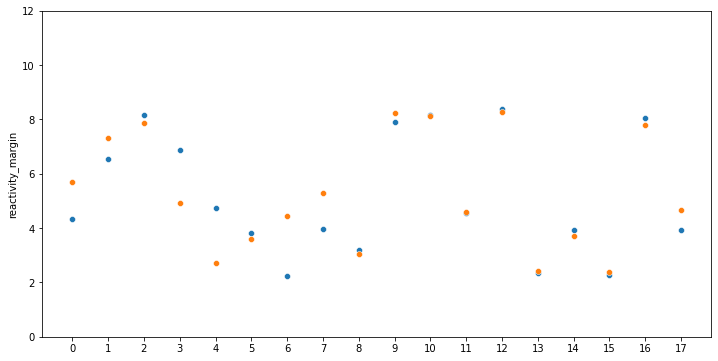

In [434]:
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.scatterplot(x=range(len(y_pred)), y=y_pred_3)
sns.scatterplot(x=range(len(y_pred)), y=y_test3, ax=ax)
ax.set_xticks(range(len(y_pred)))
ax.set_ylim([0,12])

In [435]:
mean_squared_error(y_test3, y_pred_3, squared=False)

1.000232408496428

(0.0, 12.0)

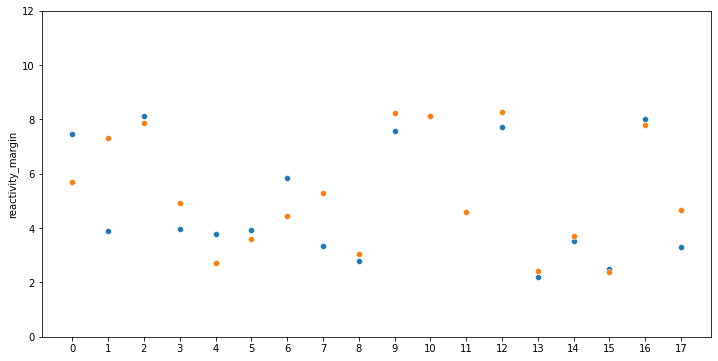

In [410]:
plt.rcParams['figure.figsize'] = (12,6)
y_pred = bst_3.predict(dtest)
ax = sns.scatterplot(x=range(len(y_pred)), y=y_pred)
sns.scatterplot(x=range(len(y_pred)), y=y_test3, ax=ax)
ax.set_xticks(range(len(y_pred)))
ax.set_ylim([0,12])

In [411]:
mean_squared_error(y_test3, y_pred, squared=False)

1.191848127667745

# Вывод

По сравнению с моделями sklearn удалось **снизить** ошибку с **1.39** до **1.05**

# Opuna + Tensorflow

In [298]:
EPOCHS = 500
train_x, valid_x, train_y, valid_y = train_test_split(X_train3, y_train3, test_size=0.2)



train_data = tf.convert_to_tensor(train_x)
train_y = train_y.astype('float32')
# train_label = tf.convert_to_tensor(train_y)
valid_data = tf.convert_to_tensor(valid_x)
valid_y = valid_y.astype('float32')
# valid_label = tf.convert_to_tensor(valid_y)

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_y))
train_ds = train_ds.batch(train_data.shape[1])

valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_y))
valid_ds = valid_ds.batch(train_data.shape[1])

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 2, 4)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(481,)))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 1024, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def learn(model, optimizer, dataset, mode="eval"):
    rmse = tf.keras.metrics.RootMeanSquaredError('rmse', dtype=tf.float32)

    for data, labels in dataset:
        with tf.GradientTape() as tape:
            logits = model(data, training=(mode == "train"))
            logits = tf.reshape(logits, -1)
            loss_value = tf.keras.losses.MeanSquaredError()(logits, labels)
            if mode == "eval":
                rmse(logits, labels)
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    if mode == "eval":
        return rmse


    
def objective(trial, data=data, label=label):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/cpu:0"):
        for _ in range(EPOCHS):
            learn(model, optimizer, train_ds, "train")

        rmse = learn(model, optimizer, valid_ds, "eval")
    return rmse.result()


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=1000)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-12 17:00:25,986] A new study created in memory with name: no-name-929098d9-73b7-4009-b1b0-2b8e417418db
[I 2022-07-12 17:00:34,846] Trial 0 finished with value: 6.032876014709473 and parameters: {'n_layers': 4, 'weight_decay': 7.927364596265828e-09, 'n_units_l0': 176, 'n_units_l1': 168, 'n_units_l2': 15, 'n_units_l3': 5, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.7572593469824984e-05, 'rmsprop_decay': 0.8544361098383572, 'rmsprop_momentum': 0.012350417475451712}. Best is trial 0 with value: 6.032876014709473.
[I 2022-07-12 17:00:41,348] Trial 1 finished with value: 6.030800819396973 and parameters: {'n_layers': 3, 'weight_decay': 5.432290053694486e-05, 'n_units_l0': 11, 'n_units_l1': 93, 'n_units_l2': 15, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.551410108930044e-05, 'rmsprop_decay': 0.9178427379101033, 'rmsprop_momentum': 0.0015517885683157381}. Best is trial 1 with value: 6.030800819396973.
[I 2022-07-12 17:00:47,567] Trial 2 finished with value: 5.42768335

[I 2022-07-12 17:03:03,900] Trial 23 finished with value: 1.7777866125106812 and parameters: {'n_layers': 2, 'weight_decay': 2.4372246693354354e-08, 'n_units_l0': 119, 'n_units_l1': 180, 'optimizer': 'Adam', 'adam_learning_rate': 0.012562023835917396}. Best is trial 20 with value: 1.717506766319275.
[I 2022-07-12 17:03:11,058] Trial 24 finished with value: 1.7627674341201782 and parameters: {'n_layers': 3, 'weight_decay': 2.1343913365812938e-08, 'n_units_l0': 451, 'n_units_l1': 177, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.011674435547837479}. Best is trial 20 with value: 1.717506766319275.
[I 2022-07-12 17:03:18,277] Trial 25 finished with value: 2.029900312423706 and parameters: {'n_layers': 3, 'weight_decay': 1.3303080119268745e-08, 'n_units_l0': 791, 'n_units_l1': 78, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.012589825933480611}. Best is trial 20 with value: 1.717506766319275.
[I 2022-07-12 17:03:25,206] Trial 26 finished with value: 1.68065

[I 2022-07-12 17:05:46,735] Trial 47 finished with value: 6.027401447296143 and parameters: {'n_layers': 4, 'weight_decay': 6.015337044943309e-09, 'n_units_l0': 138, 'n_units_l1': 4, 'n_units_l2': 5, 'n_units_l3': 26, 'optimizer': 'Adam', 'adam_learning_rate': 2.182754683664239e-05}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:05:53,010] Trial 48 finished with value: 2.3058502674102783 and parameters: {'n_layers': 2, 'weight_decay': 2.464432543439759e-09, 'n_units_l0': 216, 'n_units_l1': 95, 'optimizer': 'Adam', 'adam_learning_rate': 0.0005524536495740386}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:05:59,631] Trial 49 finished with value: 1.8208855390548706 and parameters: {'n_layers': 3, 'weight_decay': 2.5810010439792844e-10, 'n_units_l0': 340, 'n_units_l1': 6, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.007298715716619603}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:06:05,965] Trial 50 finished w

[I 2022-07-12 17:09:08,018] Trial 72 finished with value: 1.783753752708435 and parameters: {'n_layers': 3, 'weight_decay': 2.841117310663862e-09, 'n_units_l0': 403, 'n_units_l1': 596, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.015303264974057474}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:09:15,814] Trial 73 finished with value: 2.023576259613037 and parameters: {'n_layers': 3, 'weight_decay': 4.9150958106962655e-09, 'n_units_l0': 579, 'n_units_l1': 396, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.006670892985798556}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:09:22,891] Trial 74 finished with value: 1.704701542854309 and parameters: {'n_layers': 3, 'weight_decay': 7.38711279016376e-10, 'n_units_l0': 798, 'n_units_l1': 18, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.009533137615441426}. Best is trial 26 with value: 1.6806594133377075.
[I 2022-07-12 17:09:29,074] Trial 75 finished wit

[I 2022-07-12 17:11:59,747] Trial 97 finished with value: 1.6690797805786133 and parameters: {'n_layers': 3, 'weight_decay': 5.174582331991502e-09, 'n_units_l0': 139, 'n_units_l1': 114, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.012090764096640765}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:12:06,491] Trial 98 finished with value: 2.520507335662842 and parameters: {'n_layers': 3, 'weight_decay': 1.521547079073453e-08, 'n_units_l0': 146, 'n_units_l1': 105, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.03630765146144773}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:12:13,079] Trial 99 finished with value: 1.7702573537826538 and parameters: {'n_layers': 3, 'weight_decay': 6.472462108312334e-09, 'n_units_l0': 195, 'n_units_l1': 54, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.012894611368702838}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:12:20,041] Trial 100 finished wi

[I 2022-07-12 17:15:01,393] Trial 122 finished with value: 1.684524416923523 and parameters: {'n_layers': 3, 'weight_decay': 1.1627795984566512e-07, 'n_units_l0': 455, 'n_units_l1': 816, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.0024374636294714146}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:15:10,243] Trial 123 finished with value: 1.7928640842437744 and parameters: {'n_layers': 3, 'weight_decay': 1.329771377877172e-07, 'n_units_l0': 676, 'n_units_l1': 806, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.0025354142960495743}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:15:18,445] Trial 124 finished with value: 1.7811400890350342 and parameters: {'n_layers': 3, 'weight_decay': 8.015560099878243e-08, 'n_units_l0': 403, 'n_units_l1': 889, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.0031200613549626005}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:15:27,531] Trial 125 fi

[I 2022-07-12 17:18:16,599] Trial 147 finished with value: 2.520507574081421 and parameters: {'n_layers': 3, 'weight_decay': 1.6054740638539568e-07, 'n_units_l0': 4, 'n_units_l1': 481, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.0068517166604934975}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:18:23,767] Trial 148 finished with value: 1.7008204460144043 and parameters: {'n_layers': 3, 'weight_decay': 9.957159705939073e-08, 'n_units_l0': 366, 'n_units_l1': 351, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.008406956028232548}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:18:30,613] Trial 149 finished with value: 1.6948155164718628 and parameters: {'n_layers': 3, 'weight_decay': 1.8191800439947952e-07, 'n_units_l0': 326, 'n_units_l1': 108, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.008562211943449619}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:18:37,454] Trial 150 finis

[I 2022-07-12 17:21:09,455] Trial 172 finished with value: 1.8222049474716187 and parameters: {'n_layers': 3, 'weight_decay': 1.6035271275358408e-07, 'n_units_l0': 378, 'n_units_l1': 160, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.0058122735790735415}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:21:16,269] Trial 173 finished with value: 1.770632028579712 and parameters: {'n_layers': 3, 'weight_decay': 2.9609907219678183e-07, 'n_units_l0': 285, 'n_units_l1': 136, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.0069621113922501785}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:21:23,480] Trial 174 finished with value: 1.7591001987457275 and parameters: {'n_layers': 3, 'weight_decay': 1.6925025020508755e-10, 'n_units_l0': 402, 'n_units_l1': 102, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.0027886282833943623}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:21:30,365] Trial 175 

[I 2022-07-12 17:24:09,170] Trial 197 finished with value: 1.9815199375152588 and parameters: {'n_layers': 3, 'weight_decay': 2.3086567816760418e-07, 'n_units_l0': 576, 'n_units_l1': 987, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.007027830287674102}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:24:16,257] Trial 198 finished with value: 4.960585117340088 and parameters: {'n_layers': 3, 'weight_decay': 3.803962269660676e-08, 'n_units_l0': 387, 'n_units_l1': 362, 'n_units_l2': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00044995371005765157, 'rmsprop_decay': 0.8763522922127907, 'rmsprop_momentum': 0.031410883263174885}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:24:23,226] Trial 199 finished with value: 2.7440402507781982 and parameters: {'n_layers': 3, 'weight_decay': 4.39150053293248e-09, 'n_units_l0': 328, 'n_units_l1': 148, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.013387419926180323}. Best i

[I 2022-07-12 17:27:07,352] Trial 222 finished with value: 1.7721424102783203 and parameters: {'n_layers': 3, 'weight_decay': 8.747375758528506e-08, 'n_units_l0': 466, 'n_units_l1': 125, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.00731862903621319}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:27:14,182] Trial 223 finished with value: 1.8078587055206299 and parameters: {'n_layers': 3, 'weight_decay': 1.0916975807599715e-08, 'n_units_l0': 342, 'n_units_l1': 104, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.006142171878554799}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:27:21,737] Trial 224 finished with value: 1.7841639518737793 and parameters: {'n_layers': 3, 'weight_decay': 6.63169800042085e-09, 'n_units_l0': 287, 'n_units_l1': 579, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.00480136584172981}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:27:28,546] Trial 225 finishe

[I 2022-07-12 17:30:02,881] Trial 247 finished with value: 1.7188743352890015 and parameters: {'n_layers': 3, 'weight_decay': 8.622087385786832e-08, 'n_units_l0': 280, 'n_units_l1': 72, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.003846720084433375}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:30:09,957] Trial 248 finished with value: 1.6758712530136108 and parameters: {'n_layers': 3, 'weight_decay': 1.265551682945347e-07, 'n_units_l0': 543, 'n_units_l1': 95, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.005203753708153796}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:30:16,228] Trial 249 finished with value: 1.8383333683013916 and parameters: {'n_layers': 3, 'weight_decay': 1.0873866268775723e-07, 'n_units_l0': 5, 'n_units_l1': 86, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.0039004281343657855}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:30:24,915] Trial 250 finished

[I 2022-07-12 17:33:01,928] Trial 272 finished with value: 1.7652184963226318 and parameters: {'n_layers': 3, 'weight_decay': 1.8825726677944364e-08, 'n_units_l0': 527, 'n_units_l1': 110, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.0035294862707667394}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:33:08,781] Trial 273 finished with value: 1.7102795839309692 and parameters: {'n_layers': 3, 'weight_decay': 4.6670140979123e-08, 'n_units_l0': 394, 'n_units_l1': 72, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.014725892769469026}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:33:17,420] Trial 274 finished with value: 1.8644325733184814 and parameters: {'n_layers': 3, 'weight_decay': 1.2873410010138504e-07, 'n_units_l0': 478, 'n_units_l1': 941, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.002892093423932747}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:33:24,302] Trial 275 fini

[I 2022-07-12 17:36:09,102] Trial 297 finished with value: 1.8191182613372803 and parameters: {'n_layers': 3, 'weight_decay': 9.326518816410053e-08, 'n_units_l0': 710, 'n_units_l1': 125, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.006140536953741721}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:36:16,396] Trial 298 finished with value: 1.835700273513794 and parameters: {'n_layers': 3, 'weight_decay': 2.7062815506687935e-07, 'n_units_l0': 517, 'n_units_l1': 103, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.010320156069448755}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:36:23,536] Trial 299 finished with value: 1.7294821739196777 and parameters: {'n_layers': 3, 'weight_decay': 2.7424490538667207e-08, 'n_units_l0': 445, 'n_units_l1': 52, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.002367158858481607}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-12 17:36:30,026] Trial 300 finis

[I 2022-07-13 10:31:44,604] Trial 322 finished with value: 2.0075905323028564 and parameters: {'n_layers': 3, 'weight_decay': 1.6290454358376516e-10, 'n_units_l0': 452, 'n_units_l1': 220, 'n_units_l2': 59, 'optimizer': 'Adam', 'adam_learning_rate': 0.0006689490421479006}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:31:51,453] Trial 323 finished with value: 1.7354159355163574 and parameters: {'n_layers': 3, 'weight_decay': 1.1963831208984756e-07, 'n_units_l0': 45, 'n_units_l1': 416, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.005255762560164279}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:31:59,819] Trial 324 finished with value: 4.505499362945557 and parameters: {'n_layers': 3, 'weight_decay': 4.32191959970891e-08, 'n_units_l0': 351, 'n_units_l1': 858, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.003802282540453204}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:32:06,889] Trial 325 fini

[I 2022-07-13 10:34:58,457] Trial 347 finished with value: 1.763304591178894 and parameters: {'n_layers': 3, 'weight_decay': 2.7750263338449447e-07, 'n_units_l0': 474, 'n_units_l1': 89, 'n_units_l2': 861, 'optimizer': 'Adam', 'adam_learning_rate': 0.0036308158793104304}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:35:08,292] Trial 348 finished with value: 1.7381235361099243 and parameters: {'n_layers': 3, 'weight_decay': 7.917711577235297e-07, 'n_units_l0': 405, 'n_units_l1': 129, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.004655639020914487}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:35:15,939] Trial 349 finished with value: 1.7198621034622192 and parameters: {'n_layers': 3, 'weight_decay': 4.751387088048567e-08, 'n_units_l0': 338, 'n_units_l1': 113, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.005609674473227261}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:35:23,599] Trial 350 fin

[I 2022-07-13 10:38:13,426] Trial 372 finished with value: 1.7999563217163086 and parameters: {'n_layers': 3, 'weight_decay': 3.9711716805781783e-07, 'n_units_l0': 398, 'n_units_l1': 91, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.006278746789965666}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:38:20,669] Trial 373 finished with value: 1.7159076929092407 and parameters: {'n_layers': 3, 'weight_decay': 2.003943861039602e-07, 'n_units_l0': 128, 'n_units_l1': 366, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.004567522289048375}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:38:27,435] Trial 374 finished with value: 1.6926034688949585 and parameters: {'n_layers': 3, 'weight_decay': 6.684784966825328e-08, 'n_units_l0': 338, 'n_units_l1': 150, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.007791853003580645}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:38:34,713] Trial 375 finis

[I 2022-07-13 10:41:30,798] Trial 397 finished with value: 1.7577171325683594 and parameters: {'n_layers': 3, 'weight_decay': 7.74491602494948e-09, 'n_units_l0': 417, 'n_units_l1': 120, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.026359163540059714}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:41:39,172] Trial 398 finished with value: 1.8914943933486938 and parameters: {'n_layers': 3, 'weight_decay': 1.6148685437708675e-07, 'n_units_l0': 699, 'n_units_l1': 483, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.004040642643276444}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:41:46,399] Trial 399 finished with value: 1.7316704988479614 and parameters: {'n_layers': 3, 'weight_decay': 3.2429173348671804e-07, 'n_units_l0': 481, 'n_units_l1': 97, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.0027488593346411934}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:41:55,403] Trial 400 fini

[I 2022-07-13 10:44:37,861] Trial 422 finished with value: 1.8032681941986084 and parameters: {'n_layers': 3, 'weight_decay': 1.7390303480158407e-09, 'n_units_l0': 362, 'n_units_l1': 332, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.005783889808613548}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:44:45,139] Trial 423 finished with value: 5.940682411193848 and parameters: {'n_layers': 3, 'weight_decay': 2.2151731843012537e-07, 'n_units_l0': 768, 'n_units_l1': 129, 'n_units_l2': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 8.522379978484047e-05, 'rmsprop_decay': 0.9053017515052192, 'rmsprop_momentum': 0.00026382292985967465}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:44:52,678] Trial 424 finished with value: 1.7039366960525513 and parameters: {'n_layers': 3, 'weight_decay': 1.5784207442260459e-07, 'n_units_l0': 410, 'n_units_l1': 99, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.003142450376416983}. Bes

[I 2022-07-13 10:47:58,455] Trial 447 finished with value: 2.523513078689575 and parameters: {'n_layers': 3, 'weight_decay': 8.268573372190168e-08, 'n_units_l0': 741, 'n_units_l1': 67, 'n_units_l2': 16, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.006779018147877873, 'rmsprop_decay': 0.8659924103675906, 'rmsprop_momentum': 2.1592804887358873e-05}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:48:05,936] Trial 448 finished with value: 1.9409239292144775 and parameters: {'n_layers': 3, 'weight_decay': 5.274045564838903e-09, 'n_units_l0': 583, 'n_units_l1': 107, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.007058610997152551}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:48:13,018] Trial 449 finished with value: 1.7546169757843018 and parameters: {'n_layers': 3, 'weight_decay': 1.8980125167053642e-10, 'n_units_l0': 434, 'n_units_l1': 125, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.010792457276572973}. Best 

[I 2022-07-13 10:51:00,416] Trial 472 finished with value: 1.7521345615386963 and parameters: {'n_layers': 3, 'weight_decay': 1.7543614362227516e-07, 'n_units_l0': 618, 'n_units_l1': 14, 'n_units_l2': 93, 'optimizer': 'Adam', 'adam_learning_rate': 0.0030584865868946314}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:51:07,342] Trial 473 finished with value: 1.847357988357544 and parameters: {'n_layers': 3, 'weight_decay': 1.4463060321446505e-07, 'n_units_l0': 474, 'n_units_l1': 70, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.005924027129073164}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:51:14,366] Trial 474 finished with value: 1.838010311126709 and parameters: {'n_layers': 3, 'weight_decay': 1.3084420277591262e-10, 'n_units_l0': 532, 'n_units_l1': 84, 'n_units_l2': 11, 'optimizer': 'Adam', 'adam_learning_rate': 0.0023998850752027863}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:51:21,522] Trial 475 fin

[I 2022-07-13 10:53:59,686] Trial 497 finished with value: 1.728033185005188 and parameters: {'n_layers': 3, 'weight_decay': 9.52436512678893e-08, 'n_units_l0': 372, 'n_units_l1': 51, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.00423614784498325}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:54:08,234] Trial 498 finished with value: 1.701991319656372 and parameters: {'n_layers': 3, 'weight_decay': 5.5853863886601063e-08, 'n_units_l0': 463, 'n_units_l1': 57, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.003215611752642484}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:54:16,197] Trial 499 finished with value: 1.8922348022460938 and parameters: {'n_layers': 3, 'weight_decay': 2.1916298488433576e-07, 'n_units_l0': 640, 'n_units_l1': 63, 'n_units_l2': 19, 'optimizer': 'Adam', 'adam_learning_rate': 0.006756240007226166}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:54:23,297] Trial 500 finished

[I 2022-07-13 10:57:07,926] Trial 522 finished with value: 1.7085379362106323 and parameters: {'n_layers': 3, 'weight_decay': 7.332169931193912e-09, 'n_units_l0': 717, 'n_units_l1': 175, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.008129703202359343}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:57:15,620] Trial 523 finished with value: 1.7196760177612305 and parameters: {'n_layers': 3, 'weight_decay': 4.1433721739689866e-09, 'n_units_l0': 611, 'n_units_l1': 9, 'n_units_l2': 15, 'optimizer': 'Adam', 'adam_learning_rate': 0.0053704602063910254}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:57:23,199] Trial 524 finished with value: 1.81181800365448 and parameters: {'n_layers': 4, 'weight_decay': 1.596042128564898e-08, 'n_units_l0': 567, 'n_units_l1': 4, 'n_units_l2': 16, 'n_units_l3': 298, 'optimizer': 'Adam', 'adam_learning_rate': 0.004760558412581881}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 10:57:31,64

[I 2022-07-13 11:00:18,715] Trial 547 finished with value: 1.6981602907180786 and parameters: {'n_layers': 2, 'weight_decay': 0.00018916415303637458, 'n_units_l0': 460, 'n_units_l1': 110, 'optimizer': 'Adam', 'adam_learning_rate': 0.004364765639501261}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:00:25,965] Trial 548 finished with value: 2.5208559036254883 and parameters: {'n_layers': 3, 'weight_decay': 6.065540689208218e-05, 'n_units_l0': 384, 'n_units_l1': 5, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.005135783128454047}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:00:33,534] Trial 549 finished with value: 1.7281782627105713 and parameters: {'n_layers': 3, 'weight_decay': 1.0670480189021189e-08, 'n_units_l0': 515, 'n_units_l1': 99, 'n_units_l2': 12, 'optimizer': 'Adam', 'adam_learning_rate': 0.008581715593931914}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:00:42,472] Trial 550 finished with value: 1

[I 2022-07-13 11:03:57,718] Trial 572 finished with value: 4.767714977264404 and parameters: {'n_layers': 3, 'weight_decay': 1.1976334460405389e-08, 'n_units_l0': 453, 'n_units_l1': 94, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.0030598456878589133}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:04:08,174] Trial 573 finished with value: 1.7264552116394043 and parameters: {'n_layers': 3, 'weight_decay': 1.7385386917399842e-09, 'n_units_l0': 500, 'n_units_l1': 19, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.0059252505585243994}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:04:18,875] Trial 574 finished with value: 1.8203834295272827 and parameters: {'n_layers': 3, 'weight_decay': 5.570467859721909e-08, 'n_units_l0': 430, 'n_units_l1': 102, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.003907846153887953}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:04:31,160] Trial 575 fini

[I 2022-07-13 11:07:25,498] Trial 597 finished with value: 2.497488498687744 and parameters: {'n_layers': 3, 'weight_decay': 1.4952468450944161e-09, 'n_units_l0': 354, 'n_units_l1': 122, 'n_units_l2': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0010449934758017274, 'sgd_opt_momentum': 0.0172985603952068}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:07:32,796] Trial 598 finished with value: 1.7700425386428833 and parameters: {'n_layers': 3, 'weight_decay': 4.514771104668615e-09, 'n_units_l0': 678, 'n_units_l1': 110, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.005186713920256637}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:07:40,987] Trial 599 finished with value: 1.8501724004745483 and parameters: {'n_layers': 3, 'weight_decay': 2.3593853512765322e-09, 'n_units_l0': 308, 'n_units_l1': 140, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.006221216687121769}. Best is trial 93 with value: 1.6573703289031982.

[I 2022-07-13 11:10:45,375] Trial 622 finished with value: 1.7338595390319824 and parameters: {'n_layers': 3, 'weight_decay': 7.51903169837262e-08, 'n_units_l0': 428, 'n_units_l1': 56, 'n_units_l2': 43, 'optimizer': 'Adam', 'adam_learning_rate': 0.010593299722269942}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:10:53,865] Trial 623 finished with value: 1.7458114624023438 and parameters: {'n_layers': 3, 'weight_decay': 1.9942572984455627e-09, 'n_units_l0': 589, 'n_units_l1': 49, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.0028625743407472456}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:11:02,099] Trial 624 finished with value: 1.872012734413147 and parameters: {'n_layers': 3, 'weight_decay': 5.0813362235943876e-08, 'n_units_l0': 491, 'n_units_l1': 87, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.006177501888824667}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:11:10,084] Trial 625 finish

[I 2022-07-13 11:14:12,711] Trial 647 finished with value: 2.008150100708008 and parameters: {'n_layers': 3, 'weight_decay': 5.494731785199616e-09, 'n_units_l0': 520, 'n_units_l1': 8, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.001295387024338608}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:14:21,104] Trial 648 finished with value: 1.7249691486358643 and parameters: {'n_layers': 3, 'weight_decay': 1.9191700563514134e-09, 'n_units_l0': 337, 'n_units_l1': 470, 'n_units_l2': 56, 'optimizer': 'Adam', 'adam_learning_rate': 0.005378647882331715}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:14:27,849] Trial 649 finished with value: 1.837201714515686 and parameters: {'n_layers': 3, 'weight_decay': 4.541430299351594e-09, 'n_units_l0': 37, 'n_units_l1': 663, 'n_units_l2': 11, 'optimizer': 'Adam', 'adam_learning_rate': 0.004228668419318988}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:14:34,155] Trial 650 finishe

[I 2022-07-13 11:18:08,728] Trial 672 finished with value: 2.4875855445861816 and parameters: {'n_layers': 3, 'weight_decay': 6.787785443831385e-10, 'n_units_l0': 9, 'n_units_l1': 4, 'n_units_l2': 170, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.013786454504863882, 'rmsprop_decay': 0.976689498886143, 'rmsprop_momentum': 0.0002614730092078014}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:18:16,078] Trial 673 finished with value: 1.7554447650909424 and parameters: {'n_layers': 3, 'weight_decay': 7.479507466099978e-09, 'n_units_l0': 378, 'n_units_l1': 6, 'n_units_l2': 333, 'optimizer': 'Adam', 'adam_learning_rate': 0.004300889665509191}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:18:23,718] Trial 674 finished with value: 1.8424437046051025 and parameters: {'n_layers': 3, 'weight_decay': 1.632618049518231e-05, 'n_units_l0': 454, 'n_units_l1': 5, 'n_units_l2': 266, 'optimizer': 'Adam', 'adam_learning_rate': 0.0074187312244849484}. Best is 

[I 2022-07-13 11:21:55,655] Trial 697 finished with value: 1.7455642223358154 and parameters: {'n_layers': 3, 'weight_decay': 6.780961526177367e-08, 'n_units_l0': 487, 'n_units_l1': 88, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.00427614984914435}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:22:03,575] Trial 698 finished with value: 1.8261044025421143 and parameters: {'n_layers': 3, 'weight_decay': 4.898796535934756e-09, 'n_units_l0': 49, 'n_units_l1': 100, 'n_units_l2': 153, 'optimizer': 'Adam', 'adam_learning_rate': 0.0034131548614096427}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:22:12,490] Trial 699 finished with value: 1.7498081922531128 and parameters: {'n_layers': 4, 'weight_decay': 4.575715357379095e-06, 'n_units_l0': 538, 'n_units_l1': 117, 'n_units_l2': 9, 'n_units_l3': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.0045730505924068505}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:22:21,9

[I 2022-07-13 11:25:34,849] Trial 722 finished with value: 1.7027125358581543 and parameters: {'n_layers': 3, 'weight_decay': 1.568079178958071e-07, 'n_units_l0': 369, 'n_units_l1': 425, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.0035226201798005405}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:25:41,960] Trial 723 finished with value: 1.7391009330749512 and parameters: {'n_layers': 3, 'weight_decay': 9.525664490916489e-09, 'n_units_l0': 482, 'n_units_l1': 84, 'n_units_l2': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.003994078289119877}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:25:48,811] Trial 724 finished with value: 1.7523504495620728 and parameters: {'n_layers': 3, 'weight_decay': 2.4352937645536536e-09, 'n_units_l0': 210, 'n_units_l1': 140, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.006888242028651597}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:25:56,513] Trial 725 fini

[I 2022-07-13 11:28:55,214] Trial 747 finished with value: 1.7569286823272705 and parameters: {'n_layers': 3, 'weight_decay': 5.3293351327779e-10, 'n_units_l0': 503, 'n_units_l1': 102, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.0033000219801948938}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:29:02,555] Trial 748 finished with value: 1.8459023237228394 and parameters: {'n_layers': 3, 'weight_decay': 1.3315041094387992e-07, 'n_units_l0': 459, 'n_units_l1': 77, 'n_units_l2': 372, 'optimizer': 'Adam', 'adam_learning_rate': 0.006100706349227107}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:29:10,758] Trial 749 finished with value: 1.6851158142089844 and parameters: {'n_layers': 3, 'weight_decay': 1.3136527168519316e-08, 'n_units_l0': 549, 'n_units_l1': 487, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.004447934462078687}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:29:18,052] Trial 750 fin

[I 2022-07-13 11:32:09,989] Trial 772 finished with value: 1.873138189315796 and parameters: {'n_layers': 3, 'weight_decay': 1.4876429501673997e-07, 'n_units_l0': 445, 'n_units_l1': 451, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.004474481701857692}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:32:19,574] Trial 773 finished with value: 1.7358616590499878 and parameters: {'n_layers': 3, 'weight_decay': 1.952419143650247e-08, 'n_units_l0': 769, 'n_units_l1': 671, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.003311515390811429}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:32:27,445] Trial 774 finished with value: 1.7008047103881836 and parameters: {'n_layers': 3, 'weight_decay': 3.2660015233542195e-08, 'n_units_l0': 306, 'n_units_l1': 574, 'n_units_l2': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.005170953691421652}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:32:34,589] Trial 775 fin

[I 2022-07-13 11:36:45,027] Trial 797 finished with value: 1.8061003684997559 and parameters: {'n_layers': 3, 'weight_decay': 1.1723746000547202e-05, 'n_units_l0': 540, 'n_units_l1': 473, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.002302554158601874}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:36:56,291] Trial 798 finished with value: 1.685120940208435 and parameters: {'n_layers': 3, 'weight_decay': 2.6969071705911256e-06, 'n_units_l0': 703, 'n_units_l1': 474, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.003613497600884995}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:37:04,268] Trial 799 finished with value: 5.993525505065918 and parameters: {'n_layers': 3, 'weight_decay': 0.00013583360212360737, 'n_units_l0': 31, 'n_units_l1': 416, 'n_units_l2': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.0100015993482295e-05, 'sgd_opt_momentum': 0.00016806346422719996}. Best is trial 93 with value: 1.657370328903

[I 2022-07-13 11:40:51,513] Trial 822 finished with value: 1.731500506401062 and parameters: {'n_layers': 3, 'weight_decay': 7.766475533081777e-07, 'n_units_l0': 576, 'n_units_l1': 450, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.007451381904829068}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:41:00,204] Trial 823 finished with value: 2.0148212909698486 and parameters: {'n_layers': 3, 'weight_decay': 2.791202925924794e-07, 'n_units_l0': 83, 'n_units_l1': 283, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.009890466163117789}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:41:10,010] Trial 824 finished with value: 2.508294105529785 and parameters: {'n_layers': 3, 'weight_decay': 3.9885521432521233e-07, 'n_units_l0': 672, 'n_units_l1': 406, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.00013355893440337017}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:41:20,013] Trial 825 finis

[I 2022-07-13 11:44:50,881] Trial 847 finished with value: 1.8014745712280273 and parameters: {'n_layers': 4, 'weight_decay': 9.526967857753862e-08, 'n_units_l0': 522, 'n_units_l1': 483, 'n_units_l2': 11, 'n_units_l3': 5, 'optimizer': 'Adam', 'adam_learning_rate': 0.0031701724537492987}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:44:59,208] Trial 848 finished with value: 1.7598531246185303 and parameters: {'n_layers': 3, 'weight_decay': 2.019873352881851e-06, 'n_units_l0': 650, 'n_units_l1': 431, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.002130180276820705}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:45:06,178] Trial 849 finished with value: 1.9500492811203003 and parameters: {'n_layers': 3, 'weight_decay': 4.422674187889615e-07, 'n_units_l0': 89, 'n_units_l1': 78, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.005776190107215478}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:45:13,47

[I 2022-07-13 11:48:53,268] Trial 872 finished with value: 1.7844573259353638 and parameters: {'n_layers': 3, 'weight_decay': 2.735114344621855e-09, 'n_units_l0': 462, 'n_units_l1': 81, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.005986789239276605}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:49:08,565] Trial 873 finished with value: 1.740625262260437 and parameters: {'n_layers': 3, 'weight_decay': 4.477081578704747e-08, 'n_units_l0': 420, 'n_units_l1': 543, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.004334674932892809}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:49:20,844] Trial 874 finished with value: 2.542923927307129 and parameters: {'n_layers': 3, 'weight_decay': 1.2028181287907999e-07, 'n_units_l0': 738, 'n_units_l1': 6, 'n_units_l2': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.0028515166606793026}. Best is trial 93 with value: 1.6573703289031982.
[I 2022-07-13 11:49:32,865] Trial 875 finished

[I 2022-07-13 11:52:24,299] Trial 897 finished with value: 5.863680362701416 and parameters: {'n_layers': 3, 'weight_decay': 1.0369571850621385e-06, 'n_units_l0': 337, 'n_units_l1': 80, 'n_units_l2': 11, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0001450317598366524, 'rmsprop_decay': 0.8728000883127506, 'rmsprop_momentum': 6.235963405120767e-05}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:52:32,325] Trial 898 finished with value: 2.288518190383911 and parameters: {'n_layers': 3, 'weight_decay': 5.72288058612594e-07, 'n_units_l0': 312, 'n_units_l1': 74, 'n_units_l2': 14, 'optimizer': 'Adam', 'adam_learning_rate': 0.02154797848657652}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:52:40,084] Trial 899 finished with value: 1.9056425094604492 and parameters: {'n_layers': 3, 'weight_decay': 6.797295417662839e-07, 'n_units_l0': 335, 'n_units_l1': 84, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.016575072489764243}. Best is 

[I 2022-07-13 11:55:45,188] Trial 922 finished with value: 1.8614580631256104 and parameters: {'n_layers': 3, 'weight_decay': 4.471299130010793e-07, 'n_units_l0': 203, 'n_units_l1': 59, 'n_units_l2': 15, 'optimizer': 'Adam', 'adam_learning_rate': 0.01323465923326372}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:55:52,388] Trial 923 finished with value: 1.7641278505325317 and parameters: {'n_layers': 3, 'weight_decay': 5.537782587474099e-07, 'n_units_l0': 252, 'n_units_l1': 58, 'n_units_l2': 14, 'optimizer': 'Adam', 'adam_learning_rate': 0.01581764591464201}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:55:59,560] Trial 924 finished with value: 1.7001763582229614 and parameters: {'n_layers': 3, 'weight_decay': 8.96927466461509e-07, 'n_units_l0': 222, 'n_units_l1': 64, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.018457494450131316}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:56:06,833] Trial 925 finished

[I 2022-07-13 11:58:53,716] Trial 947 finished with value: 1.7719697952270508 and parameters: {'n_layers': 3, 'weight_decay': 8.007788953722076e-07, 'n_units_l0': 211, 'n_units_l1': 45, 'n_units_l2': 16, 'optimizer': 'Adam', 'adam_learning_rate': 0.015514337182863979}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:59:00,964] Trial 948 finished with value: 1.9007397890090942 and parameters: {'n_layers': 2, 'weight_decay': 1.586893344274515e-06, 'n_units_l0': 263, 'n_units_l1': 59, 'optimizer': 'Adam', 'adam_learning_rate': 0.021802595820621315}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:59:08,819] Trial 949 finished with value: 1.7313709259033203 and parameters: {'n_layers': 3, 'weight_decay': 9.093282716090463e-07, 'n_units_l0': 250, 'n_units_l1': 68, 'n_units_l2': 13, 'optimizer': 'Adam', 'adam_learning_rate': 0.013198454064065807}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 11:59:15,995] Trial 950 finished with value: 1.

[I 2022-07-13 12:01:58,905] Trial 972 finished with value: 1.8147165775299072 and parameters: {'n_layers': 3, 'weight_decay': 4.491570105135274e-07, 'n_units_l0': 188, 'n_units_l1': 93, 'n_units_l2': 15, 'optimizer': 'Adam', 'adam_learning_rate': 0.017295114695383466}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 12:02:06,506] Trial 973 finished with value: 1.6982712745666504 and parameters: {'n_layers': 3, 'weight_decay': 7.447242188652719e-07, 'n_units_l0': 343, 'n_units_l1': 112, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.00864482351902219}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 12:02:18,897] Trial 974 finished with value: 2.520563840866089 and parameters: {'n_layers': 3, 'weight_decay': 5.690828978342206e-07, 'n_units_l0': 262, 'n_units_l1': 1023, 'n_units_l2': 905, 'optimizer': 'Adam', 'adam_learning_rate': 0.012671403135737249}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 12:02:26,990] Trial 975 fini

[I 2022-07-13 12:05:14,027] Trial 997 finished with value: 1.8077539205551147 and parameters: {'n_layers': 3, 'weight_decay': 2.3866955737672576e-09, 'n_units_l0': 368, 'n_units_l1': 41, 'n_units_l2': 10, 'optimizer': 'Adam', 'adam_learning_rate': 0.012851808354203952}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 12:05:21,507] Trial 998 finished with value: 1.8777457475662231 and parameters: {'n_layers': 4, 'weight_decay': 2.297129779735647e-06, 'n_units_l0': 311, 'n_units_l1': 85, 'n_units_l2': 12, 'n_units_l3': 69, 'optimizer': 'Adam', 'adam_learning_rate': 0.01531677632616317}. Best is trial 892 with value: 1.628906011581421.
[I 2022-07-13 12:05:28,686] Trial 999 finished with value: 1.8769328594207764 and parameters: {'n_layers': 3, 'weight_decay': 1.3304019391510073e-06, 'n_units_l0': 283, 'n_units_l1': 98, 'n_units_l2': 20, 'optimizer': 'Adam', 'adam_learning_rate': 0.007703156460360417}. Best is trial 892 with value: 1.628906011581421.


Number of finished trials:  1000
Best trial:
  Value:  1.628906011581421
  Params: 
    n_layers: 3
    weight_decay: 8.563265606308234e-07
    n_units_l0: 312
    n_units_l1: 88
    n_units_l2: 10
    optimizer: Adam
    adam_learning_rate: 0.018889654679544142


In [304]:

weight_decay = 8.563265606308234e-07
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(481, ), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(312, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))

model.compile(optimizer='adam',
              loss = tf.keras.losses.MeanSquaredError())
model.summary()


Model: "sequential_1212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5856 (Dense)          (None, 512)               246784    
                                                                 
 dense_5857 (Dense)          (None, 312)               160056    
                                                                 
 dense_5858 (Dense)          (None, 100)               31300     
                                                                 
 dense_5859 (Dense)          (None, 10)                1010      
                                                                 
 dense_5860 (Dense)          (None, 1)                 11        
                                                                 
Total params: 439,161
Trainable params: 439,161
Non-trainable params: 0
_________________________________________________________________


In [311]:
model.fit(X_train3, y_train3, epochs=1500, verbose=1)

Epoch 1/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6122
Epoch 2/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6425
Epoch 3/1500
3/3 [==============================] - 0s 12ms/step - loss: 1.6182
Epoch 4/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6322
Epoch 5/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6703
Epoch 6/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6070
Epoch 7/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6785
Epoch 8/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5994
Epoch 9/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6358
Epoch 10/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6752
Epoch 11/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6701
Epoch 12/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.8121
Epoch 13/1500
3/3 [=============================

3/3 [==============================] - 0s 6ms/step - loss: 1.6000
Epoch 104/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6671
Epoch 105/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5969
Epoch 106/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6004
Epoch 107/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6123
Epoch 108/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6058
Epoch 109/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6188
Epoch 110/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.5807
Epoch 111/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6452
Epoch 112/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6687
Epoch 113/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.5920
Epoch 114/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6440
Epoch 115/1500
3/3 [=======================

3/3 [==============================] - 0s 5ms/step - loss: 1.6178
Epoch 205/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6090
Epoch 206/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5902
Epoch 207/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6467
Epoch 208/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7039
Epoch 209/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5873
Epoch 210/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6208
Epoch 211/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6078
Epoch 212/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6900
Epoch 213/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6606
Epoch 214/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.5786
Epoch 215/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6448
Epoch 216/1500
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 1.6006
Epoch 306/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7167
Epoch 307/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7417
Epoch 308/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6881
Epoch 309/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6718
Epoch 310/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6314
Epoch 311/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6083
Epoch 312/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6973
Epoch 313/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6667
Epoch 314/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6036
Epoch 315/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.7935
Epoch 316/1500
3/3 [==============================] - 0s 2ms/step - loss: 1.6375
Epoch 317/1500
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 1.6090
Epoch 407/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6633
Epoch 408/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7507
Epoch 409/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6282
Epoch 410/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5982
Epoch 411/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.7021
Epoch 412/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6625
Epoch 413/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6047
Epoch 414/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6558
Epoch 415/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6017
Epoch 416/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6318
Epoch 417/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.7068
Epoch 418/1500
3/3 [=======================

3/3 [==============================] - 0s 6ms/step - loss: 1.6322
Epoch 508/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6450
Epoch 509/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7605
Epoch 510/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7703
Epoch 511/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6447
Epoch 512/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.8041
Epoch 513/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6839
Epoch 514/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6677
Epoch 515/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6067
Epoch 516/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6530
Epoch 517/1500
3/3 [==============================] - 0s 9ms/step - loss: 1.6433
Epoch 518/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7397
Epoch 519/1500
3/3 [=======================

3/3 [==============================] - 0s 6ms/step - loss: 1.6482
Epoch 609/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6571
Epoch 610/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5938
Epoch 611/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6350
Epoch 612/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6085
Epoch 613/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5926
Epoch 614/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6090
Epoch 615/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6429
Epoch 616/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6088
Epoch 617/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6055
Epoch 618/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6811
Epoch 619/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7630
Epoch 620/1500
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 1.6282
Epoch 710/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7834
Epoch 711/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7988
Epoch 712/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7382
Epoch 713/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7832
Epoch 714/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6530
Epoch 715/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.8206
Epoch 716/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6190
Epoch 717/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6940
Epoch 718/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6126
Epoch 719/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6846
Epoch 720/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6238
Epoch 721/1500
3/3 [=======================

3/3 [==============================] - 0s 6ms/step - loss: 1.7550
Epoch 811/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6289
Epoch 812/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6013
Epoch 813/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6782
Epoch 814/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5752
Epoch 815/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.7424
Epoch 816/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6235
Epoch 817/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.8190
Epoch 818/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5864
Epoch 819/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6471
Epoch 820/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.5991
Epoch 821/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.9009
Epoch 822/1500
3/3 [=======================

3/3 [==============================] - 0s 6ms/step - loss: 1.5954
Epoch 912/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5883
Epoch 913/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6442
Epoch 914/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6810
Epoch 915/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6427
Epoch 916/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6768
Epoch 917/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.5986
Epoch 918/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5843
Epoch 919/1500
3/3 [==============================] - 0s 0s/step - loss: 1.7019
Epoch 920/1500
3/3 [==============================] - 0s 0s/step - loss: 1.6047
Epoch 921/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6534
Epoch 922/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.8208
Epoch 923/1500
3/3 [=========================

3/3 [==============================] - 0s 5ms/step - loss: 1.7418
Epoch 1013/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7656
Epoch 1014/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.7627
Epoch 1015/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7731
Epoch 1016/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6333
Epoch 1017/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6007
Epoch 1018/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.9683
Epoch 1019/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.8375
Epoch 1020/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6862
Epoch 1021/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6087
Epoch 1022/1500
3/3 [==============================] - 0s 2ms/step - loss: 1.6650
Epoch 1023/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6095
Epoch 1024/1500
3/3 [===========

3/3 [==============================] - 0s 7ms/step - loss: 1.7675
Epoch 1113/1500
3/3 [==============================] - 0s 11ms/step - loss: 1.6052
Epoch 1114/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.5848
Epoch 1115/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6353
Epoch 1116/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.7559
Epoch 1117/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5947
Epoch 1118/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.8990
Epoch 1119/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6671
Epoch 1120/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.8412
Epoch 1121/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6694
Epoch 1122/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5962
Epoch 1123/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6903
Epoch 1124/1500
3/3 [==========

3/3 [==============================] - 0s 7ms/step - loss: 1.7317
Epoch 1213/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.8286
Epoch 1214/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.8293
Epoch 1215/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6478
Epoch 1216/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6905
Epoch 1217/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.6932
Epoch 1218/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7436
Epoch 1219/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6675
Epoch 1220/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.9010
Epoch 1221/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6325
Epoch 1222/1500
3/3 [==============================] - 0s 5ms/step - loss: 1.8991
Epoch 1223/1500
3/3 [==============================] - 0s 9ms/step - loss: 1.6750
Epoch 1224/1500
3/3 [===========

3/3 [==============================] - 0s 7ms/step - loss: 1.6622
Epoch 1313/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.5952
Epoch 1314/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6556
Epoch 1315/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5927
Epoch 1316/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6772
Epoch 1317/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6074
Epoch 1318/1500
3/3 [==============================] - 0s 8ms/step - loss: 1.6496
Epoch 1319/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6139
Epoch 1320/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6652
Epoch 1321/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.5939
Epoch 1322/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5852
Epoch 1323/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.5901
Epoch 1324/1500
3/3 [===========

3/3 [==============================] - 0s 7ms/step - loss: 1.6526
Epoch 1413/1500
3/3 [==============================] - 0s 7ms/step - loss: 1.6454
Epoch 1414/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5747
Epoch 1415/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.7013
Epoch 1416/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6261
Epoch 1417/1500
3/3 [==============================] - 0s 4ms/step - loss: 1.6668
Epoch 1418/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.7416
Epoch 1419/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.6355
Epoch 1420/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.9737
Epoch 1421/1500
3/3 [==============================] - 0s 6ms/step - loss: 1.5371
Epoch 1422/1500
3/3 [==============================] - 0s 4ms/step - loss: 2.0748
Epoch 1423/1500
3/3 [==============================] - 0s 3ms/step - loss: 1.6075
Epoch 1424/1500
3/3 [===========

1/1 [==============================] - 0s 31ms/step


(0.0, 12.0)

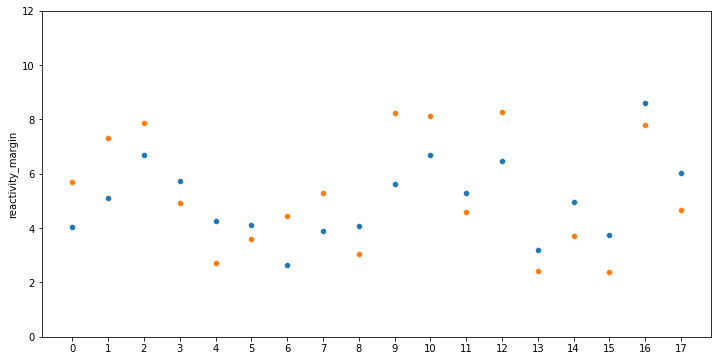

In [321]:
plt.rcParams['figure.figsize'] = (12,6)
y_pred = model.predict(X_test3)
ax = sns.scatterplot(x=range(len(y_test3)), y=y_pred.reshape(-1))
sns.scatterplot(x=range(len(y_test3)), y=y_test3, ax=ax)
ax.set_xticks(range(len(y_pred)))
ax.set_ylim([0,12])

In [322]:
mean_squared_error(y_test3, y_pred, squared=False)

1.4470782902013894

# Общие выводы
В целом погрешность, обеспечиваемая xgboost и нейросетью вполне приемлима, учитывая небольшой объем обучающих данных, а также варьирование стержней в верхнем положении, что может приводить к изменению запаса на +-0.5%, а также отравление бериллиевого отражателя, которое не учитывается, хотя может влиять на запас до 2-х %, при длительной стоянке реактора. Последним путем повышения точности стоит попробовать вручную учесть физический "вес" ампульного устройства в отражателе, поскольку он меняет запас на практически одну и ту же величину вне зависимости от загрузки, которая составляет 1.8.

In [333]:
df_avg_conc['reactivity_margin'] = target2
df_avg_conc['reactivity_margin'] = df_avg_conc['reactivity_margin'].where(df_avg_conc.ampule==0, df_avg_conc['reactivity_margin'] - 1.8)
target_4 = df_avg_conc.pop('reactivity_margin')
df_avg_conc.drop(columns=['ampule'], inplace=True)
df_avg_conc

,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46523_to_46882_for_sm49,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49
0,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
1,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
2,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
3,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
4,0.001120,0.001135,0.001143,0.001147,0.001144,0.001133,0.001621,0.001634,0.001642,0.001645,...,2.723002e-07,2.719446e-07,2.729689e-07,2.762814e-07,2.044777e-07,2.043944e-07,2.045678e-07,2.049895e-07,2.058990e-07,2.074468e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001731,0.001722,0.001673,0.001698,0.001716,0.001658,0.001204,0.001213,0.001184,0.001196,...,1.744768e-07,1.783566e-07,1.800168e-07,1.748016e-07,2.180973e-07,2.163685e-07,2.088396e-07,2.135990e-07,2.138828e-07,2.135722e-07
86,0.001715,0.001707,0.001659,0.001683,0.001701,0.001643,0.001193,0.001202,0.001174,0.001185,...,1.161421e-07,1.186566e-07,1.191609e-07,1.144789e-07,1.565044e-07,1.568710e-07,1.521704e-07,1.559188e-07,1.555900e-07,1.537947e-07
87,0.001687,0.001680,0.001633,0.001657,0.001674,0.001617,0.001174,0.001184,0.001156,0.001166,...,1.221652e-07,1.249094e-07,1.258932e-07,1.217462e-07,1.599630e-07,1.594996e-07,1.543420e-07,1.579889e-07,1.578659e-07,1.567750e-07
88,0.001602,0.001598,0.001555,0.001579,0.001594,0.001537,0.001116,0.001126,0.001099,0.001109,...,2.226987e-07,2.278143e-07,2.309709e-07,2.263424e-07,2.657612e-07,2.612477e-07,2.510024e-07,2.562330e-07,2.571179e-07,2.585452e-07


In [353]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_avg_conc, target_4, test_size=0.25, random_state=7)

In [354]:
def objective(trial, data=X_train4, label=y_train4):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 5000, 30000, step=5000),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": trial.suggest_categorical("tree_method",["approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 10.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 10.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-13 15:51:14,524] A new study created in memory with name: no-name-63087865-ce3b-4ef7-b745-eb5efca9ad13
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2022-07-13 15:51:14,624] Trial 0 finished with value: 2.242515605964044 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.01197954912316917, 'alpha': 7.76857809734545e-08, 'subsample': 0.34524215295872773, 'colsample_bytree': 0.8383349387722752}. Best is trial 0 with value: 2.242515605964044.
[I 2022-07-13 15:51:14,665] Trial 1 finished with value: 3.823508391284779 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.5551077935880495, 'alpha': 0.28986662323849893, 'subsample': 0.7588287488889531, 'colsample_bytree': 0.5426233073432032, 'max_depth': 11, 'm

[I 2022-07-13 15:51:15,416] Trial 16 finished with value: 3.504477945305841 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0010018586988800222, 'alpha': 0.2945322988642118, 'subsample': 0.4940076156490244, 'colsample_bytree': 0.7008428032468431, 'max_depth': 16, 'min_child_weight': 9, 'eta': 0.005407820197116594, 'gamma': 5.9353230013832905e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.235946210078514e-07, 'skip_drop': 0.5352069209954557}. Best is trial 3 with value: 1.3486423638088554.
[I 2022-07-13 15:51:15,436] Trial 17 finished with value: 3.199595788768448 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.4598572785485767, 'alpha': 0.4187081785535158, 'subsample': 0.5130142500276413, 'colsample_bytree': 0.7103268578916383, 'max_depth': 16, 'min_child_weight': 10, 'eta': 0.006414372920434191, 'gamma': 8.230180933141674e-06, 'grow_policy': 

[I 2022-07-13 15:51:16,432] Trial 34 finished with value: 2.347030448576429 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.08833259637466145, 'alpha': 3.292845447646271e-05, 'subsample': 0.6903598909630505, 'colsample_bytree': 0.9228768459500419}. Best is trial 3 with value: 1.3486423638088554.
[I 2022-07-13 15:51:16,486] Trial 35 finished with value: 2.6542593849202034 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 3.6686312110888917, 'alpha': 2.2726786915665032e-07, 'subsample': 0.7077111145922169, 'colsample_bytree': 0.4941441457960675}. Best is trial 3 with value: 1.3486423638088554.
[I 2022-07-13 15:51:16,518] Trial 36 finished with value: 2.561525989894534 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 5.216206115859454, 'alpha': 3.083782899175789e-07, 'subsample': 0.7464391952414863, 'colsample_bytree': 0.4985699853955262}. Best is tri

[I 2022-07-13 15:51:17,711] Trial 53 finished with value: 2.9901666228356256 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.570428951802975e-07, 'alpha': 8.750488342052005, 'subsample': 0.5747885661028327, 'colsample_bytree': 0.6759610658288913, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.03130533831746951, 'gamma': 0.00021685342516874, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.3486423638088554.
[I 2022-07-13 15:51:17,752] Trial 54 finished with value: 1027.0050828267472 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.310317851214398e-07, 'alpha': 6.199279876662371, 'subsample': 0.5516643613350347, 'colsample_bytree': 0.6839991954258414, 'max_depth': 8, 'min_child_weight': 2, 'eta': 2.7234101590634383, 'gamma': 0.00021872844242528365, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.3486423638088554.
[I 2022-07-13 15:51:17,877] Trial 55 finished with value: 21262.37

[I 2022-07-13 15:51:18,907] Trial 69 finished with value: 1.2510443943411387 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0016738829095299349, 'alpha': 3.27626693987991, 'subsample': 0.9908514697010643, 'colsample_bytree': 0.9596070520768198, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.4300654288877685, 'gamma': 0.0006125823508672832, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 1.2510443943411387.
[I 2022-07-13 15:51:18,917] Trial 70 finished with value: 2.2711664711639443 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.0751796618492135, 'alpha': 3.1768250531207314, 'subsample': 0.9679500069064408, 'colsample_bytree': 0.9591150657293628, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.06141982682888796, 'gamma': 9.411876868601757e-06, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 1.2510443943411387.
[I 2022-07-13 15:51:19,050] Trial 71 finished with value: 3.1658

[I 2022-07-13 15:51:20,124] Trial 85 finished with value: 1.9449631851714582 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00032254457336472497, 'alpha': 0.12075620015341432, 'subsample': 0.923431442296867, 'colsample_bytree': 0.9691024579456653, 'max_depth': 10, 'min_child_weight': 10, 'eta': 1.6480822412957117, 'gamma': 0.008594758096445037, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.13940588305596324, 'skip_drop': 0.04936501661347376}. Best is trial 69 with value: 1.2510443943411387.
[I 2022-07-13 15:51:20,155] Trial 86 finished with value: 1.3961401778092504 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.005264727750901295, 'alpha': 0.02918161325690775, 'subsample': 0.9236742260585709, 'colsample_bytree': 0.9768149353119269, 'max_depth': 10, 'min_child_weight': 10, 'eta': 1.5543466930549545, 'gamma': 0.17338520566916304, 'grow_policy': 'loss

[I 2022-07-13 15:51:21,181] Trial 100 finished with value: 1.764186720472406 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0010105628188843286, 'alpha': 0.013837022530115787, 'subsample': 0.9144053937631221, 'colsample_bytree': 0.9150090117623761, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.3882470276495774, 'gamma': 0.0001382434951740349, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0796807747771183e-05, 'skip_drop': 0.10428549497103726}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:21,280] Trial 102 finished with value: 19450.818166956687 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.937175240206303e-05, 'alpha': 0.009315658807135568, 'subsample': 0.8155291648118569, 'colsample_bytree': 0.8570445082714772, 'max_depth': 13, 'min_child_weight': 6, 'eta': 3.381514936776105, 'gamma': 0.7182247020669853, 'grow_policy': 

[I 2022-07-13 15:51:22,358] Trial 117 finished with value: 2.402009872951507 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0020739970647894335, 'alpha': 0.0030811201816461345, 'subsample': 0.9802304532871172, 'colsample_bytree': 0.9758875801410541, 'max_depth': 14, 'min_child_weight': 8, 'eta': 0.7268946083312396, 'gamma': 0.054357099768171366, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:22,403] Trial 118 finished with value: 2.0287423247834355 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0024783865219175504, 'alpha': 0.018949552980835165, 'subsample': 0.9822254177830959, 'colsample_bytree': 0.9135394578499936, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.9418494602752991, 'gamma': 0.047237999700792524, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:22,524] Trial 119 finished with valu

[I 2022-07-13 15:51:23,729] Trial 135 finished with value: 1.7541365342001862 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.004168887901504998, 'alpha': 0.012300063504501848, 'subsample': 0.8901613441617536, 'colsample_bytree': 0.9150059462119301, 'max_depth': 15, 'min_child_weight': 8, 'eta': 1.2293205925673731, 'gamma': 0.17415473108230597, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:23,791] Trial 136 finished with value: 1.8355634432763492 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.004028913883944532, 'alpha': 1.2474825275064863e-06, 'subsample': 0.9246356599841528, 'colsample_bytree': 0.9364994153493635, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.3507093126670424, 'gamma': 2.747840645327803e-05, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:23,827] Trial 137 finished with value

[I 2022-07-13 15:51:25,064] Trial 153 finished with value: 1.6171151853357324 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.002565607524510169, 'alpha': 0.014229992785725181, 'subsample': 0.9782530431464833, 'colsample_bytree': 0.8444275341778876, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.23303931542156817, 'gamma': 0.3892236386814961, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:25,115] Trial 154 finished with value: 2.053450482802393 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00041940615585866125, 'alpha': 0.009809020237839269, 'subsample': 0.9708795864136961, 'colsample_bytree': 0.8381207368227409, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.23468156137279905, 'gamma': 0.3891427818590747, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:25,162] Trial 155 finished with value: 2

[I 2022-07-13 15:51:26,323] Trial 170 finished with value: 1.504672502072711 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.011063641939317548, 'alpha': 5.21024480613904, 'subsample': 0.9115041020207998, 'colsample_bytree': 0.8220273552633938, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.47659925012945586, 'gamma': 3.490346051447171e-05, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:26,378] Trial 171 finished with value: 2.0673279435575505 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004026641108766891, 'alpha': 0.0006455975753430716, 'subsample': 0.9575392409504425, 'colsample_bytree': 0.9035700239283578, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.39756092410296706, 'gamma': 0.019468846286102244, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:26,438] Trial 172 finished with value

[I 2022-07-13 15:51:27,619] Trial 187 finished with value: 1.5961036964713275 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.003256080774136393, 'alpha': 0.003188613284313772, 'subsample': 0.9068892921168487, 'colsample_bytree': 0.5553538925620656, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.3387040796771381, 'gamma': 0.003647310970233293, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:27,635] Trial 188 finished with value: 1.4234179125781021 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.003108597887284339, 'alpha': 0.0029806988346097155, 'subsample': 0.9651420513630027, 'colsample_bytree': 0.8997953897059974, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.32241048376621095, 'gamma': 0.004266757341264248, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:27,735] Trial 189 finished with value:

[I 2022-07-13 15:51:28,860] Trial 204 finished with value: 1.5525124033000606 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0019279825838052498, 'alpha': 0.0003078154011053244, 'subsample': 0.9865902235715105, 'colsample_bytree': 0.8901555002948326, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.45021126619211116, 'gamma': 0.03115185735250041, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:29,024] Trial 205 finished with value: 1.4310537720122776 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.010951811697708161, 'alpha': 0.0016676413209180572, 'subsample': 0.9810348863506342, 'colsample_bytree': 0.862100146039868, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.5788255965431457, 'gamma': 0.016446214696953124, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:29,024] Trial 206 finished with va

[I 2022-07-13 15:51:30,176] Trial 222 finished with value: 1.5471160259005725 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0007261506673232557, 'alpha': 0.011222833264714217, 'subsample': 0.8796188879781393, 'colsample_bytree': 0.8476344665594183, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.21663278940307346, 'gamma': 0.19030425661340972, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:30,316] Trial 223 finished with value: 1.6138798866266706 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0015950469947383446, 'alpha': 0.00018531997825768423, 'subsample': 0.6890398676065185, 'colsample_bytree': 0.8940805247699414, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.44959269519728484, 'gamma': 0.10360010680347409, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:30,403] Trial 224 finished with v

[I 2022-07-13 15:51:31,636] Trial 239 finished with value: 1.870863219881966 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.006293147339359493, 'alpha': 0.09213487706680099, 'subsample': 0.9586851806800181, 'colsample_bytree': 0.895586785681939, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.28604520182078985, 'gamma': 0.0002474270621798363, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:31,851] Trial 240 finished with value: 1.2993520478154315 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0044039262355803615, 'alpha': 0.03901058968157987, 'subsample': 0.9560190009466749, 'colsample_bytree': 0.8688833714275498, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.1594472563240156, 'gamma': 8.978588511598988e-05, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:31,897] Trial 241 finished with valu

[I 2022-07-13 15:51:33,156] Trial 256 finished with value: 1.8401778636915707 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.589819531345358e-05, 'alpha': 6.230922099349883e-05, 'subsample': 0.9216589477404212, 'colsample_bytree': 0.8844997961716063, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.14263311836356132, 'gamma': 4.119709024621975e-05, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:33,291] Trial 257 finished with value: 1.5276396204608138 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.008920954380989844, 'alpha': 0.12637053849765453, 'subsample': 0.9303201974228694, 'colsample_bytree': 0.9254231976234013, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.14715852534125182, 'gamma': 8.087645777699405e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.6788140030977883e-06, 'skip_drop': 1

[I 2022-07-13 15:51:34,672] Trial 274 finished with value: 1.3399401899316488 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0084731269277414, 'alpha': 0.05220871475315686, 'subsample': 0.9676142655960986, 'colsample_bytree': 0.8714668743801937, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.5387945849077725, 'gamma': 0.7835886877505145, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:34,693] Trial 273 finished with value: 3.1539449439446994 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.007746199467192656, 'alpha': 0.005947487356829447, 'subsample': 0.9658252185224119, 'colsample_bytree': 0.8692497885026743, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.046422253892556165, 'gamma': 0.5880222217980899, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:34,833] Trial 275 finished with value: 1.

[I 2022-07-13 15:51:35,945] Trial 290 finished with value: 1.0427628901925374 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0002065176567895433, 'alpha': 0.0025224757647336485, 'subsample': 0.5625088516469614, 'colsample_bytree': 0.9296015102536915, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.4111516179378032, 'gamma': 0.0026631560330868656, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:36,118] Trial 291 finished with value: 1.2524211783940216 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0003080337775753234, 'alpha': 0.0013530833491445628, 'subsample': 0.6325305249658687, 'colsample_bytree': 0.967346383359558, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.25353585280711766, 'gamma': 0.0058384661247889305, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:36,118] Trial 292 finished with 

[I 2022-07-13 15:51:37,305] Trial 307 finished with value: 1.7035494242786675 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.07903964079375336, 'alpha': 2.9380820889340892e-08, 'subsample': 0.5694415145295822, 'colsample_bytree': 0.9134224949055746, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.5466027312865339, 'gamma': 0.0005626291205379135, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:37,355] Trial 308 finished with value: 1.5975087206612606 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008747768788776533, 'alpha': 0.003103299348548781, 'subsample': 0.9698232840485852, 'colsample_bytree': 0.909894053620736, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.5150992831344041, 'gamma': 0.0003981837515742586, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:37,469] Trial 309 finished with v

[I 2022-07-13 15:51:38,690] Trial 324 finished with value: 2.265607422120568 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00018382314161178803, 'alpha': 2.8833669415335033, 'subsample': 0.9831804548517231, 'colsample_bytree': 0.9858859940113066, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.06701514893621228, 'gamma': 0.00030809282843455223, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:38,817] Trial 325 finished with value: 1.292733635047391 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.010669779040558621, 'alpha': 0.04454908398033865, 'subsample': 0.9282561846606572, 'colsample_bytree': 0.3990034052791716, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.410941715675824, 'gamma': 0.038163214558732325, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:38,905] Trial 326 finished with val

[I 2022-07-13 15:51:40,325] Trial 342 finished with value: 3771.1074469131236 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.010954776071437956, 'alpha': 9.738367901274571e-05, 'subsample': 0.9474395904204936, 'colsample_bytree': 0.9461279734160888, 'max_depth': 15, 'min_child_weight': 8, 'eta': 3.016091470739954, 'gamma': 0.0011744491388490693, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:40,418] Trial 343 finished with value: 1.9041383462665604 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.016967084592136e-05, 'alpha': 0.0016375254617471532, 'subsample': 0.9482736574741553, 'colsample_bytree': 0.9949244343072811, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.7167830291116807, 'gamma': 0.001299186723403826, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:40,455] Trial 344 finished with

[I 2022-07-13 15:51:41,906] Trial 359 finished with value: 2.0349377647502993 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00027217546467674195, 'alpha': 0.012053428691562994, 'subsample': 0.9832592874315272, 'colsample_bytree': 0.9747190351874722, 'max_depth': 12, 'min_child_weight': 8, 'eta': 1.243002768042828, 'gamma': 0.028987702786562673, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.93366788620863e-08, 'skip_drop': 0.2495729686784542}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:41,969] Trial 360 finished with value: 2.6867752023808307 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.3729469969886806e-05, 'alpha': 0.15018945873307799, 'subsample': 0.45726979168992654, 'colsample_bytree': 0.976415562885057, 'max_depth': 12, 'min_child_weight': 8, 'eta': 1.1962404047955535, 'gamma': 0.0051374461434331555, 'grow_policy':

[I 2022-07-13 15:51:43,293] Trial 376 finished with value: 2.037758838838117 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003382253022117549, 'alpha': 1.1534319120500705, 'subsample': 0.5784549930180382, 'colsample_bytree': 0.5519684810303868, 'max_depth': 19, 'min_child_weight': 7, 'eta': 0.9734988849459973, 'gamma': 0.04454550652039833, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:43,467] Trial 377 finished with value: 441686.4817668892 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003628761607481701, 'alpha': 10.074849718559472, 'subsample': 0.6454734185527298, 'colsample_bytree': 0.5952244836161749, 'max_depth': 5, 'min_child_weight': 6, 'eta': 4.339452834416276, 'gamma': 2.6916617258930354e-08, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:43,537] Trial 378 finished with value: 

[I 2022-07-13 15:51:44,977] Trial 394 finished with value: 1.8326603911906132 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.1922454915214394e-05, 'alpha': 0.008611660268471958, 'subsample': 0.9367194603574415, 'colsample_bytree': 0.9721294678288337, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.7508876545024854, 'gamma': 0.005444637823381206, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:45,035] Trial 395 finished with value: 1.6307264871743892 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.996673115401035e-05, 'alpha': 0.004231826263144791, 'subsample': 0.9356193124456419, 'colsample_bytree': 0.971872334283719, 'max_depth': 12, 'min_child_weight': 8, 'eta': 0.7949899779643117, 'gamma': 0.003760114772609111, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:45,065] Trial 396 finished with valu

[I 2022-07-13 15:51:46,504] Trial 411 finished with value: 1.2097660476633916 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.022784024489158e-05, 'alpha': 0.013760410425378164, 'subsample': 0.9443852273400914, 'colsample_bytree': 0.9561407120219807, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.32031397297405295, 'gamma': 0.007865143688881788, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:46,589] Trial 412 finished with value: 1.427726303321578 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00027502087962104154, 'alpha': 0.0031677526340497726, 'subsample': 0.9312326840373941, 'colsample_bytree': 0.9876190121820553, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.31409303747402156, 'gamma': 0.007551851276204943, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:46,773] Trial 413 finished with val

[I 2022-07-13 15:51:48,213] Trial 427 finished with value: 2.983998548888474 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00018294335759201896, 'alpha': 0.010428105846524784, 'subsample': 0.6307315013037323, 'colsample_bytree': 0.8791025314272273, 'max_depth': 10, 'min_child_weight': 7, 'eta': 1.3622825676948656, 'gamma': 0.02303528813823026, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0005774905180215914, 'skip_drop': 0.0025246544392080556}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:48,463] Trial 428 finished with value: 1.0231376772690703 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 8.686530754570654e-06, 'alpha': 0.01124722126571113, 'subsample': 0.5128637049818856, 'colsample_bytree': 0.9002130200960642, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.6580356446698367, 'gamma': 0.00721243013025028, 'grow_policy': 

[I 2022-07-13 15:51:49,902] Trial 441 finished with value: 1.6438477355972225 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 9.587295771090064e-06, 'alpha': 0.028168347822284775, 'subsample': 0.4924228514736739, 'colsample_bytree': 0.7796179663401834, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.3704416483433788, 'gamma': 5.609529056832933, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.306892822815228e-05, 'skip_drop': 0.04949529933185771}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:49,976] Trial 442 finished with value: 1.8407565100457977 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.42960671222589e-06, 'alpha': 0.02506985450195814, 'subsample': 0.5522937145771646, 'colsample_bytree': 0.8675629472520947, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.3171542021658061, 'gamma': 0.011142307873928942, 'grow_policy': 'dep

[I 2022-07-13 15:51:51,472] Trial 455 finished with value: 1.1278994835656786 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.2856488338512404e-05, 'alpha': 0.017505366454184976, 'subsample': 0.5874767952725981, 'colsample_bytree': 0.8670597073369094, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.222098303677112, 'gamma': 0.00661342517993479, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2451191601205969e-05, 'skip_drop': 0.0008308746704325302}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:51,574] Trial 456 finished with value: 1.9660290393242579 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.3167845424868992e-06, 'alpha': 0.018377486554985074, 'subsample': 0.5918430754412247, 'colsample_bytree': 0.8670984454738693, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.21329433113467378, 'gamma': 0.008105716107329276, 'grow_policy

[I 2022-07-13 15:51:53,039] Trial 469 finished with value: 1.4082596090980848 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.0868287115729e-05, 'alpha': 0.003093080132731852, 'subsample': 0.5841761275298223, 'colsample_bytree': 0.8745933335674513, 'max_depth': 20, 'min_child_weight': 5, 'eta': 0.4576841003419768, 'gamma': 0.15059650594312043, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.000204491989706954, 'skip_drop': 0.04085119441945094}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:53,087] Trial 470 finished with value: 1.4733553131597221 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.331651020113983e-05, 'alpha': 0.0035864792399663797, 'subsample': 0.5367145010121523, 'colsample_bytree': 0.8658230602077652, 'max_depth': 17, 'min_child_weight': 4, 'eta': 0.4734463180169801, 'gamma': 3.0882083746892845e-06, 'grow_policy': 

[I 2022-07-13 15:51:54,586] Trial 483 finished with value: 1.4635473133051178 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.7416207926051262e-05, 'alpha': 0.0004472979445079701, 'subsample': 0.5673453621876251, 'colsample_bytree': 0.8767397490055405, 'max_depth': 18, 'min_child_weight': 7, 'eta': 0.22053522031431735, 'gamma': 0.006738250457595464, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.746796559455943e-05, 'skip_drop': 0.0024858628239282934}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:54,748] Trial 484 finished with value: 2.4941419094889157 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.313304560630103, 'alpha': 0.0004555704571620506, 'subsample': 0.5697966143282005, 'colsample_bytree': 0.8779707548666071, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0800266782296334, 'gamma': 0.14244276556188318, 'grow_policy'

[I 2022-07-13 15:51:56,144] Trial 497 finished with value: 1.6417320777313449 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.4960929028021851e-05, 'alpha': 0.0028984571697508897, 'subsample': 0.5588492886970606, 'colsample_bytree': 0.8456901371614141, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.19901218010759306, 'gamma': 0.22093117672160087, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.182254025461319e-05, 'skip_drop': 0.014782289815171015}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:56,232] Trial 498 finished with value: 1.5071090470691513 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.30590294442401e-06, 'alpha': 0.0038756503339682576, 'subsample': 0.5366179019072977, 'colsample_bytree': 0.8971415532679272, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.2002399003019469, 'gamma': 0.0026151709662534024, 'grow_policy

[I 2022-07-13 15:51:57,621] Trial 511 finished with value: 1.5404020422361442 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00020901703610342015, 'alpha': 0.009030965739920504, 'subsample': 0.5932539583461809, 'colsample_bytree': 0.8807406244978849, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.47930025206733007, 'gamma': 0.00957387791069353, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0006444032970719486, 'skip_drop': 0.0005601001637696248}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:57,828] Trial 513 finished with value: 2.6665307319699814 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00017484708387969873, 'alpha': 0.009287663690555248, 'subsample': 0.4778002819708732, 'colsample_bytree': 0.6285523153935247, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.08208290359699363, 'gamma': 0.006193554001934238, 'grow_pol

[I 2022-07-13 15:51:59,224] Trial 528 finished with value: 1.9818340591546952 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1234799898043794e-05, 'alpha': 6.6263197874953725, 'subsample': 0.6092935602875816, 'colsample_bytree': 0.8976762215692013, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.20493119672422883, 'gamma': 4.5294596374545, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:59,282] Trial 527 finished with value: 2.192254319716605 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2996261565278374e-05, 'alpha': 0.006769546116042825, 'subsample': 0.6166276449551727, 'colsample_bytree': 0.901820988855486, 'max_depth': 19, 'min_child_weight': 2, 'eta': 0.10492662617811117, 'gamma': 0.006882554321270959, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:51:59,486] Trial 529 finished with value:

[I 2022-07-13 15:52:00,918] Trial 543 finished with value: 1.4541209385056404 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.695126085931614e-06, 'alpha': 0.0031217643262273667, 'subsample': 0.5244223375662405, 'colsample_bytree': 0.9355756723339601, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.43522276578570035, 'gamma': 0.04568558912324801, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:01,004] Trial 544 finished with value: 3.1932628236969607 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.376666234844569e-06, 'alpha': 49.07639218851835, 'subsample': 0.5264198660263817, 'colsample_bytree': 0.8893549971700768, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.2187554899477891, 'gamma': 6.865821094974052, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.619446419994939e-06, 'skip_drop': 0.0019626418

[I 2022-07-13 15:52:02,546] Trial 559 finished with value: 1.1957141235419313 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002753911729599986, 'alpha': 0.017231330406590143, 'subsample': 0.9109230775230539, 'colsample_bytree': 0.8454326122547158, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.8177709348876827, 'gamma': 0.06679903595268588, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0030886498122249186, 'skip_drop': 1.2804413935684933e-06}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:02,614] Trial 560 finished with value: 1.4275715995838199 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00028370625070086154, 'alpha': 0.004260502852799261, 'subsample': 0.7453916194595855, 'colsample_bytree': 0.8563619822347731, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.8759824390726845, 'gamma': 3.9859052573986054, 'grow_policy'

[I 2022-07-13 15:52:04,043] Trial 573 finished with value: 3.05390355248611 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 83.17550880980922, 'alpha': 0.11844044691974656, 'subsample': 0.5655456168838956, 'colsample_bytree': 0.413091341786602, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.1967690734851877, 'gamma': 0.03723237725509833, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3446360513373768e-05, 'skip_drop': 8.899683504378303e-07}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:04,194] Trial 574 finished with value: 1.4467082912128173 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.052379044650048e-05, 'alpha': 0.017318250030250972, 'subsample': 0.8879077948224801, 'colsample_bytree': 0.8850297522187311, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.21674814961758185, 'gamma': 4.52625919900254e-05, 'grow_policy': 'dep

[I 2022-07-13 15:52:05,660] Trial 588 finished with value: 1.3808085746994456 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0003365743909104547, 'alpha': 3.262070207441959, 'subsample': 0.5129264021217236, 'colsample_bytree': 0.8769562570326555, 'max_depth': 16, 'min_child_weight': 10, 'eta': 0.4115640146463626, 'gamma': 0.001893143308841979, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:05,778] Trial 589 finished with value: 1.8016003708885648 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0007206571419882534, 'alpha': 4.3828924776565954e-05, 'subsample': 0.9710205775494132, 'colsample_bytree': 0.8981189958646888, 'max_depth': 16, 'min_child_weight': 10, 'eta': 0.22827319191218734, 'gamma': 0.11895699418929258, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004383095482560908, 'skip_drop': 0.73431

[I 2022-07-13 15:52:07,361] Trial 605 finished with value: 50.07337428650719 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00075479279407039, 'alpha': 0.0886726641944717, 'subsample': 0.2930488819186898, 'colsample_bytree': 0.8565106454286813, 'max_depth': 19, 'min_child_weight': 6, 'eta': 2.0304199848992592, 'gamma': 6.075602353831964, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:07,464] Trial 606 finished with value: 1.735136705130305 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.001001263766663551, 'alpha': 0.08315153016696453, 'subsample': 0.5795831687308569, 'colsample_bytree': 0.8676547553733251, 'max_depth': 19, 'min_child_weight': 6, 'eta': 0.3975507662324114, 'gamma': 5.8937267875466945, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:07,618] Trial 607 finished with value: 1.79189631

[I 2022-07-13 15:52:09,079] Trial 623 finished with value: 1.898384113083741 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0008510203437547226, 'alpha': 0.006238598506403656, 'subsample': 0.5398285335510901, 'colsample_bytree': 0.9181195512757804, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.21209437090124364, 'gamma': 0.005674437468679539, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:09,125] Trial 624 finished with value: 1.6370265320898052 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.4479833625632605e-06, 'alpha': 0.0054086608364189185, 'subsample': 0.8686943948670753, 'colsample_bytree': 0.888728169402748, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.23008144035427833, 'gamma': 9.609820902106682, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:09,339] Trial 625 finished with value: 

[I 2022-07-13 15:52:10,697] Trial 639 finished with value: 1.5408613095118093 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001090946704488991, 'alpha': 0.0015114640062824456, 'subsample': 0.7718255595940258, 'colsample_bytree': 0.924320032769539, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.2747542181446714, 'gamma': 0.0317420158433468, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:10,936] Trial 641 finished with value: 1.4809140783480028 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.005150350094704224, 'alpha': 0.0011756835363332628, 'subsample': 0.9271946535799535, 'colsample_bytree': 0.8081103067229077, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.15975154924474494, 'gamma': 0.03211391191309543, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:10,949] Trial 640 finished with value

[I 2022-07-13 15:52:12,611] Trial 656 finished with value: 1.5085191761071488 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.795115670772573e-07, 'alpha': 0.0023986516014461094, 'subsample': 0.9139599086740917, 'colsample_bytree': 0.5504617602826973, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.5914606014232997, 'gamma': 0.04037638656461389, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:12,640] Trial 657 finished with value: 1.6913724444804876 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0027402991679767227, 'alpha': 0.002760542541210343, 'subsample': 0.9114565818910381, 'colsample_bytree': 0.8365843997466547, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.6304507687065597, 'gamma': 0.26197911385827066, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:12,857] Trial 658 finished with val

[I 2022-07-13 15:52:14,629] Trial 674 finished with value: 1.3725030939718215 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00016462270729965793, 'alpha': 3.280790419870532e-05, 'subsample': 0.6037302687754676, 'colsample_bytree': 0.9217449274705496, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.8038777528678684, 'gamma': 3.731996744248017, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:14,746] Trial 675 finished with value: 7.832172515995922 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.1736611624389298e-05, 'alpha': 4.996008154175557e-05, 'subsample': 0.6304926727445264, 'colsample_bytree': 0.9156595625459847, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.9811917537520478, 'gamma': 1.8928289309001856, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:14,926] Trial 676 finished with value: 0

[I 2022-07-13 15:52:16,383] Trial 690 finished with value: 1.8373213662804484 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00011651993687000429, 'alpha': 0.00023834919562169447, 'subsample': 0.6217003122263792, 'colsample_bytree': 0.9907029876613986, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.47749000078485593, 'gamma': 1.467538487699989, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:16,560] Trial 691 finished with value: 1.5242965324903368 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00013389446977145819, 'alpha': 0.00021742202901633528, 'subsample': 0.6181941152029263, 'colsample_bytree': 0.9863769781479381, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.19658573426095222, 'gamma': 2.177566679325065, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:16,634] Trial 692 finished with valu

[I 2022-07-13 15:52:18,183] Trial 707 finished with value: 2.125591911080828 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00580868678317245, 'alpha': 4.317607485654703e-08, 'subsample': 0.948873882658031, 'colsample_bytree': 0.9714285456565563, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.8607547577223457, 'gamma': 7.268554440663845, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:18,360] Trial 708 finished with value: 4.317061059914506 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.568193442554674e-06, 'alpha': 15.007701956430049, 'subsample': 0.5818944850132404, 'colsample_bytree': 0.5750940464734575, 'max_depth': 15, 'min_child_weight': 9, 'eta': 1.7298153454788503e-07, 'gamma': 1.2107787058262351, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:18,414] Trial 709 finished with value: 1.698

[I 2022-07-13 15:52:20,035] Trial 724 finished with value: 1.7255488441174116 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0009469259863447995, 'alpha': 3.3136267941938096e-05, 'subsample': 0.9948293054792354, 'colsample_bytree': 0.9723407667164111, 'max_depth': 13, 'min_child_weight': 8, 'eta': 0.15183335021119973, 'gamma': 0.5894663084588481, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:20,100] Trial 725 finished with value: 1.6334749309307346 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.03617240921958e-08, 'alpha': 0.005013482455387852, 'subsample': 0.9972810244718681, 'colsample_bytree': 0.9773495724171656, 'max_depth': 16, 'min_child_weight': 8, 'eta': 0.17403829654360148, 'gamma': 0.6070994068812293, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:20,265] Trial 726 finished with value

[I 2022-07-13 15:52:21,877] Trial 741 finished with value: 1.26857373208822 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00025494159172192207, 'alpha': 0.5004683229108856, 'subsample': 0.3196775309842273, 'colsample_bytree': 0.9305719524264398, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.45991364001542007, 'gamma': 6.809077210701957e-08, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:21,936] Trial 742 finished with value: 1.4984655377165244 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.9552079967160465e-05, 'alpha': 0.3167642645001394, 'subsample': 0.9471308900835493, 'colsample_bytree': 0.2654303945259245, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.4504105856161874, 'gamma': 2.9259514940968545, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:21,964] Trial 743 finished with value:

[I 2022-07-13 15:52:23,776] Trial 759 finished with value: 1.4353230849477114 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.004797461018628039, 'alpha': 0.0029538971365925567, 'subsample': 0.9419938386649941, 'colsample_bytree': 0.31261987676572195, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5803342450323487, 'gamma': 0.0011052666512663583, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:23,801] Trial 760 finished with value: 1.3082041553179997 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.004912306842800584, 'alpha': 8.677354663149101e-05, 'subsample': 0.9368491838401326, 'colsample_bytree': 0.9497998491642462, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.6712724816073338, 'gamma': 0.484029626006143, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:23,884] Trial 761 finished with value

[I 2022-07-13 15:52:25,515] Trial 775 finished with value: 1.8442679409747074 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.757724823993192e-07, 'alpha': 0.05346340636881786, 'subsample': 0.5883023086272879, 'colsample_bytree': 0.9476024828442754, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.10304959464421, 'gamma': 0.07296630869042497, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.366439294801187e-06, 'skip_drop': 0.00010419930692511696}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:25,541] Trial 776 finished with value: 1.6718781407971601 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.003234926408999738, 'alpha': 0.011518318513007253, 'subsample': 0.9987960593332392, 'colsample_bytree': 0.9445169919367187, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.1017304813004947, 'gamma': 0.30678940037527136, 'grow_policy': 'lo

[I 2022-07-13 15:52:27,551] Trial 791 finished with value: 1.4624878223748257 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00016246220658345744, 'alpha': 0.023069575350254688, 'subsample': 0.6188956614758013, 'colsample_bytree': 0.9159333532995997, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.1256680386794975, 'gamma': 0.2169696485227585, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:27,581] Trial 792 finished with value: 2.0262461892826824 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 3.490961116335234e-06, 'alpha': 0.002092266482414838, 'subsample': 0.6061571578034586, 'colsample_bytree': 0.9653667196038176}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:27,685] Trial 793 finished with value: 2.4474694710550207 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 4.12671428

[I 2022-07-13 15:52:29,421] Trial 808 finished with value: 2.1229003319081907 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.006361716388051281, 'alpha': 0.010153634632945517, 'subsample': 0.9675277346504584, 'colsample_bytree': 0.979720147106528, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.5727461056038127, 'gamma': 0.7037485948875472, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.4554739156300096e-07, 'skip_drop': 0.010481830667136652}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:29,644] Trial 809 finished with value: 2.388431126265101 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.006319465339110524, 'alpha': 0.026526427975834724, 'subsample': 0.5437863551863642, 'colsample_bytree': 0.895847202657045, 'max_depth': 7, 'min_child_weight': 8, 'eta': 1.1463168256394802, 'gamma': 0.3464581941056054, 'grow_policy': 'lossgu

[I 2022-07-13 15:52:31,347] Trial 824 finished with value: 1.4025777242796493 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00040940417553469733, 'alpha': 0.018721367558355802, 'subsample': 0.5534836011087786, 'colsample_bytree': 0.9249448114548249, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.2585780218922529, 'gamma': 0.017068522316984757, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:31,484] Trial 825 finished with value: 1.8941310327384668 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00044088030789916287, 'alpha': 0.0017182735673812292, 'subsample': 0.9583366372987384, 'colsample_bytree': 0.7957836767317581, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.10543945468590447, 'gamma': 0.020478310312569227, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:31,519] Trial 826 finished with 

[I 2022-07-13 15:52:33,440] Trial 841 finished with value: 1.5967215353050417 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.2631361402901753e-05, 'alpha': 0.0008794916938345222, 'subsample': 0.9164932002007509, 'colsample_bytree': 0.9566288285487299, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.15716289798413113, 'gamma': 0.15881018979010403, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:33,710] Trial 842 finished with value: 1.2238138005329975 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.185233556367706e-05, 'alpha': 0.013899613662260477, 'subsample': 0.9166281230639934, 'colsample_bytree': 0.8984517949249212, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.35107466430031536, 'gamma': 0.007539481357438931, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006168073924980725, 'skip_drop': 0.

[I 2022-07-13 15:52:35,464] Trial 857 finished with value: 3.5576381770717416 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0018637473296635092, 'alpha': 0.0025036474749865747, 'subsample': 0.5338835460116751, 'colsample_bytree': 0.9162919377138811, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.014371546640640916, 'gamma': 0.006868498586596788, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:35,511] Trial 858 finished with value: 1.7891302072857023 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0077941332144109195, 'alpha': 0.0018174609605207052, 'subsample': 0.5568723191639509, 'colsample_bytree': 0.8603275966836245, 'max_depth': 10, 'min_child_weight': 7, 'eta': 1.0296010826001722, 'gamma': 0.007560218266622752, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:35,589] Trial 859 finished with 

[I 2022-07-13 15:52:37,548] Trial 873 finished with value: 2.248680419213336 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.006352459037471954, 'alpha': 0.0006713088536021916, 'subsample': 0.5933901481606941, 'colsample_bytree': 0.29539538300580426, 'max_depth': 8, 'min_child_weight': 5, 'eta': 1.2488420872728256, 'gamma': 5.773966768949016, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:37,639] Trial 874 finished with value: 2.7930594556632093 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.02750798099154134, 'alpha': 0.0004917085332338042, 'subsample': 0.6041580614334565, 'colsample_bytree': 0.854207719123399, 'max_depth': 14, 'min_child_weight': 5, 'eta': 1.1726572827616886, 'gamma': 0.6455639243794983, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:37,895] Trial 875 finished with value: 1.551

[I 2022-07-13 15:52:39,528] Trial 887 finished with value: 1.6634602986734863 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00093002892627186, 'alpha': 0.0021577921824396606, 'subsample': 0.5126797900069373, 'colsample_bytree': 0.33004625305839475, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.4743370032520717, 'gamma': 1.1811093303974103, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.03289801459951973, 'skip_drop': 0.12347078836759837}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:39,552] Trial 888 finished with value: 1.168113271485507 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.003274322707711338, 'alpha': 0.17956400789390226, 'subsample': 0.47378419271879835, 'colsample_bytree': 0.3145528539639019, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.46698862975734623, 'gamma': 1.061478763381851, 'grow_policy': 'lossg

[I 2022-07-13 15:52:41,291] Trial 901 finished with value: 1.651526921467364 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005367208498783339, 'alpha': 0.11017197517523913, 'subsample': 0.8114629334172236, 'colsample_bytree': 0.21633909891382494, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.367987154853767, 'gamma': 0.352753779401471, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013632843346792245, 'skip_drop': 0.006112916033985902}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:41,562] Trial 902 finished with value: 3.884069861034183 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0010549767128991247, 'alpha': 0.0018831897902737362, 'subsample': 0.49402777338278925, 'colsample_bytree': 0.3782652371114848, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.005829429036106433, 'gamma': 0.6463651660271913, 'grow_policy': 'lo

[I 2022-07-13 15:52:43,456] Trial 916 finished with value: 1.734207115620018 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0006945246075333851, 'alpha': 0.004230901454760111, 'subsample': 0.5676520428185613, 'colsample_bytree': 0.257312191123667, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.27247323399229306, 'gamma': 0.24120557498707312, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0018497644799985763, 'skip_drop': 0.0001805106815569538}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:43,698] Trial 917 finished with value: 2.480706735073721 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0008176686614688375, 'alpha': 0.024664993154525878, 'subsample': 0.5652011198710686, 'colsample_bytree': 0.947318258521809, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.925667922394181, 'gamma': 0.4376256414878535, 'grow_policy': 'loss

[I 2022-07-13 15:52:45,375] Trial 930 finished with value: 3.9833860198378153 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0001057255869145519, 'alpha': 0.02402314415987683, 'subsample': 0.5205405713226605, 'colsample_bytree': 0.8824206109670671, 'max_depth': 12, 'min_child_weight': 7, 'eta': 1.6810828470138695, 'gamma': 0.0003820767555997274, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:45,474] Trial 931 finished with value: 1.7099246081039048 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0004275090195468321, 'alpha': 0.0015602354091015021, 'subsample': 0.30991592306459353, 'colsample_bytree': 0.8842594150975336, 'max_depth': 12, 'min_child_weight': 7, 'eta': 0.2869551606794176, 'gamma': 0.015605462772079262, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:45,668] Trial 932 finished with va

[I 2022-07-13 15:52:47,831] Trial 947 finished with value: 1.6580572658763122 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.0695790941664936e-05, 'alpha': 0.0026356450495200233, 'subsample': 0.5821101504787075, 'colsample_bytree': 0.8979720921356276, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.32265355055939354, 'gamma': 1.4194601378207024, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00010689300436437137, 'skip_drop': 0.00031394580566562475}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:47,939] Trial 948 finished with value: 2.7126221188295117 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.672098872378567e-05, 'alpha': 0.0022987187309818427, 'subsample': 0.9997514592355329, 'colsample_bytree': 0.8895905348008393, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.05089632992853524, 'gamma': 2.916892233998447, 'grow_

[I 2022-07-13 15:52:50,280] Trial 963 finished with value: 15.23797367086519 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00046921172608151986, 'alpha': 0.26772848098443547, 'subsample': 0.5579982007366099, 'colsample_bytree': 0.9720663339750806, 'max_depth': 5, 'min_child_weight': 4, 'eta': 1.7617167782308172, 'gamma': 0.01920671940880164, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0017219008747988735, 'skip_drop': 0.003308666345368079}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:50,635] Trial 964 finished with value: 1.764839007849313 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003827212837847202, 'alpha': 0.3850649772872682, 'subsample': 0.5469531947875957, 'colsample_bytree': 0.9756715406310891, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.6383226956253862, 'gamma': 0.034555571105820186, 'grow_policy': 'los

[I 2022-07-13 15:52:53,521] Trial 978 finished with value: 1.49604057695117 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019426957740993487, 'alpha': 0.09381037308783997, 'subsample': 0.5385172149269064, 'colsample_bytree': 0.9421312829096127, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.4320403390476322, 'gamma': 0.013262919700806501, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.012261719525974674, 'skip_drop': 0.04501166678040247}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:53,522] Trial 977 finished with value: 1.6490741814173469 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00032018739713501865, 'alpha': 0.07707749021326393, 'subsample': 0.5378227534564671, 'colsample_bytree': 0.2628219744386907, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.4341924127544082, 'gamma': 0.009671886837965516, 'grow_policy': 'lo

[I 2022-07-13 15:52:55,876] Trial 991 finished with value: 168.20673953024308 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.301476089696324e-07, 'alpha': 0.6042081900710956, 'subsample': 0.5102513490764073, 'colsample_bytree': 0.24404743563532208, 'max_depth': 7, 'min_child_weight': 5, 'eta': 2.395173067580131, 'gamma': 0.002321288611143344, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.003193713032531178, 'skip_drop': 0.06978402674278984}. Best is trial 88 with value: 0.8113078754266094.
[I 2022-07-13 15:52:55,937] Trial 992 finished with value: 1.6668155999677807 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.007150442737469434, 'alpha': 0.21266939770399562, 'subsample': 0.5069265304117858, 'colsample_bytree': 0.34416575759034085, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.31913828896602786, 'gamma': 0.0031166993589184324, 'grow_policy': 'd

Number of finished trials:  1000
Best trial: FrozenTrial(number=88, values=[0.8113078754266094], datetime_start=datetime.datetime(2022, 7, 13, 15, 51, 20, 124411), datetime_complete=datetime.datetime(2022, 7, 13, 15, 51, 20, 327536), params={'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0055890860694835015, 'alpha': 0.027112178628923213, 'subsample': 0.9662734004427349, 'colsample_bytree': 0.9959290611251533, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.5026840661467055, 'gamma': 0.28442562842960273, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00036597754847892793, 'skip_drop': 0.011417601164145712}, distributions={'num_round': IntUniformDistribution(high=30000, low=5000, step=5000), 'tree_method': CategoricalDistribution(choices=('approx', 'hist')), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=100.0, low=1e-08), 'alpha': LogUniformDi

In [342]:
EPOCHS = 1000
train_x, valid_x, train_y, valid_y = train_test_split(X_train4, y_train4, test_size=0.2)



train_data = tf.convert_to_tensor(train_x)
train_y = train_y.astype('float32')
# train_label = tf.convert_to_tensor(train_y)
valid_data = tf.convert_to_tensor(valid_x)
valid_y = valid_y.astype('float32')
# valid_label = tf.convert_to_tensor(valid_y)

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_y))
train_ds = train_ds.batch(train_data.shape[1])

valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_y))
valid_ds = valid_ds.batch(train_data.shape[1])

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 2, 4)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(480,)))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 1024, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def learn(model, optimizer, dataset, mode="eval"):
    rmse = tf.keras.metrics.RootMeanSquaredError('rmse', dtype=tf.float32)

    for data, labels in dataset:
        with tf.GradientTape() as tape:
            logits = model(data, training=(mode == "train"))
            logits = tf.reshape(logits, -1)
            loss_value = tf.keras.losses.MeanSquaredError()(logits, labels)
            if mode == "eval":
                rmse(logits, labels)
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    if mode == "eval":
        return rmse


    
def objective(trial, data=data, label=label):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/cpu:0"):
        for _ in range(EPOCHS):
            learn(model, optimizer, train_ds, "train")

        rmse = learn(model, optimizer, valid_ds, "eval")
    return rmse.result()


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-13 14:08:59,160] A new study created in memory with name: no-name-315b8df1-8a4d-43d7-b355-583503aa5bec
[I 2022-07-13 14:09:12,477] Trial 0 finished with value: 2.0419888496398926 and parameters: {'n_layers': 2, 'weight_decay': 3.5116433826050824e-10, 'n_units_l0': 7, 'n_units_l1': 15, 'optimizer': 'Adam', 'adam_learning_rate': 0.011166741662264362}. Best is trial 0 with value: 2.0419888496398926.
[I 2022-07-13 14:09:31,585] Trial 1 finished with value: 2.577359914779663 and parameters: {'n_layers': 3, 'weight_decay': 1.4241421817880255e-05, 'n_units_l0': 955, 'n_units_l1': 63, 'n_units_l2': 589, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.005599528416197952, 'sgd_opt_momentum': 0.004911799477692939}. Best is trial 0 with value: 2.0419888496398926.
[I 2022-07-13 14:09:45,073] Trial 2 finished with value: 2.563187599182129 and parameters: {'n_layers': 2, 'weight_decay': 1.2414380494146316e-08, 'n_units_l0': 93, 'n_units_l1': 4, 'optimizer': 'Adam', 'adam_learning_rate': 5.7

[I 2022-07-13 14:15:03,265] Trial 23 finished with value: 2.4974558353424072 and parameters: {'n_layers': 3, 'weight_decay': 4.038751494858211e-09, 'n_units_l0': 19, 'n_units_l1': 679, 'n_units_l2': 30, 'optimizer': 'Adam', 'adam_learning_rate': 0.00019881810747357864}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:15:19,112] Trial 24 finished with value: 2.1337990760803223 and parameters: {'n_layers': 3, 'weight_decay': 4.970513855358292e-08, 'n_units_l0': 9, 'n_units_l1': 964, 'n_units_l2': 88, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003003534927782687}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:15:33,820] Trial 25 finished with value: 1.9769200086593628 and parameters: {'n_layers': 2, 'weight_decay': 4.332798761167666e-09, 'n_units_l0': 40, 'n_units_l1': 510, 'optimizer': 'Adam', 'adam_learning_rate': 0.003362204541895094}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:15:50,565] Trial 26 finished with value: 2.56

[I 2022-07-13 14:21:32,175] Trial 47 finished with value: 2.577268362045288 and parameters: {'n_layers': 3, 'weight_decay': 5.024066728658372e-06, 'n_units_l0': 417, 'n_units_l1': 235, 'n_units_l2': 38, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.039541874854120834, 'sgd_opt_momentum': 0.05462757604133478}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:21:48,111] Trial 48 finished with value: 2.561866521835327 and parameters: {'n_layers': 4, 'weight_decay': 1.7926263445204222e-07, 'n_units_l0': 96, 'n_units_l1': 791, 'n_units_l2': 5, 'n_units_l3': 5, 'optimizer': 'Adam', 'adam_learning_rate': 4.3086590450497334e-05}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:22:03,968] Trial 49 finished with value: 1.981632947921753 and parameters: {'n_layers': 3, 'weight_decay': 1.1127554474955759e-05, 'n_units_l0': 183, 'n_units_l1': 1020, 'n_units_l2': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.0005468337200155517}. Best is trial 10 with value: 1.8

[I 2022-07-13 14:27:53,008] Trial 72 finished with value: 2.3933887481689453 and parameters: {'n_layers': 3, 'weight_decay': 6.49702445606548e-08, 'n_units_l0': 32, 'n_units_l1': 651, 'n_units_l2': 80, 'optimizer': 'Adam', 'adam_learning_rate': 0.00021809027996991785}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:28:07,514] Trial 73 finished with value: 1.9503147602081299 and parameters: {'n_layers': 3, 'weight_decay': 0.00011259737454852623, 'n_units_l0': 39, 'n_units_l1': 460, 'n_units_l2': 52, 'optimizer': 'Adam', 'adam_learning_rate': 0.0004236332059380076}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:28:22,505] Trial 74 finished with value: 1.988766074180603 and parameters: {'n_layers': 3, 'weight_decay': 1.4645734494414496e-07, 'n_units_l0': 30, 'n_units_l1': 746, 'n_units_l2': 121, 'optimizer': 'Adam', 'adam_learning_rate': 0.0007101975160693948}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:28:36,636] Trial 75 fini

[I 2022-07-13 14:34:20,562] Trial 97 finished with value: 1.9602077007293701 and parameters: {'n_layers': 3, 'weight_decay': 5.8212627570107766e-09, 'n_units_l0': 16, 'n_units_l1': 433, 'n_units_l2': 851, 'optimizer': 'Adam', 'adam_learning_rate': 0.0013401708206042906}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:34:39,578] Trial 98 finished with value: 2.577331066131592 and parameters: {'n_layers': 3, 'weight_decay': 3.323286701996301e-09, 'n_units_l0': 35, 'n_units_l1': 772, 'n_units_l2': 645, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08786396348535865, 'sgd_opt_momentum': 0.0008407868795755357}. Best is trial 10 with value: 1.8888726234436035.
[I 2022-07-13 14:34:58,785] Trial 99 finished with value: 1.963449478149414 and parameters: {'n_layers': 3, 'weight_decay': 1.9281339042502145e-09, 'n_units_l0': 43, 'n_units_l1': 604, 'n_units_l2': 616, 'optimizer': 'Adam', 'adam_learning_rate': 0.0004763536485268727}. Best is trial 10 with value: 1.888872623443603

Number of finished trials:  100
Best trial:
  Value:  1.8888726234436035
  Params: 
    n_layers: 3
    weight_decay: 0.000941808885519573
    n_units_l0: 42
    n_units_l1: 23
    n_units_l2: 5
    optimizer: Adam
    adam_learning_rate: 0.05432460712078076


In [370]:
dtrain = xgb.DMatrix(X_train4, label=y_train4)
dtest = xgb.DMatrix(X_test4, label=y_test4)
param = trial.params
# num_round = param.pop('num_round')
num_round = 300
bst_4 = xgb.train(params = param, dtrain=dtrain, num_boost_round=num_round)
y_pred_xgb = bst_4.predict(dtest)

array([5.164763  , 4.374609  , 6.338087  , 4.217394  , 1.9563725 ,
       1.6493458 , 4.1787786 , 1.9223248 , 0.89868665, 6.6313195 ,
       6.338087  , 2.6194835 , 7.631453  , 0.2631602 , 3.729155  ,
       2.0276365 , 6.1057715 , 1.8751194 , 5.5545387 , 3.1621222 ,
       0.2631602 , 6.8824425 , 3.5792553 ], dtype=float32)

In [382]:
weight_decay = 0.000941808885519573
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(480, ), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              )
model.summary()

# y_pred_nn = model.predict(X_test4)

Model: "sequential_1333"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6463 (Dense)          (None, 512)               246272    
                                                                 
 dense_6464 (Dense)          (None, 50)                25650     
                                                                 
 dense_6465 (Dense)          (None, 25)                1275      
                                                                 
 dense_6466 (Dense)          (None, 5)                 130       
                                                                 
 dense_6467 (Dense)          (None, 1)                 6         
                                                                 
Total params: 273,333
Trainable params: 273,333
Non-trainable params: 0
_________________________________________________________________


In [383]:
model.fit(X_train4, y_train4, epochs=500)

Epoch 1/500
3/3 [==============================] - 0s 4ms/step - loss: 17.7203
Epoch 2/500
3/3 [==============================] - 0s 4ms/step - loss: 17.6441
Epoch 3/500
3/3 [==============================] - 0s 4ms/step - loss: 17.5719
Epoch 4/500
3/3 [==============================] - 0s 3ms/step - loss: 17.5034
Epoch 5/500
3/3 [==============================] - 0s 4ms/step - loss: 17.4395
Epoch 6/500
3/3 [==============================] - 0s 4ms/step - loss: 17.3782
Epoch 7/500
3/3 [==============================] - 0s 3ms/step - loss: 17.3215
Epoch 8/500
3/3 [==============================] - 0s 4ms/step - loss: 17.2674
Epoch 9/500
3/3 [==============================] - 0s 4ms/step - loss: 17.2171
Epoch 10/500
3/3 [==============================] - 0s 3ms/step - loss: 17.1697
Epoch 11/500
3/3 [==============================] - 0s 4ms/step - loss: 17.1252
Epoch 12/500
3/3 [==============================] - 0s 4ms/step - loss: 17.0844
Epoch 13/500
3/3 [==============================]

Epoch 104/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4133
Epoch 105/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4479
Epoch 106/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4504
Epoch 107/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4672
Epoch 108/500
3/3 [==============================] - 0s 4ms/step - loss: 5.5171
Epoch 109/500
3/3 [==============================] - 0s 4ms/step - loss: 5.5299
Epoch 110/500
3/3 [==============================] - 0s 3ms/step - loss: 5.5067
Epoch 111/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4728
Epoch 112/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4067
Epoch 113/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3922
Epoch 114/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3942
Epoch 115/500
3/3 [==============================] - 0s 2ms/step - loss: 5.4287
Epoch 116/500
3/3 [=====================

3/3 [==============================] - 0s 3ms/step - loss: 5.3750
Epoch 207/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4397
Epoch 208/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4739
Epoch 209/500
3/3 [==============================] - 0s 4ms/step - loss: 5.5249
Epoch 210/500
3/3 [==============================] - 0s 3ms/step - loss: 5.5890
Epoch 211/500
3/3 [==============================] - 0s 4ms/step - loss: 5.5539
Epoch 212/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4849
Epoch 213/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4241
Epoch 214/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3850
Epoch 215/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3468
Epoch 216/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3473
Epoch 217/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3511
Epoch 218/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 3ms/step - loss: 5.3487
Epoch 309/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3513
Epoch 310/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3619
Epoch 311/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3921
Epoch 312/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4336
Epoch 313/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4466
Epoch 314/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4333
Epoch 315/500
3/3 [==============================] - 0s 2ms/step - loss: 5.4370
Epoch 316/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4327
Epoch 317/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3994
Epoch 318/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3882
Epoch 319/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3508
Epoch 320/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 3ms/step - loss: 5.5981
Epoch 411/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4975
Epoch 412/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4209
Epoch 413/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3599
Epoch 414/500
3/3 [==============================] - 0s 4ms/step - loss: 5.3533
Epoch 415/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3849
Epoch 416/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4366
Epoch 417/500
3/3 [==============================] - 0s 4ms/step - loss: 5.4966
Epoch 418/500
3/3 [==============================] - 0s 4ms/step - loss: 5.5462
Epoch 419/500
3/3 [==============================] - 0s 3ms/step - loss: 5.5049
Epoch 420/500
3/3 [==============================] - 0s 3ms/step - loss: 5.4383
Epoch 421/500
3/3 [==============================] - 0s 3ms/step - loss: 5.3481
Epoch 422/500
3/3 [==============================] - 0

In [394]:
y_pred_nn = model.predict(X_test4)

1/1 [==============================] - 0s 18ms/step


<AxesSubplot:xlabel='X', ylabel='xgb'>

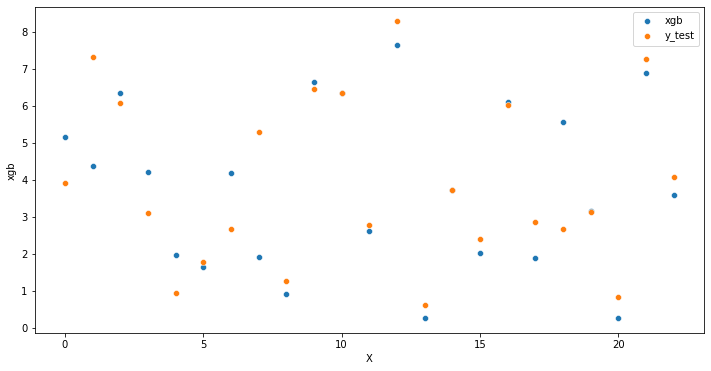

In [401]:
data = pd.DataFrame({'X': range(len(X_test4)), 'xgb': y_pred_xgb, 'nn': y_pred_nn.reshape(-1), 'y_test': y_test4})
sns.scatterplot(data=data, x='X', y='xgb', label='xgb')
sns.scatterplot(data=data, x='X', y='y_test', label='y_test')

In [402]:
mean_squared_error(y_test4, y_pred_xgb, squared=False)

1.2692358905519803

Сохраняем модель XGB, в которой явно задан признак наличия ампулы

In [412]:
bst_3.save_model('bst.model')

In [413]:
model_xgb_loaded = xgb.Booster()
model_xgb_loaded.load_model('bst.model')

In [416]:
model_xgb_loaded.predict(dtest)

array([7.474205 , 3.8773942, 8.131913 , 3.9652543, 3.7872937, 3.922864 ,
       5.859787 , 3.3552685, 2.7812178, 7.560059 , 8.131913 , 4.5753736,
       7.7314825, 2.2182066, 3.5080204, 2.4808357, 8.008597 , 3.3118079],
      dtype=float32)